[View in Colaboratory](https://colab.research.google.com/github/opooladz/ece_210_final_project/blob/master/210_final_project_neural_nets.ipynb)

In [2]:
# Import Libs 
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
import scipy.io as sio
import math
import tensorflow as tf
import keras


%matplotlib inline

Using TensorFlow backend.


In [0]:
from keras import backend as K

def categorical_crossentropy_with_masking(yTrue,yPred):
  """
  Custom loss function to allow for masking 
  Assumption is that yTrue has a one-hot encoding and only has an all zero vector if that element should be masked
  """
  #find which values in yTrue (target) are 0
  #since y is shaped as (batch, length, features), the entire output vector must be true
  mask = K.all(K.equal(yTrue, 0), axis=-1)
  mask = 1 - K.cast(mask, K.floatx())
  # multiply categorical_crossentropy with the mask
  loss = K.categorical_crossentropy(yTrue, yPred) * mask

  # take average w.r.t. the number of unmasked entries
  return K.sum(loss) / K.sum(mask)

def accuracy_with_masking(yTrue,yPred):
  """
  Custom metric function to allow for masking
  """
  mask = K.all(K.equal(yTrue, 0), axis=-1)
  mask = 1 - K.cast(mask, K.floatx())
  # Get categorical accuracy
  loss = K.cast(K.equal(K.argmax(yTrue, axis=-1),
                          K.argmax(yPred, axis=-1)),
                  K.floatx()) 
  loss = loss*mask

  # take average w.r.t. the number of unmasked entries
  return K.sum(loss) / K.sum(mask)

# Keras try model 
def try_model_lstm(model, data, epochs=200, verbose=1):
  """
  model - Keras model
  data - dictionary of training, testing, and validation data 
  name - str, name to save file under
  epochs - number of epochs to run
  verbose- boolean
  mask - array to mask output
  """
  reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy_with_masking', factor=0.2,
                              patience=5,verbose = verbose)
  model.compile(optimizer='nadam',
            loss=categorical_crossentropy_with_masking,
            metrics=[accuracy_with_masking])

  model.summary()  
  history = model.fit(data['x_train'], data['y_train'], 
            epochs=epochs, batch_size=250, verbose=verbose, 
            validation_data=(data['x_val'], data['y_val']),
                     callbacks=[reduce_lr])  
  score = model.evaluate(data['x_test'], data['y_test'])
  print('Test accuracy: {}'.format(score))
  
  return history,score

def try_model_conv(model, data, epochs=200, verbose=1):
  """
  model - Keras model
  data - dictionary of training, testing, and validation data 
  name - str, name to save file under
  epochs - number of epochs to run
  verbose- boolean
  mask - array to mask output
  """
  model.compile(optimizer='nadam',
            loss="categorical_crossentropy",
            metrics=["accuracy"])

  model.summary()  
  history = model.fit(data['x_train'], data['y_train'], 
            epochs=epochs, batch_size=250, verbose=verbose, 
            validation_data=(data['x_val'], data['y_val']))  
  score = model.evaluate(data['x_test'], data['y_test'])
  print('Test accuracy: {}'.format(score))
  
  return history,score

In [6]:
display('hello')

'hello'

# Time-Invariant Channel

In [0]:
# Comms Stuff Will add more later
def qammod(m,y):
  if(np.all(y>=m)):
    print('qammod: all elements of X must be in range [0,M-1]')
  
  if (~np.all(y == np.fix(y) ) ):
    print("qammod: all elements of X must be integers");
  
  c = np.sqrt(m);
  if( ~(np.all(c == np.fix(c)) and np.all(np.math.log(c, 2) == np.fix(np.math.log(c, 2))) ) ):
    print("qammod: M must be a square of a power of 2");
  
  b = -2*np.fmod(y,c) + c - 1.;
  a = 2*np.floor(y *1./c) - c + 1.;
  x = a + 1.*1j*b
  # lets hold x in a np array([real,imag])
  # x = np.array([a,1.*b]).T
  return [x , y] 

def qammod2(m,size,trials):
  """
  m - highest integer for the randint
  """
  y = np.random.randint(m,size=(trials,size))
  if(np.all(y>=m)):
    print('qammod: all elements of X must be in range [0,M-1]')
  
  if (~np.all(y == np.fix(y) ) ):
    print("qammod: all elements of X must be integers");
  
  c = np.sqrt(m);
  if( ~(np.all(c == np.fix(c)) and np.all(np.math.log(c, 2) == np.fix(np.math.log(c, 2))) ) ):
    print("qammod: M must be a square of a power of 2");
  
  b = -2*np.fmod(y,c) + c - 1.;
  a = 2*np.floor(y *1./c) - c + 1.;
  #x = a + 1.*1j*b
  # lets hold x in a dp array([real,imag])
  #x = np.array([a,1.*b])
  x = np.dstack((a,b))
  return [x , y]                        

def sim_channel(m,sequenceLen,trials,Noise,SNRdB,h):
  """
  Simulates a channel
  Input:
    m - order of modulation
    sequenceLen - lenght of sequence
    trials - number trials
    Noise - Boolean, if noise should be added
    SNRdB - Ratio of signal to noise
    h- channel parameters
  """
  [x,y] = qammod2(m,sequenceLen,trials)
  
  xh = np.apply_along_axis(lambda q: np.convolve(q,h,mode="full"),axis = 1,arr=x)
  ## this added for phase offset 7/3/18
  Ts = 1/(2.8e6);
  fc = 2e6;
  CP = np.exp(np.arange(0,len(xh))*2*1j*math.pi*Ts*fc)
  CP = CP[:,np.newaxis]
  CP = np.transpose(CP,(1,0))
  xh = np.transpose(xh,(2,1,0))
  display(xh.shape)
  display(CP.shape)
  xh =  xh*CP
  xh = np.transpose(xh,(2,1,0))
  display(xh.shape)  
  ## edit ends 
  if(Noise):
    SNR = 10**(SNRdB/10)
    sym_noise_pow = np.var(xh)/SNR
    sym_noise_scale_fact = np.sqrt(sym_noise_pow/2)
    AWGN = sym_noise_scale_fact*np.random.normal(1, size=xh.shape) 
    xh = xh + AWGN
  return [xh ,y ]
  
  
def generateData(m,sequenceLen,trials,Noise,SNRdB,h,padding= True):
  """
  Generates training, testing, and validation data for time invariant channels
  Does one-hot encoding and padding
  m - symbol alphabet
  sequenceLen - length of data sequence
  trials - number of samples
  Noise- Boolean of whether to use AWGN
  SNRdB - amount of noise
  h - channel parameters
  """
  data={}
  [data['x_train'],data['y_train']] = sim_channel(m=m,sequenceLen=sequenceLen,trials=trials,Noise=Noise,SNRdB=SNRdB,h=h)
  [data['x_val'],data['y_val']] = sim_channel(m=m,sequenceLen=sequenceLen,trials=int(trials*0.25),Noise= Noise,SNRdB=SNRdB,h=h)
  [data['x_test'],data['y_test']] = sim_channel(m=m,sequenceLen=sequenceLen,trials=trials,Noise=Noise,SNRdB=SNRdB,h=h)
  
  print("x_train shape: ",data['x_train'].shape) # data, expected seqlen+chanelLen-1
  print("y_train shape: ",data['y_train'].shape) # labels
  
  #One hot encoding
  y_train = keras.utils.to_categorical(data['y_train'] , num_classes=m)
  y_val = keras.utils.to_categorical(data['y_val'] , num_classes=m)
  y_test = keras.utils.to_categorical(data['y_test'] , num_classes=m)
  print("y_train shape, one-hot: ",y_train.shape)

  #Padding 
  if(padding):
    y_train = np.pad(y_train,((0,0),(0,chanelLen-1),(0,0)),"constant")
    y_val = np.pad(y_val,((0,0),(0,chanelLen-1),(0,0)),"constant")
    y_test = np.pad(y_test,((0,0),(0,chanelLen-1),(0,0)),"constant")

  print("y_train shape, one-hot, padding: ",y_train.shape)

  default_data = {
    'x_train': data['x_train'],
    'x_val': data['x_val'],
    'x_test': data['x_test'],
    'y_train': y_train,
    'y_val': y_val,
    'y_test': y_test,
  }
  return default_data
  

In [38]:
# Instantiating Data

m = 4         # order of modulation
trials = 100000 # number of trials 
Noise = True
SNRdB = 10
seqLen = 300
print(seqLen)
#h = [1,0.4,0.3,0.2,0.25]
chanelLen = 5
h = np.random.rand(chanelLen)
h[0] = 1

300


In [13]:
default_data_pad = generateData(m,seqLen,trials,Noise,SNRdB,h,padding=True)


(2, 302, 100)

(1, 100)

(100, 302, 2)

(2, 302, 25)

(1, 25)

(25, 302, 2)

(2, 302, 100)

(1, 100)

(100, 302, 2)

x_train shape:  (100, 302, 2)
y_train shape:  (100, 300)
y_train shape, one-hot:  (100, 300, 4)
y_train shape, one-hot, padding:  (100, 302, 4)


In [11]:
np.exp(2)

7.38905609893065

In [57]:
# QAM-4
from keras.models import Sequential
from keras import regularizers
from keras.layers import Dense,CuDNNLSTM, TimeDistributed,Softmax,Flatten,Bidirectional,Reshape,Embedding,Conv1D, Softmax,Flatten,BatchNormalization
import keras

#Base Test for models

#LSTM
default_data_pad = generateData(m,seqLen,trials,Noise,SNRdB,h,padding=True)
modLSTM = Sequential()
#modLSTM.add(Bidirectional(CuDNNLSTM(10,return_sequences=True),input_shape=(seqLen+chanelLen-1,2)))
modLSTM.add(CuDNNLSTM(50,return_sequences=True,input_shape=(seqLen+chanelLen-1,2)))
modLSTM.add(CuDNNLSTM(50,return_sequences=True))
modLSTM.add(CuDNNLSTM(50,return_sequences=True))

modLSTM.add(TimeDistributed(Dense(m,activation="softmax")))
hist,score = try_model_lstm(modLSTM, default_data_pad, epochs=40)
print(score)
print(hist.history)

# #CNN
# default_data_no_pad = generateData(m,seqLen,trials,Noise,SNRdB,h,padding=False)
# modCNN = Sequential()
# modCNN.add(Conv1D(5,kernel_size=(chanelLen+1), input_shape=(seqLen+chanelLen-1,2) ))
# # modCNN.add(BatchNormalization())
# # modCNN.add(Flatten())
# # modCNN.add(Dense(seqLen*m,bias_regularizer=regularizers.l2(0.005)))
# modCNN.add(Reshape(target_shape = (seqLen,m)))
# modCNN.add(TimeDistributed(Dense(m,activation="softmax")))
# modCNN.add(Softmax(axis=2))
# hist,score = try_model_conv(modCNN, default_data_no_pad, epochs=10)
# print(score)
# print(hist.history)

(2, 304, 10000)

(1, 10000)

(10000, 304, 2)

(2, 304, 2500)

(1, 2500)

(2500, 304, 2)

(2, 304, 10000)

(1, 10000)

(10000, 304, 2)

x_train shape:  (10000, 304, 2)
y_train shape:  (10000, 300)
y_train shape, one-hot:  (10000, 300, 4)
y_train shape, one-hot, padding:  (10000, 304, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_49 (CuDNNLSTM)    (None, 304, 50)           10800     
_________________________________________________________________
cu_dnnlstm_50 (CuDNNLSTM)    (None, 304, 50)           20400     
_________________________________________________________________
cu_dnnlstm_51 (CuDNNLSTM)    (None, 304, 50)           20400     
_________________________________________________________________
time_distributed_22 (TimeDis (None, 304, 4)            204       
Total params: 51,804
Trainable params: 51,804
Non-trainable params: 0
_________________________________________________________________
Train on 10000 samples, validate on 2500 samples
Epoch 1/40


/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


10000/10000 [==============================] - 13s 1ms/step - loss: 1.3864 - accuracy_with_masking: 0.2519 - val_loss: 1.3862 - val_accuracy_with_masking: 0.2526
Epoch 2/40
10000/10000 [==============================] - 8s 826us/step - loss: 1.3867 - accuracy_with_masking: 0.2640 - val_loss: 1.3685 - val_accuracy_with_masking: 0.2900
Epoch 3/40
10000/10000 [==============================] - 8s 754us/step - loss: 1.3125 - accuracy_with_masking: 0.3231 - val_loss: 1.2736 - val_accuracy_with_masking: 0.3419
Epoch 4/40
10000/10000 [==============================] - 7s 730us/step - loss: 1.2641 - accuracy_with_masking: 0.3439 - val_loss: 1.2578 - val_accuracy_with_masking: 0.3569
Epoch 5/40
10000/10000 [==============================] - 7s 740us/step - loss: 1.2178 - accuracy_with_masking: 0.3703 - val_loss: 1.1584 - val_accuracy_with_masking: 0.3952
Epoch 6/40
 2250/10000 [=====>........................] - ETA: 5s - loss: 1.1573 - accuracy_with_masking: 0.3973

10000/10000 [==============================] - 7s 735us/step - loss: 1.1196 - accuracy_with_masking: 0.4399 - val_loss: 1.0623 - val_accuracy_with_masking: 0.4802
Epoch 7/40
10000/10000 [==============================] - 7s 728us/step - loss: 0.8839 - accuracy_with_masking: 0.5788 - val_loss: 0.7959 - val_accuracy_with_masking: 0.6351
Epoch 8/40
10000/10000 [==============================] - 7s 733us/step - loss: 0.6732 - accuracy_with_masking: 0.6733 - val_loss: 0.5540 - val_accuracy_with_masking: 0.7511
Epoch 9/40
10000/10000 [==============================] - 7s 738us/step - loss: 0.9702 - accuracy_with_masking: 0.5115 - val_loss: 0.9575 - val_accuracy_with_masking: 0.4491
Epoch 10/40
10000/10000 [==============================] - 7s 734us/step - loss: 0.9557 - accuracy_with_masking: 0.4584 - val_loss: 0.9742 - val_accuracy_with_masking: 0.4774
Epoch 11/40
 2500/10000 [======>.......................] - ETA: 5s - loss: 0.9529 - accuracy_with_masking: 0.4704

10000/10000 [==============================] - 7s 739us/step - loss: 0.8277 - accuracy_with_masking: 0.5526 - val_loss: 0.7159 - val_accuracy_with_masking: 0.6180
Epoch 12/40
10000/10000 [==============================] - 7s 727us/step - loss: 0.8751 - accuracy_with_masking: 0.4914 - val_loss: 0.8845 - val_accuracy_with_masking: 0.4429
Epoch 13/40
10000/10000 [==============================] - 7s 741us/step - loss: 0.8765 - accuracy_with_masking: 0.4733 - val_loss: 0.8621 - val_accuracy_with_masking: 0.5141

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
Epoch 14/40
10000/10000 [==============================] - 7s 740us/step - loss: 0.8498 - accuracy_with_masking: 0.5367 - val_loss: 0.8410 - val_accuracy_with_masking: 0.5492
Epoch 15/40
10000/10000 [==============================] - 7s 746us/step - loss: 0.8255 - accuracy_with_masking: 0.5739 - val_loss: 0.7958 - val_accuracy_with_masking: 0.5958
Epoch 16/40
  750/10000 [=>............................]

10000/10000 [==============================] - 8s 755us/step - loss: 0.7504 - accuracy_with_masking: 0.6130 - val_loss: 0.7009 - val_accuracy_with_masking: 0.6209
Epoch 17/40
10000/10000 [==============================] - 7s 748us/step - loss: 0.6306 - accuracy_with_masking: 0.6622 - val_loss: 0.5664 - val_accuracy_with_masking: 0.7167
Epoch 18/40
10000/10000 [==============================] - 7s 743us/step - loss: 0.5418 - accuracy_with_masking: 0.7409 - val_loss: 0.5256 - val_accuracy_with_masking: 0.7519
Epoch 19/40
10000/10000 [==============================] - 7s 724us/step - loss: 0.5147 - accuracy_with_masking: 0.7580 - val_loss: 0.5066 - val_accuracy_with_masking: 0.7614
Epoch 20/40
10000/10000 [==============================] - 7s 729us/step - loss: 0.4982 - accuracy_with_masking: 0.7651 - val_loss: 0.4918 - val_accuracy_with_masking: 0.7667
Epoch 21/40
 2250/10000 [=====>........................] - ETA: 5s - loss: 0.4915 - accuracy_with_masking: 0.7701

10000/10000 [==============================] - 7s 735us/step - loss: 0.4840 - accuracy_with_masking: 0.7684 - val_loss: 0.4763 - val_accuracy_with_masking: 0.7684
Epoch 22/40
10000/10000 [==============================] - 7s 741us/step - loss: 0.5834 - accuracy_with_masking: 0.6872 - val_loss: 0.6267 - val_accuracy_with_masking: 0.6533
Epoch 23/40
10000/10000 [==============================] - 7s 732us/step - loss: 0.5744 - accuracy_with_masking: 0.7342 - val_loss: 0.5315 - val_accuracy_with_masking: 0.7686
Epoch 24/40
10000/10000 [==============================] - 7s 720us/step - loss: 0.5157 - accuracy_with_masking: 0.7701 - val_loss: 0.5045 - val_accuracy_with_masking: 0.7694
Epoch 25/40
10000/10000 [==============================] - 7s 722us/step - loss: 0.5594 - accuracy_with_masking: 0.7416 - val_loss: 0.5126 - val_accuracy_with_masking: 0.7636
Epoch 26/40
 2500/10000 [======>.......................] - ETA: 4s - loss: 0.5065 - accuracy_with_masking: 0.7629

10000/10000 [==============================] - 7s 717us/step - loss: 0.4953 - accuracy_with_masking: 0.7693 - val_loss: 0.4872 - val_accuracy_with_masking: 0.7700
Epoch 27/40
10000/10000 [==============================] - 7s 721us/step - loss: 0.4778 - accuracy_with_masking: 0.7719 - val_loss: 0.4689 - val_accuracy_with_masking: 0.7718
Epoch 28/40
10000/10000 [==============================] - 7s 731us/step - loss: 0.4484 - accuracy_with_masking: 0.7827 - val_loss: 0.4178 - val_accuracy_with_masking: 0.8046
Epoch 29/40
10000/10000 [==============================] - 7s 721us/step - loss: 0.4006 - accuracy_with_masking: 0.8295 - val_loss: 0.3615 - val_accuracy_with_masking: 0.8672
Epoch 30/40
10000/10000 [==============================] - 7s 718us/step - loss: 0.3687 - accuracy_with_masking: 0.8576 - val_loss: 0.3419 - val_accuracy_with_masking: 0.8733
Epoch 31/40
 2500/10000 [======>.......................] - ETA: 4s - loss: 0.3337 - accuracy_with_masking: 0.8779

10000/10000 [==============================] - 7s 711us/step - loss: 0.3622 - accuracy_with_masking: 0.8620 - val_loss: 0.3239 - val_accuracy_with_masking: 0.8822
Epoch 32/40
10000/10000 [==============================] - 7s 715us/step - loss: 0.3152 - accuracy_with_masking: 0.8831 - val_loss: 0.3293 - val_accuracy_with_masking: 0.8671
Epoch 33/40
10000/10000 [==============================] - 7s 710us/step - loss: 0.3408 - accuracy_with_masking: 0.8655 - val_loss: 0.2990 - val_accuracy_with_masking: 0.8885
Epoch 34/40
10000/10000 [==============================] - 7s 716us/step - loss: 0.2909 - accuracy_with_masking: 0.8905 - val_loss: 0.2913 - val_accuracy_with_masking: 0.8912
Epoch 35/40
10000/10000 [==============================] - 7s 703us/step - loss: 0.3593 - accuracy_with_masking: 0.8666 - val_loss: 0.3200 - val_accuracy_with_masking: 0.8877
Epoch 36/40
 2500/10000 [======>.......................] - ETA: 4s - loss: 0.2925 - accuracy_with_masking: 0.8916

10000/10000 [==============================] - 7s 708us/step - loss: 0.5022 - accuracy_with_masking: 0.8040 - val_loss: 1.1646 - val_accuracy_with_masking: 0.4344
Epoch 37/40
10000/10000 [==============================] - 7s 708us/step - loss: 0.5933 - accuracy_with_masking: 0.6988 - val_loss: 0.4740 - val_accuracy_with_masking: 0.7895
Epoch 38/40
10000/10000 [==============================] - 7s 702us/step - loss: 0.4319 - accuracy_with_masking: 0.8556 - val_loss: 0.3920 - val_accuracy_with_masking: 0.8843
Epoch 39/40
10000/10000 [==============================] - 7s 716us/step - loss: 0.3679 - accuracy_with_masking: 0.8901 - val_loss: 0.3496 - val_accuracy_with_masking: 0.8918
Epoch 40/40
  320/10000 [..............................] - ETA: 20s

10000/10000 [==============================] - 21s 2ms/step
Test accuracy: [0.32292642374038694, 0.8958269995689392]
[0.32292642374038694, 0.8958269995689392]
{'val_loss': [1.3861778259277344, 1.368507730960846, 1.2735928416252136, 1.2578360795974732, 1.1584417223930359, 1.0623291373252868, 0.795876407623291, 0.5540367543697358, 0.9574527084827423, 0.9741834282875061, 0.7159248888492584, 0.8844923913478852, 0.8620873034000397, 0.840982049703598, 0.7958129644393921, 0.7009022891521454, 0.5663875997066498, 0.52563436627388, 0.5065935015678406, 0.4918309569358826, 0.47627205550670626, 0.6266883671283722, 0.5315119326114655, 0.5045366019010544, 0.5126438200473785, 0.4871951133012772, 0.46890593469142916, 0.41777822077274324, 0.36146115362644193, 0.34189322888851165, 0.3238632529973984, 0.32934745252132414, 0.29903939068317414, 0.29129746556282043, 0.31995123624801636, 1.1645796775817872, 0.4740373492240906, 0.3920036792755127, 0.3496206492185593, 0.32288319170475005], 'val_accuracy_with_ma

In [59]:
snrs = np.linspace(20,20,1)
snrs

array([20.])

## Comparing Equalizer symbol error across different SNR for CNN and LSTM

In [68]:
#@title Default title text
m = 4         # order of modulation
trials = 10000   # number of trials 
Noise = True
x = 4
seqLen = 300
print(seqLen)
# chanelLen = 5
# h = np.random.rand(chanelLen)*0.5
# h[0] = 1
h = np.array([1,0.5,-0.3])
chanelLen = len(h)
print("Channel: ",h)

snrs = np.linspace(20,-15,10)
histories_lstm = []
scores_lstm = []
histories_conv = []
scores_conv = []
for SNRdB in snrs:
  print("SNRdB: ",SNRdB)

  #LSTM
  default_data_pad = generateData(m,seqLen,trials,Noise,SNRdB,h,padding=True)
  modLSTM = Sequential()
  #modLSTM.add(Bidirectional(CuDNNLSTM(10,return_sequences=True),input_shape=(seqLen+chanelLen-1,2)))
  modLSTM.add(CuDNNLSTM(50,return_sequences=True,input_shape=(seqLen+chanelLen-1,2)))
  modLSTM.add(CuDNNLSTM(50,return_sequences=True))
  modLSTM.add(CuDNNLSTM(50,return_sequences=True))
  modLSTM.add(TimeDistributed(Dense(m,activation="softmax")))
  hist,score = try_model_lstm(modLSTM, default_data_pad, epochs=15)
  print(score)
  histories_lstm.append(hist)
  scores_lstm.append(score)
  
  #CNN
  default_data_no_pad = generateData(m,seqLen,trials,Noise,SNRdB,h,padding=False)
  modCNN = Sequential()
  modCNN.add(Conv1D(10,kernel_size=(chanelLen), input_shape=(seqLen+chanelLen-1,2) ))
  modCNN.add(BatchNormalization())
  modCNN.add(Flatten())
  modCNN.add(Dense(seqLen*m,bias_regularizer=regularizers.l2(0.005)))
  modCNN.add(Reshape(target_shape = (seqLen,m)))
  modCNN.add(Softmax(axis=2))
  hist,score = try_model_conv(modCNN, default_data_no_pad, epochs=10)
  print(score)
  histories_conv.append(hist)
  scores_conv.append(score)
  print("Score: ",score)

300
Channel:  [ 1.   0.5 -0.3]
SNRdB:  20.0


(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

(2, 302, 2500)

(1, 2500)

(2500, 302, 2)

(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

x_train shape:  (10000, 302, 2)
y_train shape:  (10000, 300)
y_train shape, one-hot:  (10000, 300, 4)
y_train shape, one-hot, padding:  (10000, 302, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_58 (CuDNNLSTM)    (None, 302, 50)           10800     
_________________________________________________________________
cu_dnnlstm_59 (CuDNNLSTM)    (None, 302, 50)           20400     
_________________________________________________________________
cu_dnnlstm_60 (CuDNNLSTM)    (None, 302, 50)           20400     
_________________________________________________________________
time_distributed_25 (TimeDis (None, 302, 4)            204       
Total params: 51,804
Trainable params: 51,804
Non-trainable params: 0
_________________________________________________________________
Train on 10000 samples, validate on 2500 samples
Epoch 1/15


/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


10000/10000 [==============================] - 13s 1ms/step - loss: 1.3859 - accuracy_with_masking: 0.2569 - val_loss: 1.3840 - val_accuracy_with_masking: 0.2544
Epoch 2/15
10000/10000 [==============================] - 7s 734us/step - loss: 1.2603 - accuracy_with_masking: 0.3630 - val_loss: 1.0336 - val_accuracy_with_masking: 0.4348
Epoch 3/15
10000/10000 [==============================] - 7s 740us/step - loss: 0.9108 - accuracy_with_masking: 0.4665 - val_loss: 0.8243 - val_accuracy_with_masking: 0.4893
Epoch 4/15
10000/10000 [==============================] - 7s 729us/step - loss: 0.7737 - accuracy_with_masking: 0.5421 - val_loss: 0.7316 - val_accuracy_with_masking: 0.6013
Epoch 5/15
10000/10000 [==============================] - 7s 732us/step - loss: 0.6558 - accuracy_with_masking: 0.6536 - val_loss: 0.6208 - val_accuracy_with_masking: 0.6405
Epoch 6/15
 2500/10000 [======>.......................] - ETA: 4s - loss: 0.5256 - accuracy_with_masking: 0.7040

10000/10000 [==============================] - 7s 729us/step - loss: 0.4331 - accuracy_with_masking: 0.7839 - val_loss: 0.3495 - val_accuracy_with_masking: 0.8320
Epoch 7/15
10000/10000 [==============================] - 7s 733us/step - loss: 0.5381 - accuracy_with_masking: 0.7186 - val_loss: 0.6440 - val_accuracy_with_masking: 0.6222
Epoch 8/15
10000/10000 [==============================] - 7s 728us/step - loss: 0.4980 - accuracy_with_masking: 0.7990 - val_loss: 0.3903 - val_accuracy_with_masking: 0.8260
Epoch 9/15
10000/10000 [==============================] - 7s 727us/step - loss: 0.5964 - accuracy_with_masking: 0.6589 - val_loss: 0.5377 - val_accuracy_with_masking: 0.6988
Epoch 10/15
10000/10000 [==============================] - 7s 722us/step - loss: 0.4712 - accuracy_with_masking: 0.7480 - val_loss: 0.3700 - val_accuracy_with_masking: 0.8332
Epoch 11/15
 2750/10000 [=======>......................] - ETA: 4s - loss: 0.3582 - accuracy_with_masking: 0.8364

10000/10000 [==============================] - 7s 733us/step - loss: 0.4044 - accuracy_with_masking: 0.8100 - val_loss: 0.9262 - val_accuracy_with_masking: 0.4670
Epoch 12/15
10000/10000 [==============================] - 7s 716us/step - loss: 0.4991 - accuracy_with_masking: 0.7362 - val_loss: 0.3542 - val_accuracy_with_masking: 0.8301
Epoch 13/15
10000/10000 [==============================] - 7s 717us/step - loss: 0.4228 - accuracy_with_masking: 0.7929 - val_loss: 0.4114 - val_accuracy_with_masking: 0.7965
Epoch 14/15
10000/10000 [==============================] - 7s 712us/step - loss: 0.3414 - accuracy_with_masking: 0.8430 - val_loss: 0.3766 - val_accuracy_with_masking: 0.8247
Epoch 15/15
  352/10000 [>.............................] - ETA: 19s

10000/10000 [==============================] - 20s 2ms/step
Test accuracy: [0.2594971917629242, 0.8661853340148926]
[0.2594971917629242, 0.8661853340148926]


(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

(2, 302, 2500)

(1, 2500)

(2500, 302, 2)

(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

x_train shape:  (10000, 302, 2)
y_train shape:  (10000, 300)
y_train shape, one-hot:  (10000, 300, 4)
y_train shape, one-hot, padding:  (10000, 300, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_17 (Conv1D)           (None, 300, 10)           70        
_________________________________________________________________
batch_normalization_17 (Batc (None, 300, 10)           40        
_________________________________________________________________
flatten_7 (Flatten)          (None, 3000)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 1200)              3601200   
_________________________________________________________________
reshape_7 (Reshape)          (None, 300, 4)            0         
_________________________________________________________________
softmax_7 (Softmax)          (None, 300, 4)            0

10000/10000 [==============================] - 1s 133us/step - loss: 1.4600 - acc: 0.2935 - val_loss: 1.5205 - val_acc: 0.2498
Epoch 4/10
10000/10000 [==============================] - 1s 120us/step - loss: 1.4431 - acc: 0.2993 - val_loss: 1.5085 - val_acc: 0.2504
Epoch 5/10
10000/10000 [==============================] - 1s 143us/step - loss: 1.4267 - acc: 0.3048 - val_loss: 1.4978 - val_acc: 0.2511
Epoch 6/10
10000/10000 [==============================] - 1s 137us/step - loss: 1.4110 - acc: 0.3098 - val_loss: 1.4897 - val_acc: 0.2505
Epoch 7/10
10000/10000 [==============================] - 1s 120us/step - loss: 1.3963 - acc: 0.3161 - val_loss: 1.4825 - val_acc: 0.2500
Epoch 8/10
10000/10000 [==============================] - 1s 120us/step - loss: 1.3831 - acc: 0.3211 - val_loss: 1.4764 - val_acc: 0.2500
Epoch 9/10
10000/10000 [==============================] - 1s 133us/step - loss: 1.3711 - acc: 0.3282 - val_loss: 1.4718 - val_acc: 0.2495
Epoch 10/10
   32/10000 [....................

10000/10000 [==============================] - 2s 184us/step
Test accuracy: [1.4676111526489257, 0.2500066665649414]
[1.4676111526489257, 0.2500066665649414]
Score:  [1.4676111526489257, 0.2500066665649414]
SNRdB:  16.11111111111111


(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

(2, 302, 2500)

(1, 2500)

(2500, 302, 2)

(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

x_train shape:  (10000, 302, 2)
y_train shape:  (10000, 300)
y_train shape, one-hot:  (10000, 300, 4)
y_train shape, one-hot, padding:  (10000, 302, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_61 (CuDNNLSTM)    (None, 302, 50)           10800     
_________________________________________________________________
cu_dnnlstm_62 (CuDNNLSTM)    (None, 302, 50)           20400     
_________________________________________________________________
cu_dnnlstm_63 (CuDNNLSTM)    (None, 302, 50)           20400     
_________________________________________________________________
time_distributed_26 (TimeDis (None, 302, 4)            204       
Total params: 51,804
Trainable params: 51,804
Non-trainable params: 0
_________________________________________________________________
Train on 10000 samples, validate on 2500 samples
Epoch 1/15
10000/10000 [==============================] - 13s 1ms/ste

10000/10000 [==============================] - 7s 719us/step - loss: 1.2179 - accuracy_with_masking: 0.3680 - val_loss: 0.9591 - val_accuracy_with_masking: 0.4601
Epoch 3/15
10000/10000 [==============================] - 7s 710us/step - loss: 0.8911 - accuracy_with_masking: 0.4808 - val_loss: 0.8270 - val_accuracy_with_masking: 0.5331
Epoch 4/15
10000/10000 [==============================] - 7s 717us/step - loss: 0.8018 - accuracy_with_masking: 0.5550 - val_loss: 0.7475 - val_accuracy_with_masking: 0.5995
Epoch 5/15
10000/10000 [==============================] - 7s 713us/step - loss: 0.6749 - accuracy_with_masking: 0.6628 - val_loss: 0.6016 - val_accuracy_with_masking: 0.7445
Epoch 6/15
10000/10000 [==============================] - 7s 710us/step - loss: 0.4603 - accuracy_with_masking: 0.7972 - val_loss: 0.4129 - val_accuracy_with_masking: 0.8044
Epoch 7/15
 3250/10000 [========>.....................] - ETA: 4s - loss: 0.4135 - accuracy_with_masking: 0.7945

10000/10000 [==============================] - 7s 723us/step - loss: 0.6219 - accuracy_with_masking: 0.6786 - val_loss: 0.5999 - val_accuracy_with_masking: 0.6673
Epoch 8/15
10000/10000 [==============================] - 8s 758us/step - loss: 0.5075 - accuracy_with_masking: 0.7270 - val_loss: 0.4239 - val_accuracy_with_masking: 0.7990
Epoch 9/15
10000/10000 [==============================] - 8s 759us/step - loss: 0.5170 - accuracy_with_masking: 0.7337 - val_loss: 0.6301 - val_accuracy_with_masking: 0.6586
Epoch 10/15
10000/10000 [==============================] - 8s 764us/step - loss: 0.5976 - accuracy_with_masking: 0.6672 - val_loss: 0.5741 - val_accuracy_with_masking: 0.6736
Epoch 11/15
10000/10000 [==============================] - 8s 760us/step - loss: 0.5500 - accuracy_with_masking: 0.6900 - val_loss: 0.5405 - val_accuracy_with_masking: 0.6704

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
Epoch 12/15
 2500/10000 [======>.......................] -

10000/10000 [==============================] - 8s 780us/step - loss: 0.5201 - accuracy_with_masking: 0.6863 - val_loss: 0.4935 - val_accuracy_with_masking: 0.7133
Epoch 13/15
10000/10000 [==============================] - 8s 765us/step - loss: 0.4556 - accuracy_with_masking: 0.7726 - val_loss: 0.4393 - val_accuracy_with_masking: 0.7979
Epoch 14/15
10000/10000 [==============================] - 8s 762us/step - loss: 0.4322 - accuracy_with_masking: 0.8006 - val_loss: 0.4269 - val_accuracy_with_masking: 0.8025
Epoch 15/15
 1760/10000 [====>.........................] - ETA: 20s

10000/10000 [==============================] - 25s 2ms/step
Test accuracy: [0.4171724018573761, 0.8045469994544983]
[0.4171724018573761, 0.8045469994544983]


(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

(2, 302, 2500)

(1, 2500)

(2500, 302, 2)

(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

x_train shape:  (10000, 302, 2)
y_train shape:  (10000, 300)
y_train shape, one-hot:  (10000, 300, 4)
y_train shape, one-hot, padding:  (10000, 300, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 300, 10)           70        
_________________________________________________________________
batch_normalization_18 (Batc (None, 300, 10)           40        
_________________________________________________________________
flatten_8 (Flatten)          (None, 3000)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 1200)              3601200   
_________________________________________________________________
reshape_8 (Reshape)          (None, 300, 4)            0         
_________________________________________________________________
softmax_8 (Softmax)          (None, 300, 4)            0

10000/10000 [==============================] - 2s 165us/step - loss: 1.4586 - acc: 0.2924 - val_loss: 1.5142 - val_acc: 0.2514
Epoch 4/10
10000/10000 [==============================] - 2s 160us/step - loss: 1.4347 - acc: 0.2996 - val_loss: 1.4958 - val_acc: 0.2511
Epoch 5/10
10000/10000 [==============================] - 2s 151us/step - loss: 1.4158 - acc: 0.3068 - val_loss: 1.4857 - val_acc: 0.2505
Epoch 6/10
10000/10000 [==============================] - 2s 157us/step - loss: 1.4009 - acc: 0.3131 - val_loss: 1.4775 - val_acc: 0.2506
Epoch 7/10
10000/10000 [==============================] - 2s 157us/step - loss: 1.3878 - acc: 0.3194 - val_loss: 1.4707 - val_acc: 0.2503
Epoch 8/10
10000/10000 [==============================] - 1s 149us/step - loss: 1.3758 - acc: 0.3253 - val_loss: 1.4642 - val_acc: 0.2506
Epoch 9/10
10000/10000 [==============================] - 1s 147us/step - loss: 1.3645 - acc: 0.3312 - val_loss: 1.4570 - val_acc: 0.2503
Epoch 10/10
 9000/10000 [====================

10000/10000 [==============================] - 2s 241us/step
Test accuracy: [1.4545700002670288, 0.24932766690254213]
[1.4545700002670288, 0.24932766690254213]
Score:  [1.4545700002670288, 0.24932766690254213]
SNRdB:  12.222222222222221


(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

(2, 302, 2500)

(1, 2500)

(2500, 302, 2)

(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

x_train shape:  (10000, 302, 2)
y_train shape:  (10000, 300)
y_train shape, one-hot:  (10000, 300, 4)
y_train shape, one-hot, padding:  (10000, 302, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_64 (CuDNNLSTM)    (None, 302, 50)           10800     
_________________________________________________________________
cu_dnnlstm_65 (CuDNNLSTM)    (None, 302, 50)           20400     
_________________________________________________________________
cu_dnnlstm_66 (CuDNNLSTM)    (None, 302, 50)           20400     
_________________________________________________________________
time_distributed_27 (TimeDis (None, 302, 4)            204       
Total params: 51,804
Trainable params: 51,804
Non-trainable params: 0
_________________________________________________________________
Train on 10000 samples, validate on 2500 samples
Epoch 1/15
10000/10000 [==============================] - 14s 1ms/ste

10000/10000 [==============================] - 7s 722us/step - loss: 1.3200 - accuracy_with_masking: 0.3208 - val_loss: 1.1249 - val_accuracy_with_masking: 0.4058
Epoch 3/15
10000/10000 [==============================] - 7s 713us/step - loss: 1.0330 - accuracy_with_masking: 0.4228 - val_loss: 1.0047 - val_accuracy_with_masking: 0.4213
Epoch 4/15
10000/10000 [==============================] - 7s 713us/step - loss: 0.9201 - accuracy_with_masking: 0.4489 - val_loss: 0.8954 - val_accuracy_with_masking: 0.4571
Epoch 5/15
10000/10000 [==============================] - 7s 722us/step - loss: 0.8867 - accuracy_with_masking: 0.4660 - val_loss: 0.8866 - val_accuracy_with_masking: 0.4811
Epoch 6/15
10000/10000 [==============================] - 7s 715us/step - loss: 0.8641 - accuracy_with_masking: 0.5191 - val_loss: 0.8491 - val_accuracy_with_masking: 0.5213
Epoch 7/15
 3250/10000 [========>.....................] - ETA: 4s - loss: 0.8497 - accuracy_with_masking: 0.5821

10000/10000 [==============================] - 7s 715us/step - loss: 0.8572 - accuracy_with_masking: 0.5465 - val_loss: 0.8251 - val_accuracy_with_masking: 0.6262
Epoch 8/15
10000/10000 [==============================] - 7s 710us/step - loss: 0.6745 - accuracy_with_masking: 0.7138 - val_loss: 0.5568 - val_accuracy_with_masking: 0.7514
Epoch 9/15
10000/10000 [==============================] - 7s 713us/step - loss: 0.7282 - accuracy_with_masking: 0.6245 - val_loss: 0.8658 - val_accuracy_with_masking: 0.5080
Epoch 10/15
10000/10000 [==============================] - 7s 712us/step - loss: 0.8350 - accuracy_with_masking: 0.5269 - val_loss: 0.7609 - val_accuracy_with_masking: 0.6061
Epoch 11/15
10000/10000 [==============================] - 7s 706us/step - loss: 0.7054 - accuracy_with_masking: 0.6344 - val_loss: 0.7118 - val_accuracy_with_masking: 0.6191
Epoch 12/15
 2750/10000 [=======>......................] - ETA: 4s - loss: 0.7000 - accuracy_with_masking: 0.6279

10000/10000 [==============================] - 7s 707us/step - loss: 0.6694 - accuracy_with_masking: 0.6422 - val_loss: 0.6039 - val_accuracy_with_masking: 0.7297
Epoch 13/15
10000/10000 [==============================] - 7s 700us/step - loss: 0.5438 - accuracy_with_masking: 0.7482 - val_loss: 0.5158 - val_accuracy_with_masking: 0.7587
Epoch 14/15
10000/10000 [==============================] - 7s 704us/step - loss: 0.7986 - accuracy_with_masking: 0.5961 - val_loss: 0.7269 - val_accuracy_with_masking: 0.6143
Epoch 15/15
 1728/10000 [====>.........................] - ETA: 16s

10000/10000 [==============================] - 21s 2ms/step
Test accuracy: [0.5411735193252564, 0.7484720005989075]
[0.5411735193252564, 0.7484720005989075]


(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

(2, 302, 2500)

(1, 2500)

(2500, 302, 2)

(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

x_train shape:  (10000, 302, 2)
y_train shape:  (10000, 300)
y_train shape, one-hot:  (10000, 300, 4)
y_train shape, one-hot, padding:  (10000, 300, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_19 (Conv1D)           (None, 300, 10)           70        
_________________________________________________________________
batch_normalization_19 (Batc (None, 300, 10)           40        
_________________________________________________________________
flatten_9 (Flatten)          (None, 3000)              0         
_________________________________________________________________
dense_36 (Dense)             (None, 1200)              3601200   
_________________________________________________________________
reshape_9 (Reshape)          (None, 300, 4)            0         
_________________________________________________________________
softmax_9 (Softmax)          (None, 300, 4)            0

10000/10000 [==============================] - 1s 133us/step - loss: 1.4575 - acc: 0.2949 - val_loss: 1.5191 - val_acc: 0.2505
Epoch 4/10
10000/10000 [==============================] - 1s 133us/step - loss: 1.4394 - acc: 0.3028 - val_loss: 1.5072 - val_acc: 0.2509
Epoch 5/10
10000/10000 [==============================] - 1s 126us/step - loss: 1.4231 - acc: 0.3088 - val_loss: 1.4956 - val_acc: 0.2510
Epoch 6/10
10000/10000 [==============================] - 1s 132us/step - loss: 1.4079 - acc: 0.3136 - val_loss: 1.4841 - val_acc: 0.2513
Epoch 7/10
10000/10000 [==============================] - 1s 132us/step - loss: 1.3939 - acc: 0.3196 - val_loss: 1.4747 - val_acc: 0.2511
Epoch 8/10
10000/10000 [==============================] - 1s 135us/step - loss: 1.3796 - acc: 0.3252 - val_loss: 1.4657 - val_acc: 0.2513
Epoch 9/10
10000/10000 [==============================] - 1s 130us/step - loss: 1.3653 - acc: 0.3323 - val_loss: 1.4593 - val_acc: 0.2508
Epoch 10/10
  320/10000 [....................

10000/10000 [==============================] - 2s 215us/step
Test accuracy: [1.4539457052230835, 0.25011266617774963]
[1.4539457052230835, 0.25011266617774963]
Score:  [1.4539457052230835, 0.25011266617774963]
SNRdB:  8.333333333333334


(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

(2, 302, 2500)

(1, 2500)

(2500, 302, 2)

(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

x_train shape:  (10000, 302, 2)
y_train shape:  (10000, 300)
y_train shape, one-hot:  (10000, 300, 4)
y_train shape, one-hot, padding:  (10000, 302, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_67 (CuDNNLSTM)    (None, 302, 50)           10800     
_________________________________________________________________
cu_dnnlstm_68 (CuDNNLSTM)    (None, 302, 50)           20400     
_________________________________________________________________
cu_dnnlstm_69 (CuDNNLSTM)    (None, 302, 50)           20400     
_________________________________________________________________
time_distributed_28 (TimeDis (None, 302, 4)            204       
Total params: 51,804
Trainable params: 51,804
Non-trainable params: 0
_________________________________________________________________
Train on 10000 samples, validate on 2500 samples
Epoch 1/15
10000/10000 [==============================] - 14s 1ms/ste

10000/10000 [==============================] - 7s 718us/step - loss: 1.3351 - accuracy_with_masking: 0.3134 - val_loss: 1.1962 - val_accuracy_with_masking: 0.3731
Epoch 3/15
10000/10000 [==============================] - 7s 732us/step - loss: 1.1325 - accuracy_with_masking: 0.3916 - val_loss: 1.0524 - val_accuracy_with_masking: 0.4176
Epoch 4/15
10000/10000 [==============================] - 7s 728us/step - loss: 1.0294 - accuracy_with_masking: 0.4199 - val_loss: 0.9922 - val_accuracy_with_masking: 0.4330
Epoch 5/15
10000/10000 [==============================] - 7s 725us/step - loss: 0.9871 - accuracy_with_masking: 0.4361 - val_loss: 0.9762 - val_accuracy_with_masking: 0.4459
Epoch 6/15
10000/10000 [==============================] - 7s 727us/step - loss: 0.9709 - accuracy_with_masking: 0.4610 - val_loss: 0.9530 - val_accuracy_with_masking: 0.5057
Epoch 7/15
 3250/10000 [========>.....................] - ETA: 4s - loss: 0.9450 - accuracy_with_masking: 0.5246

10000/10000 [==============================] - 7s 732us/step - loss: 0.9411 - accuracy_with_masking: 0.5344 - val_loss: 0.8820 - val_accuracy_with_masking: 0.5980
Epoch 8/15
10000/10000 [==============================] - 7s 725us/step - loss: 0.8799 - accuracy_with_masking: 0.5903 - val_loss: 1.0090 - val_accuracy_with_masking: 0.4438
Epoch 9/15
10000/10000 [==============================] - 7s 727us/step - loss: 0.9154 - accuracy_with_masking: 0.5519 - val_loss: 0.8661 - val_accuracy_with_masking: 0.5581
Epoch 10/15
10000/10000 [==============================] - 7s 715us/step - loss: 0.8403 - accuracy_with_masking: 0.5905 - val_loss: 0.9052 - val_accuracy_with_masking: 0.5045
Epoch 11/15
10000/10000 [==============================] - 7s 734us/step - loss: 0.8441 - accuracy_with_masking: 0.5646 - val_loss: 0.7572 - val_accuracy_with_masking: 0.6102
Epoch 12/15
 2750/10000 [=======>......................] - ETA: 5s - loss: 0.7293 - accuracy_with_masking: 0.6544

10000/10000 [==============================] - 8s 779us/step - loss: 0.8002 - accuracy_with_masking: 0.5952 - val_loss: 0.8283 - val_accuracy_with_masking: 0.5628
Epoch 13/15
10000/10000 [==============================] - 7s 737us/step - loss: 0.7984 - accuracy_with_masking: 0.5897 - val_loss: 0.7317 - val_accuracy_with_masking: 0.6712
Epoch 14/15
10000/10000 [==============================] - 7s 723us/step - loss: 0.7254 - accuracy_with_masking: 0.6516 - val_loss: 0.6751 - val_accuracy_with_masking: 0.6908
Epoch 15/15
 1792/10000 [====>.........................] - ETA: 18s

10000/10000 [==============================] - 21s 2ms/step
Test accuracy: [0.6520074047088623, 0.6980396673202515]
[0.6520074047088623, 0.6980396673202515]


(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

(2, 302, 2500)

(1, 2500)

(2500, 302, 2)

(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

x_train shape:  (10000, 302, 2)
y_train shape:  (10000, 300)
y_train shape, one-hot:  (10000, 300, 4)
y_train shape, one-hot, padding:  (10000, 300, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 300, 10)           70        
_________________________________________________________________
batch_normalization_20 (Batc (None, 300, 10)           40        
_________________________________________________________________
flatten_10 (Flatten)         (None, 3000)              0         
_________________________________________________________________
dense_38 (Dense)             (None, 1200)              3601200   
_________________________________________________________________
reshape_10 (Reshape)         (None, 300, 4)            0         
_________________________________________________________________
softmax_10 (Softmax)         (None, 300, 4)            0

10000/10000 [==============================] - 1s 125us/step - loss: 1.4568 - acc: 0.2964 - val_loss: 1.5217 - val_acc: 0.2503
Epoch 4/10
10000/10000 [==============================] - 1s 124us/step - loss: 1.4387 - acc: 0.3034 - val_loss: 1.5120 - val_acc: 0.2505
Epoch 5/10
10000/10000 [==============================] - 1s 125us/step - loss: 1.4230 - acc: 0.3093 - val_loss: 1.5021 - val_acc: 0.2504
Epoch 6/10
10000/10000 [==============================] - 1s 121us/step - loss: 1.4078 - acc: 0.3152 - val_loss: 1.4926 - val_acc: 0.2501
Epoch 7/10
10000/10000 [==============================] - 1s 120us/step - loss: 1.3940 - acc: 0.3207 - val_loss: 1.4846 - val_acc: 0.2495
Epoch 8/10
10000/10000 [==============================] - 1s 122us/step - loss: 1.3809 - acc: 0.3262 - val_loss: 1.4785 - val_acc: 0.2499
Epoch 9/10
10000/10000 [==============================] - 1s 121us/step - loss: 1.3693 - acc: 0.3319 - val_loss: 1.4729 - val_acc: 0.2499
Epoch 10/10
   32/10000 [....................

10000/10000 [==============================] - 2s 192us/step
Test accuracy: [1.4686028379440308, 0.24976566717624665]
[1.4686028379440308, 0.24976566717624665]
Score:  [1.4686028379440308, 0.24976566717624665]
SNRdB:  4.444444444444445


(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

(2, 302, 2500)

(1, 2500)

(2500, 302, 2)

(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

x_train shape:  (10000, 302, 2)
y_train shape:  (10000, 300)
y_train shape, one-hot:  (10000, 300, 4)
y_train shape, one-hot, padding:  (10000, 302, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_70 (CuDNNLSTM)    (None, 302, 50)           10800     
_________________________________________________________________
cu_dnnlstm_71 (CuDNNLSTM)    (None, 302, 50)           20400     
_________________________________________________________________
cu_dnnlstm_72 (CuDNNLSTM)    (None, 302, 50)           20400     
_________________________________________________________________
time_distributed_29 (TimeDis (None, 302, 4)            204       
Total params: 51,804
Trainable params: 51,804
Non-trainable params: 0
_________________________________________________________________
Train on 10000 samples, validate on 2500 samples
Epoch 1/15
10000/10000 [==============================] - 14s 1ms/ste

10000/10000 [==============================] - 7s 736us/step - loss: 1.3814 - accuracy_with_masking: 0.2733 - val_loss: 1.3468 - val_accuracy_with_masking: 0.3187
Epoch 3/15
10000/10000 [==============================] - 7s 728us/step - loss: 1.2920 - accuracy_with_masking: 0.3352 - val_loss: 1.2191 - val_accuracy_with_masking: 0.3534
Epoch 4/15
10000/10000 [==============================] - 7s 735us/step - loss: 1.2016 - accuracy_with_masking: 0.3609 - val_loss: 1.2027 - val_accuracy_with_masking: 0.3610
Epoch 5/15
10000/10000 [==============================] - 7s 718us/step - loss: 1.1683 - accuracy_with_masking: 0.3782 - val_loss: 1.1559 - val_accuracy_with_masking: 0.3905
Epoch 6/15
10000/10000 [==============================] - 7s 718us/step - loss: 1.1439 - accuracy_with_masking: 0.4025 - val_loss: 1.1412 - val_accuracy_with_masking: 0.4137
Epoch 7/15
 3250/10000 [========>.....................] - ETA: 4s - loss: 1.1468 - accuracy_with_masking: 0.3994

10000/10000 [==============================] - 7s 717us/step - loss: 1.1404 - accuracy_with_masking: 0.4196 - val_loss: 1.2838 - val_accuracy_with_masking: 0.3475
Epoch 8/15
10000/10000 [==============================] - 7s 717us/step - loss: 1.1402 - accuracy_with_masking: 0.4223 - val_loss: 1.1185 - val_accuracy_with_masking: 0.4855
Epoch 9/15
10000/10000 [==============================] - 7s 720us/step - loss: 1.1101 - accuracy_with_masking: 0.4796 - val_loss: 1.1047 - val_accuracy_with_masking: 0.4893
Epoch 10/15
10000/10000 [==============================] - 7s 720us/step - loss: 1.1235 - accuracy_with_masking: 0.4555 - val_loss: 1.1317 - val_accuracy_with_masking: 0.4169
Epoch 11/15
10000/10000 [==============================] - 7s 718us/step - loss: 1.1288 - accuracy_with_masking: 0.4299 - val_loss: 1.1084 - val_accuracy_with_masking: 0.4661
Epoch 12/15
 2750/10000 [=======>......................] - ETA: 4s - loss: 1.0997 - accuracy_with_masking: 0.4677

10000/10000 [==============================] - 7s 733us/step - loss: 1.1201 - accuracy_with_masking: 0.4489 - val_loss: 1.1242 - val_accuracy_with_masking: 0.4269
Epoch 13/15
10000/10000 [==============================] - 7s 727us/step - loss: 1.1176 - accuracy_with_masking: 0.4530 - val_loss: 1.1175 - val_accuracy_with_masking: 0.4343
Epoch 14/15
10000/10000 [==============================] - 7s 711us/step - loss: 1.0850 - accuracy_with_masking: 0.4896 - val_loss: 1.0335 - val_accuracy_with_masking: 0.5403
Epoch 15/15
 1792/10000 [====>.........................] - ETA: 16s

10000/10000 [==============================] - 21s 2ms/step
Test accuracy: [1.182958553123474, 0.36023299951553345]
[1.182958553123474, 0.36023299951553345]


(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

(2, 302, 2500)

(1, 2500)

(2500, 302, 2)

(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

x_train shape:  (10000, 302, 2)
y_train shape:  (10000, 300)
y_train shape, one-hot:  (10000, 300, 4)
y_train shape, one-hot, padding:  (10000, 300, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 300, 10)           70        
_________________________________________________________________
batch_normalization_21 (Batc (None, 300, 10)           40        
_________________________________________________________________
flatten_11 (Flatten)         (None, 3000)              0         
_________________________________________________________________
dense_40 (Dense)             (None, 1200)              3601200   
_________________________________________________________________
reshape_11 (Reshape)         (None, 300, 4)            0         
_________________________________________________________________
softmax_11 (Softmax)         (None, 300, 4)            0

10000/10000 [==============================] - 1s 123us/step - loss: 1.4550 - acc: 0.2988 - val_loss: 1.5239 - val_acc: 0.2503
Epoch 4/10
10000/10000 [==============================] - 1s 119us/step - loss: 1.4388 - acc: 0.3050 - val_loss: 1.5133 - val_acc: 0.2501
Epoch 5/10
10000/10000 [==============================] - 1s 113us/step - loss: 1.4236 - acc: 0.3093 - val_loss: 1.5032 - val_acc: 0.2497
Epoch 6/10
10000/10000 [==============================] - 1s 114us/step - loss: 1.4088 - acc: 0.3154 - val_loss: 1.4936 - val_acc: 0.2504
Epoch 7/10
10000/10000 [==============================] - 1s 114us/step - loss: 1.3949 - acc: 0.3211 - val_loss: 1.4855 - val_acc: 0.2499
Epoch 8/10
10000/10000 [==============================] - 1s 114us/step - loss: 1.3818 - acc: 0.3269 - val_loss: 1.4785 - val_acc: 0.2501
Epoch 9/10
10000/10000 [==============================] - 1s 113us/step - loss: 1.3702 - acc: 0.3328 - val_loss: 1.4727 - val_acc: 0.2501
Epoch 10/10
 1856/10000 [====>...............

10000/10000 [==============================] - 2s 176us/step
Test accuracy: [1.4686117671966552, 0.2500439994096756]
[1.4686117671966552, 0.2500439994096756]
Score:  [1.4686117671966552, 0.2500439994096756]
SNRdB:  0.5555555555555571


(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

(2, 302, 2500)

(1, 2500)

(2500, 302, 2)

(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

x_train shape:  (10000, 302, 2)
y_train shape:  (10000, 300)
y_train shape, one-hot:  (10000, 300, 4)
y_train shape, one-hot, padding:  (10000, 302, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_73 (CuDNNLSTM)    (None, 302, 50)           10800     
_________________________________________________________________
cu_dnnlstm_74 (CuDNNLSTM)    (None, 302, 50)           20400     
_________________________________________________________________
cu_dnnlstm_75 (CuDNNLSTM)    (None, 302, 50)           20400     
_________________________________________________________________
time_distributed_30 (TimeDis (None, 302, 4)            204       
Total params: 51,804
Trainable params: 51,804
Non-trainable params: 0
_________________________________________________________________
Train on 10000 samples, validate on 2500 samples
Epoch 1/15
10000/10000 [==============================] - 13s 1ms/ste

10000/10000 [==============================] - 7s 689us/step - loss: 1.3834 - accuracy_with_masking: 0.2683 - val_loss: 1.3646 - val_accuracy_with_masking: 0.2972
Epoch 3/15
10000/10000 [==============================] - 7s 703us/step - loss: 1.3496 - accuracy_with_masking: 0.3040 - val_loss: 1.3280 - val_accuracy_with_masking: 0.3113
Epoch 4/15
10000/10000 [==============================] - 7s 710us/step - loss: 1.3089 - accuracy_with_masking: 0.3192 - val_loss: 1.3016 - val_accuracy_with_masking: 0.3209
Epoch 5/15
10000/10000 [==============================] - 7s 727us/step - loss: 1.2953 - accuracy_with_masking: 0.3242 - val_loss: 1.2927 - val_accuracy_with_masking: 0.3261
Epoch 6/15
10000/10000 [==============================] - 7s 703us/step - loss: 1.2895 - accuracy_with_masking: 0.3276 - val_loss: 1.2855 - val_accuracy_with_masking: 0.3332
Epoch 7/15
 3250/10000 [========>.....................] - ETA: 4s - loss: 1.2853 - accuracy_with_masking: 0.3313

10000/10000 [==============================] - 7s 716us/step - loss: 1.2831 - accuracy_with_masking: 0.3376 - val_loss: 1.2802 - val_accuracy_with_masking: 0.3400
Epoch 8/15
10000/10000 [==============================] - 7s 724us/step - loss: 1.2803 - accuracy_with_masking: 0.3455 - val_loss: 1.2871 - val_accuracy_with_masking: 0.3035
Epoch 9/15
10000/10000 [==============================] - 7s 750us/step - loss: 1.2789 - accuracy_with_masking: 0.3507 - val_loss: 1.2746 - val_accuracy_with_masking: 0.3535
Epoch 10/15
10000/10000 [==============================] - 8s 758us/step - loss: 1.2790 - accuracy_with_masking: 0.3686 - val_loss: 1.2606 - val_accuracy_with_masking: 0.4141
Epoch 11/15
10000/10000 [==============================] - 7s 744us/step - loss: 1.2679 - accuracy_with_masking: 0.3808 - val_loss: 1.2415 - val_accuracy_with_masking: 0.4410
Epoch 12/15
 2750/10000 [=======>......................] - ETA: 4s - loss: 1.3018 - accuracy_with_masking: 0.3315

10000/10000 [==============================] - 7s 740us/step - loss: 1.2881 - accuracy_with_masking: 0.3303 - val_loss: 1.2789 - val_accuracy_with_masking: 0.3384
Epoch 13/15
10000/10000 [==============================] - 7s 741us/step - loss: 1.2786 - accuracy_with_masking: 0.3557 - val_loss: 1.2664 - val_accuracy_with_masking: 0.3742
Epoch 14/15
10000/10000 [==============================] - 7s 732us/step - loss: 1.2632 - accuracy_with_masking: 0.3815 - val_loss: 1.2284 - val_accuracy_with_masking: 0.4375
Epoch 15/15
 1792/10000 [====>.........................] - ETA: 20s

10000/10000 [==============================] - 24s 2ms/step
Test accuracy: [1.2828227853775025, 0.3294606670379639]
[1.2828227853775025, 0.3294606670379639]


(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

(2, 302, 2500)

(1, 2500)

(2500, 302, 2)

(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

x_train shape:  (10000, 302, 2)
y_train shape:  (10000, 300)
y_train shape, one-hot:  (10000, 300, 4)
y_train shape, one-hot, padding:  (10000, 300, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_22 (Conv1D)           (None, 300, 10)           70        
_________________________________________________________________
batch_normalization_22 (Batc (None, 300, 10)           40        
_________________________________________________________________
flatten_12 (Flatten)         (None, 3000)              0         
_________________________________________________________________
dense_42 (Dense)             (None, 1200)              3601200   
_________________________________________________________________
reshape_12 (Reshape)         (None, 300, 4)            0         
_________________________________________________________________
softmax_12 (Softmax)         (None, 300, 4)            0

10000/10000 [==============================] - 2s 169us/step - loss: 1.4589 - acc: 0.2975 - val_loss: 1.5239 - val_acc: 0.2496
Epoch 4/10
10000/10000 [==============================] - 1s 149us/step - loss: 1.4429 - acc: 0.3029 - val_loss: 1.5151 - val_acc: 0.2492
Epoch 5/10
10000/10000 [==============================] - 2s 156us/step - loss: 1.4268 - acc: 0.3086 - val_loss: 1.5053 - val_acc: 0.2499
Epoch 6/10
10000/10000 [==============================] - 2s 160us/step - loss: 1.4120 - acc: 0.3135 - val_loss: 1.4975 - val_acc: 0.2495
Epoch 7/10
10000/10000 [==============================] - 2s 155us/step - loss: 1.3976 - acc: 0.3195 - val_loss: 1.4907 - val_acc: 0.2498
Epoch 8/10
10000/10000 [==============================] - 2s 151us/step - loss: 1.3842 - acc: 0.3260 - val_loss: 1.4853 - val_acc: 0.2498
Epoch 9/10
10000/10000 [==============================] - 1s 150us/step - loss: 1.3720 - acc: 0.3323 - val_loss: 1.4804 - val_acc: 0.2499
Epoch 10/10
 8750/10000 [====================

10000/10000 [==============================] - 2s 248us/step
Test accuracy: [1.4757490097045898, 0.24939366638660432]
[1.4757490097045898, 0.24939366638660432]
Score:  [1.4757490097045898, 0.24939366638660432]
SNRdB:  -3.333333333333332


(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

(2, 302, 2500)

(1, 2500)

(2500, 302, 2)

(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

x_train shape:  (10000, 302, 2)
y_train shape:  (10000, 300)
y_train shape, one-hot:  (10000, 300, 4)
y_train shape, one-hot, padding:  (10000, 302, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_76 (CuDNNLSTM)    (None, 302, 50)           10800     
_________________________________________________________________
cu_dnnlstm_77 (CuDNNLSTM)    (None, 302, 50)           20400     
_________________________________________________________________
cu_dnnlstm_78 (CuDNNLSTM)    (None, 302, 50)           20400     
_________________________________________________________________
time_distributed_31 (TimeDis (None, 302, 4)            204       
Total params: 51,804
Trainable params: 51,804
Non-trainable params: 0
_________________________________________________________________
Train on 10000 samples, validate on 2500 samples
Epoch 1/15
10000/10000 [==============================] - 17s 2ms/ste

10000/10000 [==============================] - 7s 737us/step - loss: 1.3860 - accuracy_with_masking: 0.2548 - val_loss: 1.3859 - val_accuracy_with_masking: 0.2540
Epoch 3/15
10000/10000 [==============================] - 7s 729us/step - loss: 1.3773 - accuracy_with_masking: 0.2724 - val_loss: 1.3620 - val_accuracy_with_masking: 0.2876
Epoch 4/15
10000/10000 [==============================] - 7s 742us/step - loss: 1.3605 - accuracy_with_masking: 0.2887 - val_loss: 1.3573 - val_accuracy_with_masking: 0.2891
Epoch 5/15
10000/10000 [==============================] - 7s 743us/step - loss: 1.3567 - accuracy_with_masking: 0.2906 - val_loss: 1.3542 - val_accuracy_with_masking: 0.2910
Epoch 6/15
10000/10000 [==============================] - 7s 716us/step - loss: 1.3553 - accuracy_with_masking: 0.2910 - val_loss: 1.3536 - val_accuracy_with_masking: 0.2926
Epoch 7/15
 3250/10000 [========>.....................] - ETA: 4s - loss: 1.3536 - accuracy_with_masking: 0.2924

10000/10000 [==============================] - 7s 720us/step - loss: 1.3534 - accuracy_with_masking: 0.2937 - val_loss: 1.3519 - val_accuracy_with_masking: 0.3020
Epoch 8/15
10000/10000 [==============================] - 7s 699us/step - loss: 1.3529 - accuracy_with_masking: 0.2975 - val_loss: 1.3521 - val_accuracy_with_masking: 0.3015
Epoch 9/15
10000/10000 [==============================] - 7s 715us/step - loss: 1.3524 - accuracy_with_masking: 0.3018 - val_loss: 1.3550 - val_accuracy_with_masking: 0.2787
Epoch 10/15
10000/10000 [==============================] - 7s 715us/step - loss: 1.3558 - accuracy_with_masking: 0.2988 - val_loss: 1.3513 - val_accuracy_with_masking: 0.3046
Epoch 11/15
10000/10000 [==============================] - 7s 687us/step - loss: 1.3514 - accuracy_with_masking: 0.3076 - val_loss: 1.3549 - val_accuracy_with_masking: 0.2853
Epoch 12/15
 2750/10000 [=======>......................] - ETA: 4s - loss: 1.3509 - accuracy_with_masking: 0.3078

10000/10000 [==============================] - 7s 695us/step - loss: 1.3521 - accuracy_with_masking: 0.3053 - val_loss: 1.3532 - val_accuracy_with_masking: 0.2912
Epoch 13/15
10000/10000 [==============================] - 7s 718us/step - loss: 1.3510 - accuracy_with_masking: 0.3093 - val_loss: 1.3456 - val_accuracy_with_masking: 0.3248
Epoch 14/15
10000/10000 [==============================] - 7s 717us/step - loss: 1.3532 - accuracy_with_masking: 0.3046 - val_loss: 1.3523 - val_accuracy_with_masking: 0.3037
Epoch 15/15
 1664/10000 [===>..........................] - ETA: 17s

10000/10000 [==============================] - 20s 2ms/step
Test accuracy: [1.3456071041107178, 0.32932066683769223]
[1.3456071041107178, 0.32932066683769223]


(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

(2, 302, 2500)

(1, 2500)

(2500, 302, 2)

(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

x_train shape:  (10000, 302, 2)
y_train shape:  (10000, 300)
y_train shape, one-hot:  (10000, 300, 4)
y_train shape, one-hot, padding:  (10000, 300, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_23 (Conv1D)           (None, 300, 10)           70        
_________________________________________________________________
batch_normalization_23 (Batc (None, 300, 10)           40        
_________________________________________________________________
flatten_13 (Flatten)         (None, 3000)              0         
_________________________________________________________________
dense_44 (Dense)             (None, 1200)              3601200   
_________________________________________________________________
reshape_13 (Reshape)         (None, 300, 4)            0         
_________________________________________________________________
softmax_13 (Softmax)         (None, 300, 4)            0

10000/10000 [==============================] - 1s 127us/step - loss: 1.4576 - acc: 0.2964 - val_loss: 1.5238 - val_acc: 0.2505
Epoch 4/10
10000/10000 [==============================] - 1s 123us/step - loss: 1.4406 - acc: 0.3031 - val_loss: 1.5153 - val_acc: 0.2501
Epoch 5/10
10000/10000 [==============================] - 1s 121us/step - loss: 1.4247 - acc: 0.3095 - val_loss: 1.5059 - val_acc: 0.2502
Epoch 6/10
10000/10000 [==============================] - 1s 120us/step - loss: 1.4097 - acc: 0.3153 - val_loss: 1.4974 - val_acc: 0.2500
Epoch 7/10
10000/10000 [==============================] - 1s 121us/step - loss: 1.3958 - acc: 0.3210 - val_loss: 1.4900 - val_acc: 0.2502
Epoch 8/10
10000/10000 [==============================] - 1s 118us/step - loss: 1.3828 - acc: 0.3276 - val_loss: 1.4837 - val_acc: 0.2501
Epoch 9/10
10000/10000 [==============================] - 1s 119us/step - loss: 1.3708 - acc: 0.3339 - val_loss: 1.4783 - val_acc: 0.2500
Epoch 10/10
 9750/10000 [====================

10000/10000 [==============================] - 2s 201us/step
Test accuracy: [1.4742746421813966, 0.24985733370780944]
[1.4742746421813966, 0.24985733370780944]
Score:  [1.4742746421813966, 0.24985733370780944]
SNRdB:  -7.222222222222221


(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

(2, 302, 2500)

(1, 2500)

(2500, 302, 2)

(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

x_train shape:  (10000, 302, 2)
y_train shape:  (10000, 300)
y_train shape, one-hot:  (10000, 300, 4)
y_train shape, one-hot, padding:  (10000, 302, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_79 (CuDNNLSTM)    (None, 302, 50)           10800     
_________________________________________________________________
cu_dnnlstm_80 (CuDNNLSTM)    (None, 302, 50)           20400     
_________________________________________________________________
cu_dnnlstm_81 (CuDNNLSTM)    (None, 302, 50)           20400     
_________________________________________________________________
time_distributed_32 (TimeDis (None, 302, 4)            204       
Total params: 51,804
Trainable params: 51,804
Non-trainable params: 0
_________________________________________________________________
Train on 10000 samples, validate on 2500 samples
Epoch 1/15
10000/10000 [==============================] - 14s 1ms/ste

10000/10000 [==============================] - 7s 720us/step - loss: 1.3863 - accuracy_with_masking: 0.2505 - val_loss: 1.3863 - val_accuracy_with_masking: 0.2531
Epoch 3/15
10000/10000 [==============================] - 7s 730us/step - loss: 1.3863 - accuracy_with_masking: 0.2516 - val_loss: 1.3862 - val_accuracy_with_masking: 0.2531
Epoch 4/15
10000/10000 [==============================] - 7s 741us/step - loss: 1.3862 - accuracy_with_masking: 0.2532 - val_loss: 1.3861 - val_accuracy_with_masking: 0.2561
Epoch 5/15
10000/10000 [==============================] - 7s 737us/step - loss: 1.3861 - accuracy_with_masking: 0.2548 - val_loss: 1.3858 - val_accuracy_with_masking: 0.2579
Epoch 6/15
10000/10000 [==============================] - 7s 728us/step - loss: 1.3855 - accuracy_with_masking: 0.2591 - val_loss: 1.3836 - val_accuracy_with_masking: 0.2659
Epoch 7/15
 3250/10000 [========>.....................] - ETA: 4s - loss: 1.3845 - accuracy_with_masking: 0.2628

10000/10000 [==============================] - 7s 736us/step - loss: 1.3819 - accuracy_with_masking: 0.2666 - val_loss: 1.3801 - val_accuracy_with_masking: 0.2685
Epoch 8/15
10000/10000 [==============================] - 7s 731us/step - loss: 1.3797 - accuracy_with_masking: 0.2695 - val_loss: 1.3795 - val_accuracy_with_masking: 0.2685
Epoch 9/15
10000/10000 [==============================] - 7s 728us/step - loss: 1.3794 - accuracy_with_masking: 0.2696 - val_loss: 1.3792 - val_accuracy_with_masking: 0.2705
Epoch 10/15
10000/10000 [==============================] - 7s 722us/step - loss: 1.3792 - accuracy_with_masking: 0.2696 - val_loss: 1.3792 - val_accuracy_with_masking: 0.2689
Epoch 11/15
10000/10000 [==============================] - 7s 729us/step - loss: 1.3791 - accuracy_with_masking: 0.2695 - val_loss: 1.3789 - val_accuracy_with_masking: 0.2693
Epoch 12/15
 2750/10000 [=======>......................] - ETA: 4s - loss: 1.3793 - accuracy_with_masking: 0.2690

10000/10000 [==============================] - 7s 724us/step - loss: 1.3790 - accuracy_with_masking: 0.2699 - val_loss: 1.3792 - val_accuracy_with_masking: 0.2699
Epoch 13/15
10000/10000 [==============================] - 7s 725us/step - loss: 1.3790 - accuracy_with_masking: 0.2698 - val_loss: 1.3791 - val_accuracy_with_masking: 0.2686
Epoch 14/15
10000/10000 [==============================] - 7s 725us/step - loss: 1.3788 - accuracy_with_masking: 0.2702 - val_loss: 1.3786 - val_accuracy_with_masking: 0.2694

Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
Epoch 15/15
 1504/10000 [===>..........................] - ETA: 23s

10000/10000 [==============================] - 24s 2ms/step
Test accuracy: [1.3784871658325195, 0.26936500024795534]
[1.3784871658325195, 0.26936500024795534]


(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

(2, 302, 2500)

(1, 2500)

(2500, 302, 2)

(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

x_train shape:  (10000, 302, 2)
y_train shape:  (10000, 300)
y_train shape, one-hot:  (10000, 300, 4)
y_train shape, one-hot, padding:  (10000, 300, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_24 (Conv1D)           (None, 300, 10)           70        
_________________________________________________________________
batch_normalization_24 (Batc (None, 300, 10)           40        
_________________________________________________________________
flatten_14 (Flatten)         (None, 3000)              0         
_________________________________________________________________
dense_46 (Dense)             (None, 1200)              3601200   
_________________________________________________________________
reshape_14 (Reshape)         (None, 300, 4)            0         
_________________________________________________________________
softmax_14 (Softmax)         (None, 300, 4)            0

10000/10000 [==============================] - 1s 122us/step - loss: 1.4434 - acc: 0.3030 - val_loss: 1.5131 - val_acc: 0.2503
Epoch 5/10
10000/10000 [==============================] - 1s 118us/step - loss: 1.4279 - acc: 0.3079 - val_loss: 1.5044 - val_acc: 0.2505
Epoch 6/10
10000/10000 [==============================] - 1s 113us/step - loss: 1.4131 - acc: 0.3135 - val_loss: 1.4950 - val_acc: 0.2503
Epoch 7/10
10000/10000 [==============================] - 1s 124us/step - loss: 1.3984 - acc: 0.3195 - val_loss: 1.4884 - val_acc: 0.2505
Epoch 8/10
10000/10000 [==============================] - 1s 117us/step - loss: 1.3853 - acc: 0.3259 - val_loss: 1.4823 - val_acc: 0.2505
Epoch 9/10
10000/10000 [==============================] - 1s 141us/step - loss: 1.3730 - acc: 0.3321 - val_loss: 1.4774 - val_acc: 0.2507
Epoch 10/10
 6976/10000 [===================>..........] - ETA: 0s

10000/10000 [==============================] - 2s 199us/step
Test accuracy: [1.4741486377716064, 0.25024833374023436]
[1.4741486377716064, 0.25024833374023436]
Score:  [1.4741486377716064, 0.25024833374023436]
SNRdB:  -11.11111111111111


(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

(2, 302, 2500)

(1, 2500)

(2500, 302, 2)

(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

x_train shape:  (10000, 302, 2)
y_train shape:  (10000, 300)
y_train shape, one-hot:  (10000, 300, 4)
y_train shape, one-hot, padding:  (10000, 302, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_82 (CuDNNLSTM)    (None, 302, 50)           10800     
_________________________________________________________________
cu_dnnlstm_83 (CuDNNLSTM)    (None, 302, 50)           20400     
_________________________________________________________________
cu_dnnlstm_84 (CuDNNLSTM)    (None, 302, 50)           20400     
_________________________________________________________________
time_distributed_33 (TimeDis (None, 302, 4)            204       
Total params: 51,804
Trainable params: 51,804
Non-trainable params: 0
_________________________________________________________________
Train on 10000 samples, validate on 2500 samples
Epoch 1/15
10000/10000 [==============================] - 15s 1ms/ste

10000/10000 [==============================] - 7s 713us/step - loss: 1.3863 - accuracy_with_masking: 0.2509 - val_loss: 1.3864 - val_accuracy_with_masking: 0.2514
Epoch 3/15
10000/10000 [==============================] - 7s 719us/step - loss: 1.3863 - accuracy_with_masking: 0.2512 - val_loss: 1.3863 - val_accuracy_with_masking: 0.2516
Epoch 4/15
10000/10000 [==============================] - 7s 713us/step - loss: 1.3863 - accuracy_with_masking: 0.2517 - val_loss: 1.3863 - val_accuracy_with_masking: 0.2505
Epoch 5/15
10000/10000 [==============================] - 7s 712us/step - loss: 1.3863 - accuracy_with_masking: 0.2525 - val_loss: 1.3863 - val_accuracy_with_masking: 0.2525
Epoch 6/15
10000/10000 [==============================] - 7s 726us/step - loss: 1.3862 - accuracy_with_masking: 0.2525 - val_loss: 1.3862 - val_accuracy_with_masking: 0.2533
Epoch 7/15
 3250/10000 [========>.....................] - ETA: 4s - loss: 1.3862 - accuracy_with_masking: 0.2535

10000/10000 [==============================] - 7s 729us/step - loss: 1.3861 - accuracy_with_masking: 0.2539 - val_loss: 1.3860 - val_accuracy_with_masking: 0.2550
Epoch 8/15
10000/10000 [==============================] - 7s 736us/step - loss: 1.3859 - accuracy_with_masking: 0.2556 - val_loss: 1.3854 - val_accuracy_with_masking: 0.2571
Epoch 9/15
10000/10000 [==============================] - 7s 737us/step - loss: 1.3852 - accuracy_with_masking: 0.2584 - val_loss: 1.3850 - val_accuracy_with_masking: 0.2585
Epoch 10/15
10000/10000 [==============================] - 7s 729us/step - loss: 1.3850 - accuracy_with_masking: 0.2589 - val_loss: 1.3849 - val_accuracy_with_masking: 0.2589
Epoch 11/15
10000/10000 [==============================] - 7s 733us/step - loss: 1.3850 - accuracy_with_masking: 0.2590 - val_loss: 1.3850 - val_accuracy_with_masking: 0.2588
Epoch 12/15
 2750/10000 [=======>......................] - ETA: 4s - loss: 1.3849 - accuracy_with_masking: 0.2592

10000/10000 [==============================] - 7s 727us/step - loss: 1.3849 - accuracy_with_masking: 0.2591 - val_loss: 1.3849 - val_accuracy_with_masking: 0.2586
Epoch 13/15
10000/10000 [==============================] - 7s 729us/step - loss: 1.3849 - accuracy_with_masking: 0.2592 - val_loss: 1.3849 - val_accuracy_with_masking: 0.2592
Epoch 14/15
10000/10000 [==============================] - 7s 723us/step - loss: 1.3849 - accuracy_with_masking: 0.2592 - val_loss: 1.3848 - val_accuracy_with_masking: 0.2594
Epoch 15/15
 1728/10000 [====>.........................] - ETA: 17s

10000/10000 [==============================] - 21s 2ms/step
Test accuracy: [1.3850080823898316, 0.2581640004396439]
[1.3850080823898316, 0.2581640004396439]


(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

(2, 302, 2500)

(1, 2500)

(2500, 302, 2)

(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

x_train shape:  (10000, 302, 2)
y_train shape:  (10000, 300)
y_train shape, one-hot:  (10000, 300, 4)
y_train shape, one-hot, padding:  (10000, 300, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_25 (Conv1D)           (None, 300, 10)           70        
_________________________________________________________________
batch_normalization_25 (Batc (None, 300, 10)           40        
_________________________________________________________________
flatten_15 (Flatten)         (None, 3000)              0         
_________________________________________________________________
dense_48 (Dense)             (None, 1200)              3601200   
_________________________________________________________________
reshape_15 (Reshape)         (None, 300, 4)            0         
_________________________________________________________________
softmax_15 (Softmax)         (None, 300, 4)            0

10000/10000 [==============================] - 1s 126us/step - loss: 1.4626 - acc: 0.2931 - val_loss: 1.5193 - val_acc: 0.2504
Epoch 4/10
10000/10000 [==============================] - 1s 124us/step - loss: 1.4441 - acc: 0.3008 - val_loss: 1.5111 - val_acc: 0.2507
Epoch 5/10
10000/10000 [==============================] - 1s 120us/step - loss: 1.4274 - acc: 0.3081 - val_loss: 1.5026 - val_acc: 0.2507
Epoch 6/10
10000/10000 [==============================] - 1s 121us/step - loss: 1.4116 - acc: 0.3142 - val_loss: 1.4952 - val_acc: 0.2506
Epoch 7/10
10000/10000 [==============================] - 1s 120us/step - loss: 1.3974 - acc: 0.3206 - val_loss: 1.4881 - val_acc: 0.2502
Epoch 8/10
10000/10000 [==============================] - 1s 120us/step - loss: 1.3840 - acc: 0.3269 - val_loss: 1.4825 - val_acc: 0.2506
Epoch 9/10
10000/10000 [==============================] - 1s 120us/step - loss: 1.3718 - acc: 0.3333 - val_loss: 1.4774 - val_acc: 0.2503
Epoch 10/10
 5250/10000 [==============>.....

10000/10000 [==============================] - 2s 190us/step
Test accuracy: [1.4741111114501952, 0.24941700043678283]
[1.4741111114501952, 0.24941700043678283]
Score:  [1.4741111114501952, 0.24941700043678283]
SNRdB:  -15.0


(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

(2, 302, 2500)

(1, 2500)

(2500, 302, 2)

(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

x_train shape:  (10000, 302, 2)
y_train shape:  (10000, 300)
y_train shape, one-hot:  (10000, 300, 4)
y_train shape, one-hot, padding:  (10000, 302, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_85 (CuDNNLSTM)    (None, 302, 50)           10800     
_________________________________________________________________
cu_dnnlstm_86 (CuDNNLSTM)    (None, 302, 50)           20400     
_________________________________________________________________
cu_dnnlstm_87 (CuDNNLSTM)    (None, 302, 50)           20400     
_________________________________________________________________
time_distributed_34 (TimeDis (None, 302, 4)            204       
Total params: 51,804
Trainable params: 51,804
Non-trainable params: 0
_________________________________________________________________
Train on 10000 samples, validate on 2500 samples
Epoch 1/15
10000/10000 [==============================] - 15s 1ms/ste

10000/10000 [==============================] - 7s 708us/step - loss: 1.3864 - accuracy_with_masking: 0.2500 - val_loss: 1.3863 - val_accuracy_with_masking: 0.2493
Epoch 3/15
10000/10000 [==============================] - 7s 709us/step - loss: 1.3863 - accuracy_with_masking: 0.2510 - val_loss: 1.3863 - val_accuracy_with_masking: 0.2509
Epoch 4/15
10000/10000 [==============================] - 7s 713us/step - loss: 1.3863 - accuracy_with_masking: 0.2505 - val_loss: 1.3863 - val_accuracy_with_masking: 0.2502
Epoch 5/15
10000/10000 [==============================] - 7s 702us/step - loss: 1.3863 - accuracy_with_masking: 0.2511 - val_loss: 1.3863 - val_accuracy_with_masking: 0.2498
Epoch 6/15
10000/10000 [==============================] - 7s 710us/step - loss: 1.3863 - accuracy_with_masking: 0.2515 - val_loss: 1.3863 - val_accuracy_with_masking: 0.2497
Epoch 7/15
 3250/10000 [========>.....................] - ETA: 4s - loss: 1.3863 - accuracy_with_masking: 0.2517

10000/10000 [==============================] - 7s 710us/step - loss: 1.3863 - accuracy_with_masking: 0.2514 - val_loss: 1.3863 - val_accuracy_with_masking: 0.2512
Epoch 8/15
10000/10000 [==============================] - 7s 709us/step - loss: 1.3863 - accuracy_with_masking: 0.2516 - val_loss: 1.3863 - val_accuracy_with_masking: 0.2514
Epoch 9/15
10000/10000 [==============================] - 7s 696us/step - loss: 1.3863 - accuracy_with_masking: 0.2518 - val_loss: 1.3863 - val_accuracy_with_masking: 0.2511
Epoch 10/15
10000/10000 [==============================] - 7s 718us/step - loss: 1.3863 - accuracy_with_masking: 0.2522 - val_loss: 1.3864 - val_accuracy_with_masking: 0.2498
Epoch 11/15
10000/10000 [==============================] - 8s 766us/step - loss: 1.3862 - accuracy_with_masking: 0.2530 - val_loss: 1.3863 - val_accuracy_with_masking: 0.2522
Epoch 12/15
 2500/10000 [======>.......................] - ETA: 6s - loss: 1.3862 - accuracy_with_masking: 0.2522

10000/10000 [==============================] - 9s 864us/step - loss: 1.3862 - accuracy_with_masking: 0.2531 - val_loss: 1.3862 - val_accuracy_with_masking: 0.2528
Epoch 13/15
10000/10000 [==============================] - 8s 785us/step - loss: 1.3862 - accuracy_with_masking: 0.2531 - val_loss: 1.3863 - val_accuracy_with_masking: 0.2528
Epoch 14/15
10000/10000 [==============================] - 7s 748us/step - loss: 1.3861 - accuracy_with_masking: 0.2541 - val_loss: 1.3862 - val_accuracy_with_masking: 0.2529
Epoch 15/15
 1760/10000 [====>.........................] - ETA: 18s

10000/10000 [==============================] - 23s 2ms/step
Test accuracy: [1.386150973892212, 0.25269400033950806]
[1.386150973892212, 0.25269400033950806]


(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

(2, 302, 2500)

(1, 2500)

(2500, 302, 2)

(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

x_train shape:  (10000, 302, 2)
y_train shape:  (10000, 300)
y_train shape, one-hot:  (10000, 300, 4)
y_train shape, one-hot, padding:  (10000, 300, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_26 (Conv1D)           (None, 300, 10)           70        
_________________________________________________________________
batch_normalization_26 (Batc (None, 300, 10)           40        
_________________________________________________________________
flatten_16 (Flatten)         (None, 3000)              0         
_________________________________________________________________
dense_50 (Dense)             (None, 1200)              3601200   
_________________________________________________________________
reshape_16 (Reshape)         (None, 300, 4)            0         
_________________________________________________________________
softmax_16 (Softmax)         (None, 300, 4)            0

10000/10000 [==============================] - 1s 140us/step - loss: 1.4544 - acc: 0.2999 - val_loss: 1.5305 - val_acc: 0.2500
Epoch 4/10
10000/10000 [==============================] - 1s 138us/step - loss: 1.4389 - acc: 0.3055 - val_loss: 1.5200 - val_acc: 0.2495
Epoch 5/10
10000/10000 [==============================] - 1s 140us/step - loss: 1.4238 - acc: 0.3110 - val_loss: 1.5095 - val_acc: 0.2495
Epoch 6/10
10000/10000 [==============================] - 1s 142us/step - loss: 1.4096 - acc: 0.3158 - val_loss: 1.5001 - val_acc: 0.2487
Epoch 7/10
10000/10000 [==============================] - 1s 136us/step - loss: 1.3961 - acc: 0.3217 - val_loss: 1.4918 - val_acc: 0.2494
Epoch 8/10
10000/10000 [==============================] - 1s 143us/step - loss: 1.3830 - acc: 0.3275 - val_loss: 1.4847 - val_acc: 0.2495
Epoch 9/10
10000/10000 [==============================] - 2s 151us/step - loss: 1.3710 - acc: 0.3339 - val_loss: 1.4791 - val_acc: 0.2493
Epoch 10/10
 9500/10000 [====================

10000/10000 [==============================] - 2s 239us/step
Test accuracy: [1.4735807609558105, 0.2501366669178009]
[1.4735807609558105, 0.2501366669178009]
Score:  [1.4735807609558105, 0.2501366669178009]


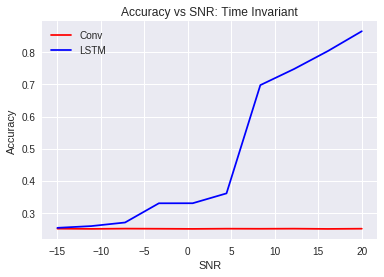

In [69]:
s_lstm = np.array(scores_lstm)
s_conv = np.array(scores_conv)
#LMS values taken from other notebook
s_lms = 1-np.array([0,0.06,3.49,20.42,42.74,57.27,66.08,71.97,74.61,74.54])*1.0/100
plt.plot(snrs,s_conv[:,1],"r",label="Conv")
plt.plot(snrs,s_lstm[:,1],"b",label="LSTM")
#plt.plot(snrs,s_lms,"y",label="LMS")
plt.legend()
plt.xlabel("SNR")
plt.ylabel("Accuracy")
plt.title("Accuracy vs SNR: Time Invariant")

from google.colab import files
plt.savefig('SNR_time_invariant.png')
files.download('SNR_time_invariant.png')

# Time-Varying Channel

In [0]:
def sim_channel_multi(m,sequenceLen,trials,Noise,SNRdB,h_list,channel_dur):
  """
  Simulates a channel
  Input:
    m - order of modulation
    sequenceLen - lenght of sequence
    trials - number trials
    Noise - Boolean, if noise should be added
    SNRdB - Ratio of signal to noise
    h_list- list of channel parameters for different channels
    channel_dur - duration of channel before switch
  """
  [x,y] = qammod2(m,sequenceLen,trials)
  distortedChannels = []
  for i in range(len(h_list)):
    distortedChannels.append(np.apply_along_axis(lambda q: np.convolve(q,h_list[i,:],mode="full"),axis = 1,arr = x))
   
  size = distortedChannels[0].shape[1]
  i = 0
  select = np.random.randint(len(h_list))
  selected_stream = distortedChannels[select]
  length = channel_dur
  if(i + length >= size):
    length = size - i
  xh = selected_stream[:,i:i+length,:]
  i = i + length
  while(i < size):
    select = np.random.randint(len(h_list))
    selected_stream = distortedChannels[select]
    length = channel_dur
    if(i + length >= size):
      length = size - i
    chunk = selected_stream[:,i:i+length,:]
    xh = np.concatenate((xh, chunk),axis = 1)
    i = i + length
  
  ## this added for phase offset 7/3/18
  Ts = 1/(2.5e6);
  fc = 2e6;
  CP = np.exp(np.arange(0,len(xh))*2*1j*math.pi*Ts*fc)
  CP = CP[:,np.newaxis]
  CP = np.transpose(CP,(1,0))
  xh = np.transpose(xh,(2,1,0))
  display(xh.shape)
  display(CP.shape)
  xh =  xh*CP
  xh = np.transpose(xh,(2,1,0))
  display(xh.shape)  
  ## edit ends 
  if(Noise):
    SNR = 10**(SNRdB/10)
    sym_noise_pow = np.var(xh)/SNR
    sym_noise_scale_fact = np.sqrt(sym_noise_pow/2)
    AWGN = sym_noise_scale_fact*np.random.normal(1, size=xh.shape) 
    xh = xh + AWGN
  return [xh ,y ]


def generateData_multi(m,sequenceLen,trials,Noise,SNRdB,h_list,channel_dur,padding=True,window=False,window_size = 10):
  """
  h_list = List of channel parameters 
  """
  data={}
  x_train,y_train = sim_channel_multi(m=m,sequenceLen=sequenceLen,trials=trials,Noise=Noise,SNRdB=SNRdB,h_list=h_list,channel_dur=channel_dur)
  x_val,y_val= sim_channel_multi(m=m,sequenceLen=sequenceLen,trials=int(trials*0.5),Noise= Noise,SNRdB=SNRdB,h_list=h_list,channel_dur=channel_dur)
  x_test,y_test= sim_channel_multi(m=m,sequenceLen=sequenceLen,trials=trials,Noise=Noise,SNRdB=SNRdB,h_list=h_list,channel_dur=channel_dur)
  
  print("x_train shape: ",x_train.shape) # data, expected seqlen+chanelLen-1
  print("y_train shape: ",y_train.shape) # labels
  
  #One hot encoding
  y_train = keras.utils.to_categorical(y_train , num_classes=m)
  y_val = keras.utils.to_categorical(y_val , num_classes=m)
  y_test = keras.utils.to_categorical(y_test , num_classes=m)
  print("y_train shape, one-hot: ",y_train.shape)

  #Padding 
  if(padding):
    y_train = np.pad(y_train,((0,0),(0,chanelLen-1),(0,0)),"constant")
    y_val = np.pad(y_val,((0,0),(0,chanelLen-1),(0,0)),"constant")
    y_test = np.pad(y_test,((0,0),(0,chanelLen-1),(0,0)),"constant")
    print("y_train shape, one-hot, padding: ",y_train.shape)
  
  #Windowing
  if(window):
    x_train = windowing(x_train,window_size)
    x_val = windowing(x_val,window_size)
    x_test = windowing(x_test,window_size)
    print("x_train shape, window: ",x_train.shape)
    
  default_data = {
    'x_train': x_train,
    'x_val': x_val,
    'x_test': x_test,
    'y_train': y_train,
    'y_val': y_val,
    'y_test': y_test,
  }
  return default_data
 
def windowing(x,window_size):
  """
  x - input data of dimension (trials,timestep,features)
  Will pad windows with zero 
  """
  trials, timestep, features = x.shape
  out = np.empty((trials,timestep,window_size*features))
  xpad = np.pad(x,((0,0),(0,window_size+1),(0,0)),"constant")
  for i in range(timestep):
    out[:,i] = np.reshape(xpad[:,i:i+window_size],(trials,window_size*features))
  return out

In [6]:
# Instantiating Data

m = 4         # order of modulation
trials = 10000 # number of trials 
Noise = True
SNRdB = 5
seqLen = 300
print(seqLen)
h_list = []
h_list.append(np.array([1,0.5,-0.3]))
h_list.append(np.array([1,-.5,-0.5]))
h_list.append(np.array([1,-0.25,-0.25]))
h_list = np.array(h_list)
chanelLen = len(h_list[0])
#chanelLen = 5
# h_list = np.random.rand(3,chanelLen)
# h_list[:,0] = 1
channel_dur = 75
print(h_list)

300
[[ 1.    0.5  -0.3 ]
 [ 1.   -0.5  -0.5 ]
 [ 1.   -0.25 -0.25]]


Defining models below

In [0]:
# QAM-4
from keras.models import Sequential
from keras import regularizers
from keras.layers import Dense,CuDNNLSTM, TimeDistributed,Bidirectional,BatchNormalization,Dropout,Conv1D, Flatten, Reshape,Softmax
from keras import optimizers
import keras

#LSTM no windwod
def LSTM_variant_no_window():
  data = generateData_multi(m,seqLen,trials,Noise,SNRdB,h_list,channel_dur,padding=True)
  modLSTM = Sequential()
  modLSTM.add(CuDNNLSTM(50,return_sequences=True,input_shape=(seqLen+chanelLen-1,2)))
  modLSTM.add(CuDNNLSTM(50,return_sequences=True))
  modLSTM.add(CuDNNLSTM(50,return_sequences=True))
  modLSTM.add(TimeDistributed(BatchNormalization()))
  modLSTM.add(TimeDistributed(Dense(m,activation="softmax")))
  
  #Training
  epochs = 40
  verbose = True
  reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy_with_masking', factor=0.2,
                              patience=7,verbose=verbose)

  opt = optimizers.Nadam()
  modLSTM.compile(optimizer= opt,
            loss=categorical_crossentropy_with_masking,
            metrics=[accuracy_with_masking])

  modLSTM.summary()  
  history = modLSTM.fit(data['x_train'], data['y_train'], 
            epochs=epochs, batch_size=int(0.1*trials), verbose=verbose, 
            validation_data=(data['x_val'], data['y_val']),
                     callbacks=[reduce_lr])  
  score = modLSTM.evaluate(data['x_test'], data['y_test'],batch_size = 1000)
  return history,score

#hist1, score1 = LSTM_variant_no_window() 


def LSTM_variant_with_window():
  window_size = chanelLen+2
  data = generateData_multi(m,seqLen,trials,Noise,SNRdB,h_list,channel_dur,padding=True,window=True,window_size=window_size)
  modLSTM = Sequential()
  modLSTM.add(CuDNNLSTM(50,return_sequences=True,input_shape=(seqLen+chanelLen-1,window_size*2),
                        recurrent_regularizer =regularizers.l1(0.0001),kernel_regularizer = regularizers.l2(0.001)))
  modLSTM.add(CuDNNLSTM(50,return_sequences=True,input_shape=(seqLen+chanelLen-1,window_size*2),
                        recurrent_regularizer =regularizers.l1(0.0001),kernel_regularizer = regularizers.l2(0.001)))
  modLSTM.add(CuDNNLSTM(50,return_sequences=True,input_shape=(seqLen+chanelLen-1,window_size*2),
                        recurrent_regularizer =regularizers.l1(0.0001),kernel_regularizer = regularizers.l2(0.001)))

      
  modLSTM.add(TimeDistributed(Dense(m,activation="softmax")))
  #Training
  epochs = 40
  verbose = True
  reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy_with_masking', factor=0.2,
                              patience=7,verbose=verbose)
  
  opt = optimizers.Nadam()
  modLSTM.compile(optimizer= opt,
            loss=categorical_crossentropy_with_masking,
            metrics=[accuracy_with_masking])

  modLSTM.summary()  
  history = modLSTM.fit(data['x_train'], data['y_train'], 
            epochs=epochs, batch_size=int(0.1*trials), verbose=verbose, 
            validation_data=(data['x_val'], data['y_val']),
                     callbacks=[reduce_lr])  
  score = modLSTM.evaluate(data['x_test'], data['y_test'],batch_size = 1000)
  return history,score

#hist2, score2 = LSTM_variant_with_window()  

def ConvNet_variant():
  data = generateData_multi(m,seqLen,trials,Noise,SNRdB,h_list,channel_dur,padding=False)
  modCNN = Sequential()
  modCNN.add(Conv1D(10,kernel_size=(chanelLen), input_shape=(seqLen+chanelLen-1,2) ))
  modCNN.add(BatchNormalization())
  modCNN.add(Flatten())
  modCNN.add(Dense(seqLen*m,bias_regularizer=regularizers.l2(0.005)))
  modCNN.add(Reshape(target_shape = (seqLen,m)))
  modCNN.add(Softmax(axis=2))
  return try_model_conv(modCNN, data, epochs=40)

#hist3, score3 = ConvNet_variant()  
# print("Conv: ", score3)
# print("No Window: ", score1)
# print("With Window: ", score2)

## Comparing Symbol Error rate for LSTM no window , LSTM+Window, and CNN

In [9]:
snrs = np.linspace(20,20,1)
snrs

array([20.])

In [30]:
m = 4         # order of modulation
trials = 20000   # number of trials 
Noise = True
seqLen = 300
print(seqLen)
h_list = []
h_list.append(np.array([1,0.5,-0.3]))
h_list.append(np.array([1,-.5,-0.5]))
h_list.append(np.array([1,-0.25,-0.25]))
# h_list.append(np.array([1,0.5,-0.3,.2,.1]))
# h_list.append(np.array([1,-.5,-0.5,.4,.1]))
# h_list.append(np.array([1,-0.25,-0.25,-.1, 0.7]))
h_list = np.array(h_list)
chanelLen = len(h_list[0])
channel_dur = 75
print("Channel: ",h_list)

snrs = np.linspace(20,20,1)
histories_lstm2 = []
scores_lstm2 = []
histories_lstm2_W = []
scores_lstm2_W = []
histories_conv2 = []
scores_conv2 = []
for SNRdB in snrs:
  print("SNRdB: ",SNRdB)

  #LSTM no window
  hist,score = LSTM_variant_no_window()
  histories_lstm2.append(hist)
  scores_lstm2.append(score)
  print("Score: ",score)
  #LSTM with window
  hist,score = LSTM_variant_with_window()
  histories_lstm2_W.append(hist)
  scores_lstm2_W.append(score)
  print("Score: ",score)

300
Channel:  [[ 1.    0.5  -0.3 ]
 [ 1.   -0.5  -0.5 ]
 [ 1.   -0.25 -0.25]]
SNRdB:  20.0


(2, 302, 20000)

(1, 20000)

(20000, 302, 2)

(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

(2, 302, 20000)

(1, 20000)

(20000, 302, 2)

x_train shape:  (20000, 302, 2)
y_train shape:  (20000, 300)
y_train shape, one-hot:  (20000, 300, 4)
y_train shape, one-hot, padding:  (20000, 302, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_28 (CuDNNLSTM)    (None, 302, 50)           10800     
_________________________________________________________________
cu_dnnlstm_29 (CuDNNLSTM)    (None, 302, 50)           20400     
_________________________________________________________________
cu_dnnlstm_30 (CuDNNLSTM)    (None, 302, 50)           20400     
_________________________________________________________________
time_distributed_16 (TimeDis (None, 302, 50)           200       
_________________________________________________________________
time_distributed_17 (TimeDis (None, 302, 4)            204       
Total params: 52,004
Trainable params: 51,904
Non-trainable params: 100
__________________________________________________

/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


20000/20000 [==============================] - 10s 511us/step - loss: 1.3465 - accuracy_with_masking: 0.3658 - val_loss: 1.6864 - val_accuracy_with_masking: 0.3271
Epoch 2/5
20000/20000 [==============================] - 7s 340us/step - loss: 1.1053 - accuracy_with_masking: 0.5866 - val_loss: 1.9388 - val_accuracy_with_masking: 0.3327
Epoch 3/5
14000/20000 [====================>.........] - ETA: 1s - loss: 0.3923 - accuracy_with_masking: 0.9279

KeyboardInterrupt: ignored

In [17]:
snrs = np.linspace(20,0,10)
snrs

array([20.        , 17.77777778, 15.55555556, 13.33333333, 11.11111111,
        8.88888889,  6.66666667,  4.44444444,  2.22222222,  0.        ])

In [40]:
m = 4         # order of modulation
trials = 20000   # number of trials 
Noise = True
seqLen = 300
print(seqLen)
h_list = []
h_list.append(np.array([1,0.5,-0.3]))
h_list.append(np.array([1,-.5,-0.5]))
h_list.append(np.array([1,-0.25,-0.25]))
# h_list.append(np.array([1,0.5,-0.3,.2,.1]))
# h_list.append(np.array([1,-.5,-0.5,.4,.1]))
# h_list.append(np.array([1,-0.25,-0.25,-.1, 0.7]))
h_list = np.array(h_list)
chanelLen = len(h_list[0])
channel_dur = 75
print("Channel: ",h_list)

snrs = np.linspace(20,0,5)
histories_lstm2 = []
scores_lstm2 = []
histories_lstm2_W = []
scores_lstm2_W = []
histories_conv2 = []
scores_conv2 = []
for SNRdB in snrs:
  print("SNRdB: ",SNRdB)

  #LSTM no window
  hist,score = LSTM_variant_no_window()
  histories_lstm2.append(hist)
  scores_lstm2.append(score)
  print("Score: ",score)
  #LSTM with window
  hist,score = LSTM_variant_with_window()
  histories_lstm2_W.append(hist)
  scores_lstm2_W.append(score)
  print("Score: ",score)
  #CNN
  hist,score = ConvNet_variant()
  histories_conv2.append(hist)
  scores_conv2.append(score)
  print("Score: ",score)

300
Channel:  [[ 1.    0.5  -0.3 ]
 [ 1.   -0.5  -0.5 ]
 [ 1.   -0.25 -0.25]]
SNRdB:  20.0


(2, 302, 20000)

(1, 20000)

(20000, 302, 2)

(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

(2, 302, 20000)

(1, 20000)

(20000, 302, 2)

x_train shape:  (20000, 302, 2)
y_train shape:  (20000, 300)
y_train shape, one-hot:  (20000, 300, 4)
y_train shape, one-hot, padding:  (20000, 302, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_49 (CuDNNLSTM)    (None, 302, 50)           10800     
_________________________________________________________________
cu_dnnlstm_50 (CuDNNLSTM)    (None, 302, 50)           20400     
_________________________________________________________________
cu_dnnlstm_51 (CuDNNLSTM)    (None, 302, 50)           20400     
_________________________________________________________________
time_distributed_29 (TimeDis (None, 302, 50)           200       
_________________________________________________________________
time_distributed_30 (TimeDis (None, 302, 4)            204       
Total params: 52,004
Trainable params: 51,904
Non-trainable params: 100
__________________________________________________

/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


20000/20000 [==============================] - 13s 628us/step - loss: 1.3976 - accuracy_with_masking: 0.2532 - val_loss: 1.4053 - val_accuracy_with_masking: 0.2497
Epoch 2/40
20000/20000 [==============================] - 7s 339us/step - loss: 1.3852 - accuracy_with_masking: 0.2711 - val_loss: 1.3929 - val_accuracy_with_masking: 0.2508
Epoch 3/40
20000/20000 [==============================] - 7s 337us/step - loss: 1.3823 - accuracy_with_masking: 0.2770 - val_loss: 1.4204 - val_accuracy_with_masking: 0.2496
Epoch 4/40
20000/20000 [==============================] - 7s 339us/step - loss: 1.3769 - accuracy_with_masking: 0.2930 - val_loss: 1.4898 - val_accuracy_with_masking: 0.2800
Epoch 5/40
20000/20000 [==============================] - 7s 338us/step - loss: 1.3665 - accuracy_with_masking: 0.2981 - val_loss: 1.5714 - val_accuracy_with_masking: 0.2522
Epoch 6/40
20000/20000 [==============================] - 7s 340us/step - loss: 1.2948 - accuracy_with_masking: 0.3624 - val_loss: 3.4547 - 

20000/20000 [==============================] - 7s 352us/step - loss: 0.8405 - accuracy_with_masking: 0.4904 - val_loss: 1.1067 - val_accuracy_with_masking: 0.4077
Epoch 12/40
20000/20000 [==============================] - 7s 344us/step - loss: 0.8236 - accuracy_with_masking: 0.4841 - val_loss: 1.0947 - val_accuracy_with_masking: 0.4113
Epoch 13/40
20000/20000 [==============================] - 7s 342us/step - loss: 0.8157 - accuracy_with_masking: 0.4836 - val_loss: 1.6886 - val_accuracy_with_masking: 0.3804
Epoch 14/40
20000/20000 [==============================] - 7s 339us/step - loss: 0.8014 - accuracy_with_masking: 0.5170 - val_loss: 1.1661 - val_accuracy_with_masking: 0.4113
Epoch 15/40
20000/20000 [==============================] - 7s 341us/step - loss: 0.7903 - accuracy_with_masking: 0.5375 - val_loss: 1.2028 - val_accuracy_with_masking: 0.4118
Epoch 16/40
20000/20000 [==============================] - 7s 338us/step - loss: 0.7839 - accuracy_with_masking: 0.5353 - val_loss: 1.112

20000/20000 [==============================] - 7s 335us/step - loss: 0.7786 - accuracy_with_masking: 0.6094 - val_loss: 0.8571 - val_accuracy_with_masking: 0.4778
Epoch 22/40
20000/20000 [==============================] - 7s 338us/step - loss: 0.7632 - accuracy_with_masking: 0.5876 - val_loss: 0.8905 - val_accuracy_with_masking: 0.4737
Epoch 23/40
20000/20000 [==============================] - 7s 336us/step - loss: 0.7497 - accuracy_with_masking: 0.5917 - val_loss: 1.2193 - val_accuracy_with_masking: 0.4145
Epoch 24/40
20000/20000 [==============================] - 7s 336us/step - loss: 0.7525 - accuracy_with_masking: 0.5965 - val_loss: 0.7802 - val_accuracy_with_masking: 0.5867
Epoch 25/40
20000/20000 [==============================] - 7s 337us/step - loss: 0.7670 - accuracy_with_masking: 0.5436 - val_loss: 1.6975 - val_accuracy_with_masking: 0.4036
Epoch 26/40
20000/20000 [==============================] - 7s 339us/step - loss: 0.7377 - accuracy_with_masking: 0.6077 - val_loss: 0.783

20000/20000 [==============================] - 7s 340us/step - loss: 0.8809 - accuracy_with_masking: 0.6559 - val_loss: 0.7382 - val_accuracy_with_masking: 0.6731
Epoch 32/40
20000/20000 [==============================] - 7s 336us/step - loss: 0.5071 - accuracy_with_masking: 0.7861 - val_loss: 0.9177 - val_accuracy_with_masking: 0.6318
Epoch 33/40
20000/20000 [==============================] - 7s 342us/step - loss: 0.4640 - accuracy_with_masking: 0.7878 - val_loss: 0.7538 - val_accuracy_with_masking: 0.6813
Epoch 34/40
20000/20000 [==============================] - 7s 341us/step - loss: 0.3810 - accuracy_with_masking: 0.8362 - val_loss: 0.6567 - val_accuracy_with_masking: 0.7081
Epoch 35/40
20000/20000 [==============================] - 7s 336us/step - loss: 0.3933 - accuracy_with_masking: 0.8435 - val_loss: 0.5599 - val_accuracy_with_masking: 0.7541
Epoch 36/40
20000/20000 [==============================] - 7s 337us/step - loss: 0.2943 - accuracy_with_masking: 0.8816 - val_loss: 0.510

20000/20000 [==============================] - 2s 123us/step
Score:  [0.2735686257481575, 0.9028464972972869]


(2, 302, 20000)

(1, 20000)

(20000, 302, 2)

(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

(2, 302, 20000)

(1, 20000)

(20000, 302, 2)

x_train shape:  (20000, 302, 2)
y_train shape:  (20000, 300)
y_train shape, one-hot:  (20000, 300, 4)
y_train shape, one-hot, padding:  (20000, 302, 4)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:110: ComplexWarning: Casting complex values to real discards the imaginary part


x_train shape, window:  (20000, 302, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_52 (CuDNNLSTM)    (None, 302, 50)           12400     
_________________________________________________________________
cu_dnnlstm_53 (CuDNNLSTM)    (None, 302, 50)           20400     
_________________________________________________________________
cu_dnnlstm_54 (CuDNNLSTM)    (None, 302, 50)           20400     
_________________________________________________________________
time_distributed_31 (TimeDis (None, 302, 4)            204       
Total params: 53,404
Trainable params: 53,404
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 10000 samples
Epoch 1/40
20000/20000 [==============================] - 11s 559us/step - loss: 1.6832 - accuracy_with_masking: 0.2474 - val_loss: 1.6320 - val_accuracy_with_masking: 0.2608
Epoc

Epoch 7/40
20000/20000 [==============================] - 7s 329us/step - loss: 1.4030 - accuracy_with_masking: 0.2800 - val_loss: 1.4021 - val_accuracy_with_masking: 0.2586
Epoch 8/40
20000/20000 [==============================] - 7s 325us/step - loss: 1.3935 - accuracy_with_masking: 0.2847 - val_loss: 1.3819 - val_accuracy_with_masking: 0.2885
Epoch 9/40
20000/20000 [==============================] - 7s 335us/step - loss: 1.3817 - accuracy_with_masking: 0.2964 - val_loss: 1.3695 - val_accuracy_with_masking: 0.3061
Epoch 10/40
20000/20000 [==============================] - 7s 328us/step - loss: 1.3659 - accuracy_with_masking: 0.3061 - val_loss: 1.3551 - val_accuracy_with_masking: 0.3245
Epoch 11/40
20000/20000 [==============================] - 7s 345us/step - loss: 1.3451 - accuracy_with_masking: 0.3256 - val_loss: 1.3423 - val_accuracy_with_masking: 0.3323
Epoch 12/40
20000/20000 [==============================] - 7s 358us/step - loss: 1.3349 - accuracy_with_masking: 0.3269 - val_lo

Epoch 17/40
20000/20000 [==============================] - 7s 330us/step - loss: 1.2421 - accuracy_with_masking: 0.3838 - val_loss: 1.2466 - val_accuracy_with_masking: 0.3879
Epoch 18/40
20000/20000 [==============================] - 6s 324us/step - loss: 1.2026 - accuracy_with_masking: 0.4012 - val_loss: 1.2216 - val_accuracy_with_masking: 0.3905
Epoch 19/40
20000/20000 [==============================] - 7s 333us/step - loss: 1.1639 - accuracy_with_masking: 0.4184 - val_loss: 1.2027 - val_accuracy_with_masking: 0.4079
Epoch 20/40
20000/20000 [==============================] - 7s 330us/step - loss: 1.1236 - accuracy_with_masking: 0.4339 - val_loss: 1.1780 - val_accuracy_with_masking: 0.4156
Epoch 21/40
20000/20000 [==============================] - 7s 326us/step - loss: 1.0917 - accuracy_with_masking: 0.4360 - val_loss: 1.1557 - val_accuracy_with_masking: 0.4247
Epoch 22/40
20000/20000 [==============================] - 6s 325us/step - loss: 1.0505 - accuracy_with_masking: 0.4524 - val

Epoch 27/40
20000/20000 [==============================] - 7s 331us/step - loss: 0.8325 - accuracy_with_masking: 0.5345 - val_loss: 1.0725 - val_accuracy_with_masking: 0.4830
Epoch 28/40
20000/20000 [==============================] - 7s 336us/step - loss: 0.8172 - accuracy_with_masking: 0.5407 - val_loss: 1.0777 - val_accuracy_with_masking: 0.4859
Epoch 29/40
20000/20000 [==============================] - 7s 337us/step - loss: 0.8095 - accuracy_with_masking: 0.5436 - val_loss: 1.0786 - val_accuracy_with_masking: 0.4922
Epoch 30/40
20000/20000 [==============================] - 7s 333us/step - loss: 0.8029 - accuracy_with_masking: 0.5482 - val_loss: 1.0848 - val_accuracy_with_masking: 0.4847
Epoch 31/40
20000/20000 [==============================] - 7s 338us/step - loss: 0.7976 - accuracy_with_masking: 0.5433 - val_loss: 1.0804 - val_accuracy_with_masking: 0.5004
Epoch 32/40
20000/20000 [==============================] - 7s 335us/step - loss: 0.7892 - accuracy_with_masking: 0.5532 - val

Epoch 37/40
20000/20000 [==============================] - 7s 357us/step - loss: 0.7666 - accuracy_with_masking: 0.5948 - val_loss: 1.0238 - val_accuracy_with_masking: 0.5483
Epoch 38/40
20000/20000 [==============================] - 7s 347us/step - loss: 0.7358 - accuracy_with_masking: 0.6188 - val_loss: 1.0097 - val_accuracy_with_masking: 0.5668
Epoch 39/40
20000/20000 [==============================] - 7s 349us/step - loss: 0.7197 - accuracy_with_masking: 0.6451 - val_loss: 0.9999 - val_accuracy_with_masking: 0.5568
Epoch 40/40
20000/20000 [==============================] - 3s 138us/step
Score:  [0.9797601014375686, 0.5727198392152786]


(2, 302, 20000)

(1, 20000)

(20000, 302, 2)

(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

(2, 302, 20000)

(1, 20000)

(20000, 302, 2)

x_train shape:  (20000, 302, 2)
y_train shape:  (20000, 300)
y_train shape, one-hot:  (20000, 300, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 300, 10)           70        
_________________________________________________________________
batch_normalization_16 (Batc (None, 300, 10)           40        
_________________________________________________________________
flatten_3 (Flatten)          (None, 3000)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 1200)              3601200   
_________________________________________________________________
reshape_3 (Reshape)          (None, 300, 4)            0         
_________________________________________________________________
softmax_3 (Softmax)          (None, 300, 4)            0         
Total params: 3,601,310
Trainable params

20000/20000 [==============================] - 3s 135us/step - loss: 1.4834 - acc: 0.2648 - val_loss: 1.5031 - val_acc: 0.2523
Epoch 3/40
20000/20000 [==============================] - 3s 131us/step - loss: 1.4542 - acc: 0.2707 - val_loss: 1.4782 - val_acc: 0.2516
Epoch 4/40
20000/20000 [==============================] - 3s 132us/step - loss: 1.4286 - acc: 0.2770 - val_loss: 1.4570 - val_acc: 0.2499
Epoch 5/40
20000/20000 [==============================] - 3s 135us/step - loss: 1.4068 - acc: 0.2826 - val_loss: 1.4400 - val_acc: 0.2496
Epoch 6/40
20000/20000 [==============================] - 3s 133us/step - loss: 1.3887 - acc: 0.2920 - val_loss: 1.4272 - val_acc: 0.2500
Epoch 7/40
18500/20000 [==========================>...] - ETA: 0s - loss: 1.3738 - acc: 0.3040

20000/20000 [==============================] - 3s 158us/step - loss: 1.3748 - acc: 0.3024 - val_loss: 1.4198 - val_acc: 0.2498
Epoch 8/40
20000/20000 [==============================] - 3s 126us/step - loss: 1.3666 - acc: 0.3091 - val_loss: 1.4173 - val_acc: 0.2498
Epoch 9/40
20000/20000 [==============================] - 3s 125us/step - loss: 1.3624 - acc: 0.3143 - val_loss: 1.4173 - val_acc: 0.2498
Epoch 10/40
20000/20000 [==============================] - 3s 128us/step - loss: 1.3600 - acc: 0.3184 - val_loss: 1.4179 - val_acc: 0.2501
Epoch 11/40
20000/20000 [==============================] - 3s 134us/step - loss: 1.3585 - acc: 0.3200 - val_loss: 1.4187 - val_acc: 0.2502
Epoch 12/40
20000/20000 [==============================] - 3s 128us/step - loss: 1.3573 - acc: 0.3219 - val_loss: 1.4198 - val_acc: 0.2501
Epoch 13/40
 1750/20000 [=>............................] - ETA: 2s - loss: 1.3449 - acc: 0.3393

20000/20000 [==============================] - 3s 128us/step - loss: 1.3564 - acc: 0.3226 - val_loss: 1.4203 - val_acc: 0.2502
Epoch 14/40
20000/20000 [==============================] - 3s 130us/step - loss: 1.3557 - acc: 0.3231 - val_loss: 1.4206 - val_acc: 0.2500
Epoch 15/40
20000/20000 [==============================] - 3s 132us/step - loss: 1.3551 - acc: 0.3242 - val_loss: 1.4218 - val_acc: 0.2505
Epoch 16/40
20000/20000 [==============================] - 3s 138us/step - loss: 1.3546 - acc: 0.3250 - val_loss: 1.4209 - val_acc: 0.2504
Epoch 17/40
20000/20000 [==============================] - 3s 133us/step - loss: 1.3541 - acc: 0.3251 - val_loss: 1.4226 - val_acc: 0.2501
Epoch 18/40
18750/20000 [===========================>..] - ETA: 0s - loss: 1.3532 - acc: 0.3268

20000/20000 [==============================] - 3s 133us/step - loss: 1.3538 - acc: 0.3260 - val_loss: 1.4217 - val_acc: 0.2503
Epoch 19/40
20000/20000 [==============================] - 3s 175us/step - loss: 1.3534 - acc: 0.3262 - val_loss: 1.4226 - val_acc: 0.2502
Epoch 20/40
20000/20000 [==============================] - 3s 164us/step - loss: 1.3531 - acc: 0.3267 - val_loss: 1.4220 - val_acc: 0.2502
Epoch 21/40
20000/20000 [==============================] - 3s 148us/step - loss: 1.3529 - acc: 0.3271 - val_loss: 1.4223 - val_acc: 0.2501
Epoch 22/40
20000/20000 [==============================] - 3s 141us/step - loss: 1.3526 - acc: 0.3275 - val_loss: 1.4235 - val_acc: 0.2502
Epoch 23/40
15750/20000 [======================>.......] - ETA: 0s - loss: 1.3504 - acc: 0.3301

20000/20000 [==============================] - 3s 144us/step - loss: 1.3524 - acc: 0.3275 - val_loss: 1.4233 - val_acc: 0.2503
Epoch 24/40
20000/20000 [==============================] - 3s 138us/step - loss: 1.3522 - acc: 0.3280 - val_loss: 1.4226 - val_acc: 0.2502
Epoch 25/40
20000/20000 [==============================] - 3s 142us/step - loss: 1.3520 - acc: 0.3278 - val_loss: 1.4243 - val_acc: 0.2502
Epoch 26/40
20000/20000 [==============================] - 3s 174us/step - loss: 1.3519 - acc: 0.3280 - val_loss: 1.4243 - val_acc: 0.2501
Epoch 27/40
20000/20000 [==============================] - 3s 146us/step - loss: 1.3517 - acc: 0.3286 - val_loss: 1.4252 - val_acc: 0.2503
Epoch 28/40
17000/20000 [========================>.....] - ETA: 0s - loss: 1.3502 - acc: 0.3303

20000/20000 [==============================] - 3s 132us/step - loss: 1.3515 - acc: 0.3286 - val_loss: 1.4252 - val_acc: 0.2504
Epoch 29/40
20000/20000 [==============================] - 3s 130us/step - loss: 1.3514 - acc: 0.3288 - val_loss: 1.4264 - val_acc: 0.2503
Epoch 30/40
20000/20000 [==============================] - 3s 128us/step - loss: 1.3513 - acc: 0.3289 - val_loss: 1.4255 - val_acc: 0.2504
Epoch 31/40
20000/20000 [==============================] - 3s 127us/step - loss: 1.3512 - acc: 0.3293 - val_loss: 1.4248 - val_acc: 0.2503
Epoch 32/40
20000/20000 [==============================] - 3s 127us/step - loss: 1.3510 - acc: 0.3290 - val_loss: 1.4269 - val_acc: 0.2503
Epoch 33/40
20000/20000 [==============================] - 2s 121us/step - loss: 1.3509 - acc: 0.3296 - val_loss: 1.4261 - val_acc: 0.2503
Epoch 34/40
  250/20000 [..............................] - ETA: 2s - loss: 1.3481 - acc: 0.3325

20000/20000 [==============================] - 2s 116us/step - loss: 1.3508 - acc: 0.3294 - val_loss: 1.4267 - val_acc: 0.2504
Epoch 35/40
20000/20000 [==============================] - 2s 120us/step - loss: 1.3507 - acc: 0.3297 - val_loss: 1.4285 - val_acc: 0.2504
Epoch 36/40
20000/20000 [==============================] - 2s 115us/step - loss: 1.3506 - acc: 0.3299 - val_loss: 1.4265 - val_acc: 0.2503
Epoch 37/40
20000/20000 [==============================] - 2s 118us/step - loss: 1.3505 - acc: 0.3299 - val_loss: 1.4289 - val_acc: 0.2503
Epoch 38/40
20000/20000 [==============================] - 3s 140us/step - loss: 1.3504 - acc: 0.3299 - val_loss: 1.4278 - val_acc: 0.2502
Epoch 39/40
20000/20000 [==============================] - 3s 127us/step - loss: 1.3503 - acc: 0.3301 - val_loss: 1.4288 - val_acc: 0.2502
Epoch 40/40
 2500/20000 [==>...........................] - ETA: 1s - loss: 1.3423 - acc: 0.3397

20000/20000 [==============================] - 4s 223us/step
Test accuracy: [1.4230457130432128, 0.25005183374881745]
Score:  [1.4230457130432128, 0.25005183374881745]
SNRdB:  15.0


(2, 302, 20000)

(1, 20000)

(20000, 302, 2)

(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

(2, 302, 20000)

(1, 20000)

(20000, 302, 2)

x_train shape:  (20000, 302, 2)
y_train shape:  (20000, 300)
y_train shape, one-hot:  (20000, 300, 4)
y_train shape, one-hot, padding:  (20000, 302, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_55 (CuDNNLSTM)    (None, 302, 50)           10800     
_________________________________________________________________
cu_dnnlstm_56 (CuDNNLSTM)    (None, 302, 50)           20400     
_________________________________________________________________
cu_dnnlstm_57 (CuDNNLSTM)    (None, 302, 50)           20400     
_________________________________________________________________
time_distributed_32 (TimeDis (None, 302, 50)           200       
_________________________________________________________________
time_distributed_33 (TimeDis (None, 302, 4)            204       
Total params: 52,004
Trainable params: 51,904
Non-trainable params: 100
__________________________________________________

20000/20000 [==============================] - 7s 345us/step - loss: 1.0187 - accuracy_with_masking: 0.4287 - val_loss: 1.3343 - val_accuracy_with_masking: 0.3601
Epoch 7/40
20000/20000 [==============================] - 7s 350us/step - loss: 0.9503 - accuracy_with_masking: 0.4504 - val_loss: 1.9538 - val_accuracy_with_masking: 0.3302
Epoch 8/40
20000/20000 [==============================] - 7s 370us/step - loss: 0.9400 - accuracy_with_masking: 0.4520 - val_loss: 1.6305 - val_accuracy_with_masking: 0.3617
Epoch 9/40
20000/20000 [==============================] - 7s 346us/step - loss: 0.8972 - accuracy_with_masking: 0.4781 - val_loss: 1.7414 - val_accuracy_with_masking: 0.3657
Epoch 10/40
20000/20000 [==============================] - 7s 343us/step - loss: 0.8809 - accuracy_with_masking: 0.4668 - val_loss: 2.8440 - val_accuracy_with_masking: 0.3318
Epoch 11/40
20000/20000 [==============================] - 7s 347us/step - loss: 0.8864 - accuracy_with_masking: 0.4895 - val_loss: 2.2308 -

20000/20000 [==============================] - 7s 340us/step - loss: 0.8708 - accuracy_with_masking: 0.5137 - val_loss: 2.1057 - val_accuracy_with_masking: 0.3937
Epoch 17/40
20000/20000 [==============================] - 7s 340us/step - loss: 0.8584 - accuracy_with_masking: 0.5362 - val_loss: 2.0702 - val_accuracy_with_masking: 0.3610
Epoch 18/40
20000/20000 [==============================] - 7s 339us/step - loss: 0.8467 - accuracy_with_masking: 0.5471 - val_loss: 2.0870 - val_accuracy_with_masking: 0.3767
Epoch 19/40
20000/20000 [==============================] - 7s 343us/step - loss: 0.8476 - accuracy_with_masking: 0.5314 - val_loss: 2.2783 - val_accuracy_with_masking: 0.3877
Epoch 20/40
20000/20000 [==============================] - 7s 345us/step - loss: 0.8472 - accuracy_with_masking: 0.5464 - val_loss: 2.1231 - val_accuracy_with_masking: 0.4032
Epoch 21/40
20000/20000 [==============================] - 7s 343us/step - loss: 0.8583 - accuracy_with_masking: 0.5211 - val_loss: 2.058

20000/20000 [==============================] - 7s 344us/step - loss: 0.8009 - accuracy_with_masking: 0.5994 - val_loss: 2.0050 - val_accuracy_with_masking: 0.4877
Epoch 27/40
20000/20000 [==============================] - 7s 346us/step - loss: 0.8073 - accuracy_with_masking: 0.6296 - val_loss: 2.0629 - val_accuracy_with_masking: 0.5259
Epoch 28/40
20000/20000 [==============================] - 7s 343us/step - loss: 0.7188 - accuracy_with_masking: 0.6640 - val_loss: 2.1657 - val_accuracy_with_masking: 0.5063
Epoch 29/40
20000/20000 [==============================] - 7s 343us/step - loss: 0.6316 - accuracy_with_masking: 0.7361 - val_loss: 2.0825 - val_accuracy_with_masking: 0.5498
Epoch 30/40
20000/20000 [==============================] - 7s 342us/step - loss: 0.5577 - accuracy_with_masking: 0.7706 - val_loss: 2.8903 - val_accuracy_with_masking: 0.4673
Epoch 31/40
20000/20000 [==============================] - 7s 351us/step - loss: 0.5517 - accuracy_with_masking: 0.7901 - val_loss: 2.244

20000/20000 [==============================] - 7s 340us/step - loss: 0.2169 - accuracy_with_masking: 0.9258 - val_loss: 3.1906 - val_accuracy_with_masking: 0.5425
Epoch 37/40
20000/20000 [==============================] - 7s 346us/step - loss: 0.2015 - accuracy_with_masking: 0.9250 - val_loss: 3.1802 - val_accuracy_with_masking: 0.5518
Epoch 38/40
20000/20000 [==============================] - 7s 341us/step - loss: 0.1770 - accuracy_with_masking: 0.9340 - val_loss: 3.2055 - val_accuracy_with_masking: 0.5546
Epoch 39/40
20000/20000 [==============================] - 7s 341us/step - loss: 0.1745 - accuracy_with_masking: 0.9341 - val_loss: 3.2503 - val_accuracy_with_masking: 0.5511
Epoch 40/40
20000/20000 [==============================] - 7s 340us/step - loss: 0.1713 - accuracy_with_masking: 0.9354 - val_loss: 3.2805 - val_accuracy_with_masking: 0.5480

Epoch 00040: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
20000/20000 [==============================] - 2s 124us/

(2, 302, 20000)

(1, 20000)

(20000, 302, 2)

(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

(2, 302, 20000)

(1, 20000)

(20000, 302, 2)

x_train shape:  (20000, 302, 2)
y_train shape:  (20000, 300)
y_train shape, one-hot:  (20000, 300, 4)
y_train shape, one-hot, padding:  (20000, 302, 4)
x_train shape, window:  (20000, 302, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_58 (CuDNNLSTM)    (None, 302, 50)           12400     
_________________________________________________________________
cu_dnnlstm_59 (CuDNNLSTM)    (None, 302, 50)           20400     
_________________________________________________________________
cu_dnnlstm_60 (CuDNNLSTM)    (None, 302, 50)           20400     
_________________________________________________________________
time_distributed_34 (TimeDis (None, 302, 4)            204       
Total params: 53,404
Trainable params: 53,404
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 10000 samples
Epoch 1/40
20000/20000 [===

20000/20000 [==============================] - 7s 336us/step - loss: 1.4172 - accuracy_with_masking: 0.2535 - val_loss: 1.4089 - val_accuracy_with_masking: 0.2525
Epoch 7/40
20000/20000 [==============================] - 7s 347us/step - loss: 1.4042 - accuracy_with_masking: 0.2512 - val_loss: 1.3993 - val_accuracy_with_masking: 0.2556
Epoch 8/40
20000/20000 [==============================] - 7s 332us/step - loss: 1.3967 - accuracy_with_masking: 0.2517 - val_loss: 1.3940 - val_accuracy_with_masking: 0.2507
Epoch 9/40
20000/20000 [==============================] - 7s 332us/step - loss: 1.3925 - accuracy_with_masking: 0.2501 - val_loss: 1.3911 - val_accuracy_with_masking: 0.2497

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
Epoch 10/40
20000/20000 [==============================] - 7s 354us/step - loss: 1.3899 - accuracy_with_masking: 0.2498 - val_loss: 1.3893 - val_accuracy_with_masking: 0.2469
Epoch 11/40
20000/20000 [==============================] - 

20000/20000 [==============================] - 7s 354us/step - loss: 1.3881 - accuracy_with_masking: 0.2498 - val_loss: 1.3880 - val_accuracy_with_masking: 0.2500
Epoch 16/40
20000/20000 [==============================] - 7s 359us/step - loss: 1.3879 - accuracy_with_masking: 0.2499 - val_loss: 1.3878 - val_accuracy_with_masking: 0.2500

Epoch 00016: ReduceLROnPlateau reducing learning rate to 8.000000379979611e-05.
Epoch 17/40
20000/20000 [==============================] - 7s 336us/step - loss: 1.3876 - accuracy_with_masking: 0.2501 - val_loss: 1.3875 - val_accuracy_with_masking: 0.2500
Epoch 18/40
20000/20000 [==============================] - 7s 332us/step - loss: 1.3875 - accuracy_with_masking: 0.2501 - val_loss: 1.3875 - val_accuracy_with_masking: 0.2500
Epoch 19/40
20000/20000 [==============================] - 7s 331us/step - loss: 1.3874 - accuracy_with_masking: 0.2502 - val_loss: 1.3874 - val_accuracy_with_masking: 0.2500
Epoch 20/40
20000/20000 [==============================]

20000/20000 [==============================] - 7s 340us/step - loss: 1.3873 - accuracy_with_masking: 0.2500 - val_loss: 1.3872 - val_accuracy_with_masking: 0.2503
Epoch 25/40
20000/20000 [==============================] - 7s 341us/step - loss: 1.3872 - accuracy_with_masking: 0.2497 - val_loss: 1.3872 - val_accuracy_with_masking: 0.2469
Epoch 26/40
20000/20000 [==============================] - 7s 339us/step - loss: 1.3872 - accuracy_with_masking: 0.2493 - val_loss: 1.3872 - val_accuracy_with_masking: 0.2500
Epoch 27/40
20000/20000 [==============================] - 7s 335us/step - loss: 1.3872 - accuracy_with_masking: 0.2499 - val_loss: 1.3872 - val_accuracy_with_masking: 0.2500
Epoch 28/40
20000/20000 [==============================] - 7s 341us/step - loss: 1.3872 - accuracy_with_masking: 0.2501 - val_loss: 1.3872 - val_accuracy_with_masking: 0.2500
Epoch 29/40
20000/20000 [==============================] - 7s 338us/step - loss: 1.3872 - accuracy_with_masking: 0.2501 - val_loss: 1.387

Epoch 34/40
20000/20000 [==============================] - 7s 337us/step - loss: 1.3872 - accuracy_with_masking: 0.2501 - val_loss: 1.3872 - val_accuracy_with_masking: 0.2500
Epoch 35/40
20000/20000 [==============================] - 7s 334us/step - loss: 1.3872 - accuracy_with_masking: 0.2501 - val_loss: 1.3872 - val_accuracy_with_masking: 0.2500
Epoch 36/40
20000/20000 [==============================] - 7s 332us/step - loss: 1.3872 - accuracy_with_masking: 0.2501 - val_loss: 1.3872 - val_accuracy_with_masking: 0.2500
Epoch 37/40
20000/20000 [==============================] - 7s 333us/step - loss: 1.3872 - accuracy_with_masking: 0.2501 - val_loss: 1.3872 - val_accuracy_with_masking: 0.2500

Epoch 00037: ReduceLROnPlateau reducing learning rate to 6.400000529538374e-07.
Epoch 38/40
20000/20000 [==============================] - 7s 332us/step - loss: 1.3872 - accuracy_with_masking: 0.2501 - val_loss: 1.3872 - val_accuracy_with_masking: 0.2500
Epoch 39/40
20000/20000 [===================

(2, 302, 20000)

(1, 20000)

(20000, 302, 2)

(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

(2, 302, 20000)

(1, 20000)

(20000, 302, 2)

x_train shape:  (20000, 302, 2)
y_train shape:  (20000, 300)
y_train shape, one-hot:  (20000, 300, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 300, 10)           70        
_________________________________________________________________
batch_normalization_18 (Batc (None, 300, 10)           40        
_________________________________________________________________
flatten_4 (Flatten)          (None, 3000)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 1200)              3601200   
_________________________________________________________________
reshape_4 (Reshape)          (None, 300, 4)            0         
_________________________________________________________________
softmax_4 (Softmax)          (None, 300, 4)            0         
Total params: 3,601,310
Trainable params

20000/20000 [==============================] - 3s 143us/step - loss: 1.4823 - acc: 0.2657 - val_loss: 1.4842 - val_acc: 0.2514
Epoch 3/40
20000/20000 [==============================] - 3s 134us/step - loss: 1.4535 - acc: 0.2717 - val_loss: 1.4635 - val_acc: 0.2504
Epoch 4/40
20000/20000 [==============================] - 3s 136us/step - loss: 1.4281 - acc: 0.2772 - val_loss: 1.4451 - val_acc: 0.2491
Epoch 5/40
20000/20000 [==============================] - 3s 129us/step - loss: 1.4046 - acc: 0.2825 - val_loss: 1.4293 - val_acc: 0.2504
Epoch 6/40
20000/20000 [==============================] - 3s 129us/step - loss: 1.3859 - acc: 0.2940 - val_loss: 1.4204 - val_acc: 0.2498
Epoch 7/40
18250/20000 [==========================>...] - ETA: 0s - loss: 1.3722 - acc: 0.3050

20000/20000 [==============================] - 3s 133us/step - loss: 1.3735 - acc: 0.3032 - val_loss: 1.4153 - val_acc: 0.2501
Epoch 8/40
20000/20000 [==============================] - 3s 133us/step - loss: 1.3661 - acc: 0.3110 - val_loss: 1.4133 - val_acc: 0.2500
Epoch 9/40
20000/20000 [==============================] - 3s 154us/step - loss: 1.3621 - acc: 0.3160 - val_loss: 1.4130 - val_acc: 0.2500
Epoch 10/40
20000/20000 [==============================] - 3s 165us/step - loss: 1.3598 - acc: 0.3187 - val_loss: 1.4139 - val_acc: 0.2498
Epoch 11/40
20000/20000 [==============================] - 3s 148us/step - loss: 1.3583 - acc: 0.3207 - val_loss: 1.4141 - val_acc: 0.2499
Epoch 12/40
15500/20000 [======================>.......] - ETA: 0s - loss: 1.3546 - acc: 0.3259

20000/20000 [==============================] - 3s 159us/step - loss: 1.3572 - acc: 0.3223 - val_loss: 1.4159 - val_acc: 0.2499
Epoch 13/40
20000/20000 [==============================] - 3s 144us/step - loss: 1.3563 - acc: 0.3234 - val_loss: 1.4176 - val_acc: 0.2502
Epoch 14/40
20000/20000 [==============================] - 3s 131us/step - loss: 1.3556 - acc: 0.3240 - val_loss: 1.4176 - val_acc: 0.2502
Epoch 15/40
20000/20000 [==============================] - 3s 133us/step - loss: 1.3551 - acc: 0.3252 - val_loss: 1.4171 - val_acc: 0.2500
Epoch 16/40
20000/20000 [==============================] - 3s 131us/step - loss: 1.3546 - acc: 0.3257 - val_loss: 1.4177 - val_acc: 0.2500
Epoch 17/40
18750/20000 [===========================>..] - ETA: 0s - loss: 1.3536 - acc: 0.3268

20000/20000 [==============================] - 3s 150us/step - loss: 1.3542 - acc: 0.3259 - val_loss: 1.4184 - val_acc: 0.2500
Epoch 18/40
20000/20000 [==============================] - 3s 154us/step - loss: 1.3537 - acc: 0.3268 - val_loss: 1.4181 - val_acc: 0.2500
Epoch 19/40
20000/20000 [==============================] - 3s 156us/step - loss: 1.3534 - acc: 0.3272 - val_loss: 1.4187 - val_acc: 0.2500
Epoch 20/40
20000/20000 [==============================] - 3s 144us/step - loss: 1.3531 - acc: 0.3275 - val_loss: 1.4198 - val_acc: 0.2502
Epoch 21/40
20000/20000 [==============================] - 3s 139us/step - loss: 1.3529 - acc: 0.3278 - val_loss: 1.4242 - val_acc: 0.2504
Epoch 22/40
16750/20000 [========================>.....] - ETA: 0s - loss: 1.3511 - acc: 0.3298

20000/20000 [==============================] - 3s 133us/step - loss: 1.3526 - acc: 0.3278 - val_loss: 1.4194 - val_acc: 0.2499
Epoch 23/40
20000/20000 [==============================] - 3s 129us/step - loss: 1.3524 - acc: 0.3284 - val_loss: 1.4215 - val_acc: 0.2502
Epoch 24/40
20000/20000 [==============================] - 3s 127us/step - loss: 1.3522 - acc: 0.3287 - val_loss: 1.4193 - val_acc: 0.2499
Epoch 25/40
20000/20000 [==============================] - 3s 126us/step - loss: 1.3520 - acc: 0.3286 - val_loss: 1.4192 - val_acc: 0.2500
Epoch 26/40
20000/20000 [==============================] - 2s 123us/step - loss: 1.3518 - acc: 0.3291 - val_loss: 1.4205 - val_acc: 0.2502
Epoch 27/40
20000/20000 [==============================] - 2s 124us/step - loss: 1.3517 - acc: 0.3293 - val_loss: 1.4206 - val_acc: 0.2502


Epoch 28/40
20000/20000 [==============================] - 2s 123us/step - loss: 1.3515 - acc: 0.3295 - val_loss: 1.4214 - val_acc: 0.2503
Epoch 29/40
20000/20000 [==============================] - 2s 122us/step - loss: 1.3514 - acc: 0.3296 - val_loss: 1.4214 - val_acc: 0.2502
Epoch 30/40
20000/20000 [==============================] - 2s 122us/step - loss: 1.3513 - acc: 0.3299 - val_loss: 1.4220 - val_acc: 0.2501
Epoch 31/40
20000/20000 [==============================] - 2s 119us/step - loss: 1.3511 - acc: 0.3304 - val_loss: 1.4226 - val_acc: 0.2505
Epoch 32/40
20000/20000 [==============================] - 2s 117us/step - loss: 1.3510 - acc: 0.3300 - val_loss: 1.4233 - val_acc: 0.2503
Epoch 33/40
20000/20000 [==============================] - 2s 120us/step - loss: 1.3509 - acc: 0.3306 - val_loss: 1.4245 - val_acc: 0.2503


Epoch 34/40
20000/20000 [==============================] - 2s 120us/step - loss: 1.3508 - acc: 0.3304 - val_loss: 1.4256 - val_acc: 0.2503
Epoch 35/40
20000/20000 [==============================] - 2s 121us/step - loss: 1.3507 - acc: 0.3301 - val_loss: 1.4241 - val_acc: 0.2502
Epoch 36/40
20000/20000 [==============================] - 2s 118us/step - loss: 1.3506 - acc: 0.3304 - val_loss: 1.4300 - val_acc: 0.2501
Epoch 37/40
20000/20000 [==============================] - 2s 120us/step - loss: 1.3505 - acc: 0.3304 - val_loss: 1.4241 - val_acc: 0.2502
Epoch 38/40
20000/20000 [==============================] - 2s 116us/step - loss: 1.3504 - acc: 0.3309 - val_loss: 1.4259 - val_acc: 0.2503
Epoch 39/40
20000/20000 [==============================] - 2s 118us/step - loss: 1.3503 - acc: 0.3308 - val_loss: 1.4262 - val_acc: 0.2502
Epoch 40/40
 2000/20000 [==>...........................] - ETA: 2s - loss: 1.3425 - acc: 0.3401

20000/20000 [==============================] - 3s 172us/step
Test accuracy: [1.428294091796875, 0.2501158330202103]
Score:  [1.428294091796875, 0.2501158330202103]
SNRdB:  10.0


(2, 302, 20000)

(1, 20000)

(20000, 302, 2)

(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

(2, 302, 20000)

(1, 20000)

(20000, 302, 2)

x_train shape:  (20000, 302, 2)
y_train shape:  (20000, 300)
y_train shape, one-hot:  (20000, 300, 4)
y_train shape, one-hot, padding:  (20000, 302, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_61 (CuDNNLSTM)    (None, 302, 50)           10800     
_________________________________________________________________
cu_dnnlstm_62 (CuDNNLSTM)    (None, 302, 50)           20400     
_________________________________________________________________
cu_dnnlstm_63 (CuDNNLSTM)    (None, 302, 50)           20400     
_________________________________________________________________
time_distributed_35 (TimeDis (None, 302, 50)           200       
_________________________________________________________________
time_distributed_36 (TimeDis (None, 302, 4)            204       
Total params: 52,004
Trainable params: 51,904
Non-trainable params: 100
__________________________________________________

20000/20000 [==============================] - 7s 345us/step - loss: 1.1892 - accuracy_with_masking: 0.3813 - val_loss: 2.9939 - val_accuracy_with_masking: 0.2774
Epoch 7/40
20000/20000 [==============================] - 7s 354us/step - loss: 1.0490 - accuracy_with_masking: 0.4157 - val_loss: 2.1223 - val_accuracy_with_masking: 0.3196
Epoch 8/40
20000/20000 [==============================] - 7s 349us/step - loss: 1.0020 - accuracy_with_masking: 0.4200 - val_loss: 1.3608 - val_accuracy_with_masking: 0.3675
Epoch 9/40
20000/20000 [==============================] - 7s 343us/step - loss: 0.9892 - accuracy_with_masking: 0.4223 - val_loss: 1.5223 - val_accuracy_with_masking: 0.3477
Epoch 10/40
20000/20000 [==============================] - 7s 340us/step - loss: 0.9849 - accuracy_with_masking: 0.4274 - val_loss: 1.4137 - val_accuracy_with_masking: 0.3550
Epoch 11/40
20000/20000 [==============================] - 7s 341us/step - loss: 0.9703 - accuracy_with_masking: 0.4354 - val_loss: 1.5365 -

20000/20000 [==============================] - 7s 343us/step - loss: 0.9627 - accuracy_with_masking: 0.4609 - val_loss: 1.4463 - val_accuracy_with_masking: 0.3654
Epoch 17/40
20000/20000 [==============================] - 7s 339us/step - loss: 0.9612 - accuracy_with_masking: 0.4634 - val_loss: 1.4484 - val_accuracy_with_masking: 0.3700
Epoch 18/40
20000/20000 [==============================] - 7s 339us/step - loss: 0.9609 - accuracy_with_masking: 0.4675 - val_loss: 1.4497 - val_accuracy_with_masking: 0.3957
Epoch 19/40
20000/20000 [==============================] - 7s 342us/step - loss: 0.9607 - accuracy_with_masking: 0.4698 - val_loss: 1.4519 - val_accuracy_with_masking: 0.3950
Epoch 20/40
20000/20000 [==============================] - 7s 340us/step - loss: 0.9604 - accuracy_with_masking: 0.4696 - val_loss: 1.4528 - val_accuracy_with_masking: 0.3981
Epoch 21/40
20000/20000 [==============================] - 7s 342us/step - loss: 0.9602 - accuracy_with_masking: 0.4767 - val_loss: 1.454

20000/20000 [==============================] - 7s 346us/step - loss: 0.9587 - accuracy_with_masking: 0.4781 - val_loss: 1.4633 - val_accuracy_with_masking: 0.3973
Epoch 27/40
20000/20000 [==============================] - 7s 351us/step - loss: 0.9584 - accuracy_with_masking: 0.4848 - val_loss: 1.4658 - val_accuracy_with_masking: 0.3936

Epoch 00027: ReduceLROnPlateau reducing learning rate to 8.000000379979611e-05.
Epoch 28/40
20000/20000 [==============================] - 7s 351us/step - loss: 0.9581 - accuracy_with_masking: 0.4826 - val_loss: 1.4650 - val_accuracy_with_masking: 0.3956
Epoch 29/40
20000/20000 [==============================] - 7s 344us/step - loss: 0.9580 - accuracy_with_masking: 0.4817 - val_loss: 1.4647 - val_accuracy_with_masking: 0.3971
Epoch 30/40
20000/20000 [==============================] - 7s 345us/step - loss: 0.9579 - accuracy_with_masking: 0.4856 - val_loss: 1.4645 - val_accuracy_with_masking: 0.3999
Epoch 31/40
20000/20000 [==============================]

20000/20000 [==============================] - 7s 345us/step - loss: 0.9574 - accuracy_with_masking: 0.4884 - val_loss: 1.4652 - val_accuracy_with_masking: 0.4035
Epoch 36/40
20000/20000 [==============================] - 7s 349us/step - loss: 0.9573 - accuracy_with_masking: 0.4914 - val_loss: 1.4655 - val_accuracy_with_masking: 0.4032
Epoch 37/40
20000/20000 [==============================] - 7s 344us/step - loss: 0.9572 - accuracy_with_masking: 0.4926 - val_loss: 1.4661 - val_accuracy_with_masking: 0.4033
Epoch 38/40
20000/20000 [==============================] - 7s 344us/step - loss: 0.9571 - accuracy_with_masking: 0.4940 - val_loss: 1.4666 - val_accuracy_with_masking: 0.4030
Epoch 39/40
20000/20000 [==============================] - 7s 344us/step - loss: 0.9569 - accuracy_with_masking: 0.4923 - val_loss: 1.4673 - val_accuracy_with_masking: 0.4043
Epoch 40/40
20000/20000 [==============================] - 3s 129us/step
Score:  [1.1803342282772065, 0.4402426674962044]


(2, 302, 20000)

(1, 20000)

(20000, 302, 2)

(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

(2, 302, 20000)

(1, 20000)

(20000, 302, 2)

x_train shape:  (20000, 302, 2)
y_train shape:  (20000, 300)
y_train shape, one-hot:  (20000, 300, 4)
y_train shape, one-hot, padding:  (20000, 302, 4)
x_train shape, window:  (20000, 302, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_64 (CuDNNLSTM)    (None, 302, 50)           12400     
_________________________________________________________________
cu_dnnlstm_65 (CuDNNLSTM)    (None, 302, 50)           20400     
_________________________________________________________________
cu_dnnlstm_66 (CuDNNLSTM)    (None, 302, 50)           20400     
_________________________________________________________________
time_distributed_37 (TimeDis (None, 302, 4)            204       
Total params: 53,404
Trainable params: 53,404
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 10000 samples
Epoch 1/40
20000/20000 [===

20000/20000 [==============================] - 7s 331us/step - loss: 1.4181 - accuracy_with_masking: 0.2510 - val_loss: 1.4097 - val_accuracy_with_masking: 0.2493
Epoch 7/40
20000/20000 [==============================] - 7s 333us/step - loss: 1.4049 - accuracy_with_masking: 0.2504 - val_loss: 1.4000 - val_accuracy_with_masking: 0.2504
Epoch 8/40
20000/20000 [==============================] - 7s 331us/step - loss: 1.3972 - accuracy_with_masking: 0.2497 - val_loss: 1.3944 - val_accuracy_with_masking: 0.2493

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
Epoch 9/40
20000/20000 [==============================] - 7s 343us/step - loss: 1.3930 - accuracy_with_masking: 0.2502 - val_loss: 1.3923 - val_accuracy_with_masking: 0.2493
Epoch 10/40
20000/20000 [==============================] - 7s 335us/step - loss: 1.3920 - accuracy_with_masking: 0.2499 - val_loss: 1.3916 - val_accuracy_with_masking: 0.2500
Epoch 11/40
20000/20000 [==============================] - 

20000/20000 [==============================] - 7s 344us/step - loss: 1.3894 - accuracy_with_masking: 0.2501 - val_loss: 1.3892 - val_accuracy_with_masking: 0.2503

Epoch 00015: ReduceLROnPlateau reducing learning rate to 8.000000379979611e-05.
Epoch 16/40
20000/20000 [==============================] - 7s 333us/step - loss: 1.3889 - accuracy_with_masking: 0.2499 - val_loss: 1.3888 - val_accuracy_with_masking: 0.2493
Epoch 17/40
20000/20000 [==============================] - 7s 334us/step - loss: 1.3888 - accuracy_with_masking: 0.2503 - val_loss: 1.3888 - val_accuracy_with_masking: 0.2493
Epoch 18/40
20000/20000 [==============================] - 7s 335us/step - loss: 1.3887 - accuracy_with_masking: 0.2503 - val_loss: 1.3887 - val_accuracy_with_masking: 0.2493
Epoch 19/40
20000/20000 [==============================] - 7s 336us/step - loss: 1.3887 - accuracy_with_masking: 0.2501 - val_loss: 1.3886 - val_accuracy_with_masking: 0.2493
Epoch 20/40
20000/20000 [==============================]

20000/20000 [==============================] - 7s 334us/step - loss: 1.3883 - accuracy_with_masking: 0.2503 - val_loss: 1.3883 - val_accuracy_with_masking: 0.2493
Epoch 25/40
20000/20000 [==============================] - 7s 335us/step - loss: 1.3883 - accuracy_with_masking: 0.2503 - val_loss: 1.3883 - val_accuracy_with_masking: 0.2493
Epoch 26/40
20000/20000 [==============================] - 7s 333us/step - loss: 1.3883 - accuracy_with_masking: 0.2503 - val_loss: 1.3883 - val_accuracy_with_masking: 0.2493
Epoch 27/40
20000/20000 [==============================] - 7s 329us/step - loss: 1.3883 - accuracy_with_masking: 0.2503 - val_loss: 1.3883 - val_accuracy_with_masking: 0.2493
Epoch 28/40
20000/20000 [==============================] - 7s 363us/step - loss: 1.3883 - accuracy_with_masking: 0.2503 - val_loss: 1.3883 - val_accuracy_with_masking: 0.2493
Epoch 29/40
20000/20000 [==============================] - 7s 363us/step - loss: 1.3883 - accuracy_with_masking: 0.2503 - val_loss: 1.388

20000/20000 [==============================] - 7s 329us/step - loss: 1.3882 - accuracy_with_masking: 0.2503 - val_loss: 1.3882 - val_accuracy_with_masking: 0.2493
Epoch 34/40
20000/20000 [==============================] - 7s 329us/step - loss: 1.3882 - accuracy_with_masking: 0.2503 - val_loss: 1.3882 - val_accuracy_with_masking: 0.2493
Epoch 35/40
20000/20000 [==============================] - 7s 335us/step - loss: 1.3882 - accuracy_with_masking: 0.2503 - val_loss: 1.3882 - val_accuracy_with_masking: 0.2493
Epoch 36/40
20000/20000 [==============================] - 7s 328us/step - loss: 1.3882 - accuracy_with_masking: 0.2503 - val_loss: 1.3882 - val_accuracy_with_masking: 0.2493

Epoch 00036: ReduceLROnPlateau reducing learning rate to 6.400000529538374e-07.
Epoch 37/40
20000/20000 [==============================] - 7s 326us/step - loss: 1.3882 - accuracy_with_masking: 0.2503 - val_loss: 1.3882 - val_accuracy_with_masking: 0.2493
Epoch 38/40
20000/20000 [==============================]

20000/20000 [==============================] - 3s 130us/step
Score:  [1.3882294595241547, 0.2501325011253357]


(2, 302, 20000)

(1, 20000)

(20000, 302, 2)

(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

(2, 302, 20000)

(1, 20000)

(20000, 302, 2)

x_train shape:  (20000, 302, 2)
y_train shape:  (20000, 300)
y_train shape, one-hot:  (20000, 300, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 300, 10)           70        
_________________________________________________________________
batch_normalization_20 (Batc (None, 300, 10)           40        
_________________________________________________________________
flatten_5 (Flatten)          (None, 3000)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 1200)              3601200   
_________________________________________________________________
reshape_5 (Reshape)          (None, 300, 4)            0         
_________________________________________________________________
softmax_5 (Softmax)          (None, 300, 4)            0         
Total params: 3,601,310
Trainable params

20000/20000 [==============================] - 3s 133us/step - loss: 1.4753 - acc: 0.2674 - val_loss: 1.4893 - val_acc: 0.2493
Epoch 3/40
20000/20000 [==============================] - 3s 141us/step - loss: 1.4436 - acc: 0.2734 - val_loss: 1.4673 - val_acc: 0.2502
Epoch 4/40
20000/20000 [==============================] - 3s 144us/step - loss: 1.4205 - acc: 0.2799 - val_loss: 1.4498 - val_acc: 0.2501
Epoch 5/40
20000/20000 [==============================] - 3s 132us/step - loss: 1.4007 - acc: 0.2879 - val_loss: 1.4353 - val_acc: 0.2498
Epoch 6/40
20000/20000 [==============================] - 3s 143us/step - loss: 1.3846 - acc: 0.2966 - val_loss: 1.4254 - val_acc: 0.2497
Epoch 7/40
18500/20000 [==========================>...] - ETA: 0s - loss: 1.3717 - acc: 0.3070

20000/20000 [==============================] - 3s 127us/step - loss: 1.3727 - acc: 0.3055 - val_loss: 1.4204 - val_acc: 0.2500
Epoch 8/40
20000/20000 [==============================] - 3s 127us/step - loss: 1.3654 - acc: 0.3133 - val_loss: 1.4175 - val_acc: 0.2500
Epoch 9/40
20000/20000 [==============================] - 3s 132us/step - loss: 1.3614 - acc: 0.3182 - val_loss: 1.4176 - val_acc: 0.2497
Epoch 10/40
20000/20000 [==============================] - 3s 126us/step - loss: 1.3591 - acc: 0.3208 - val_loss: 1.4217 - val_acc: 0.2501
Epoch 11/40
20000/20000 [==============================] - 3s 132us/step - loss: 1.3576 - acc: 0.3227 - val_loss: 1.4242 - val_acc: 0.2500
Epoch 12/40
19000/20000 [===========================>..] - ETA: 0s - loss: 1.3559 - acc: 0.3249

20000/20000 [==============================] - 3s 170us/step - loss: 1.3565 - acc: 0.3242 - val_loss: 1.4185 - val_acc: 0.2501
Epoch 13/40
20000/20000 [==============================] - 3s 167us/step - loss: 1.3557 - acc: 0.3257 - val_loss: 1.4198 - val_acc: 0.2499
Epoch 14/40
20000/20000 [==============================] - 3s 174us/step - loss: 1.3549 - acc: 0.3266 - val_loss: 1.4215 - val_acc: 0.2499
Epoch 15/40
20000/20000 [==============================] - 3s 156us/step - loss: 1.3543 - acc: 0.3274 - val_loss: 1.4213 - val_acc: 0.2500
Epoch 16/40
20000/20000 [==============================] - 3s 138us/step - loss: 1.3539 - acc: 0.3279 - val_loss: 1.4204 - val_acc: 0.2499
Epoch 17/40
14000/20000 [====================>.........] - ETA: 0s - loss: 1.3503 - acc: 0.3323

20000/20000 [==============================] - 3s 143us/step - loss: 1.3534 - acc: 0.3282 - val_loss: 1.4224 - val_acc: 0.2502
Epoch 18/40
20000/20000 [==============================] - 3s 128us/step - loss: 1.3531 - acc: 0.3288 - val_loss: 1.4202 - val_acc: 0.2498
Epoch 19/40
20000/20000 [==============================] - 3s 128us/step - loss: 1.3527 - acc: 0.3292 - val_loss: 1.4196 - val_acc: 0.2499
Epoch 20/40
20000/20000 [==============================] - 3s 135us/step - loss: 1.3525 - acc: 0.3296 - val_loss: 1.4227 - val_acc: 0.2499
Epoch 21/40
20000/20000 [==============================] - 3s 126us/step - loss: 1.3522 - acc: 0.3298 - val_loss: 1.4232 - val_acc: 0.2501
Epoch 22/40
19250/20000 [===========================>..] - ETA: 0s - loss: 1.3516 - acc: 0.3305

20000/20000 [==============================] - 3s 126us/step - loss: 1.3520 - acc: 0.3300 - val_loss: 1.4205 - val_acc: 0.2502
Epoch 23/40
20000/20000 [==============================] - 2s 123us/step - loss: 1.3518 - acc: 0.3303 - val_loss: 1.4232 - val_acc: 0.2500
Epoch 24/40
20000/20000 [==============================] - 3s 126us/step - loss: 1.3515 - acc: 0.3309 - val_loss: 1.4237 - val_acc: 0.2499
Epoch 25/40
20000/20000 [==============================] - 3s 130us/step - loss: 1.3514 - acc: 0.3308 - val_loss: 1.4229 - val_acc: 0.2501
Epoch 26/40
20000/20000 [==============================] - 2s 125us/step - loss: 1.3512 - acc: 0.3310 - val_loss: 1.4214 - val_acc: 0.2498
Epoch 27/40
20000/20000 [==============================] - 3s 126us/step - loss: 1.3510 - acc: 0.3311 - val_loss: 1.4231 - val_acc: 0.2499
Epoch 28/40
 2500/20000 [==>...........................] - ETA: 1s - loss: 1.3425 - acc: 0.3415

20000/20000 [==============================] - 3s 128us/step - loss: 1.3509 - acc: 0.3315 - val_loss: 1.4235 - val_acc: 0.2499
Epoch 29/40
20000/20000 [==============================] - 2s 123us/step - loss: 1.3508 - acc: 0.3315 - val_loss: 1.4274 - val_acc: 0.2500
Epoch 30/40
20000/20000 [==============================] - 2s 123us/step - loss: 1.3506 - acc: 0.3317 - val_loss: 1.4292 - val_acc: 0.2501
Epoch 31/40
20000/20000 [==============================] - 3s 129us/step - loss: 1.3505 - acc: 0.3321 - val_loss: 1.4250 - val_acc: 0.2499
Epoch 32/40
20000/20000 [==============================] - 2s 123us/step - loss: 1.3504 - acc: 0.3322 - val_loss: 1.4266 - val_acc: 0.2499
Epoch 33/40
20000/20000 [==============================] - 2s 125us/step - loss: 1.3503 - acc: 0.3320 - val_loss: 1.4247 - val_acc: 0.2498
Epoch 34/40
 3000/20000 [===>..........................] - ETA: 1s - loss: 1.3421 - acc: 0.3424

20000/20000 [==============================] - 3s 136us/step - loss: 1.3501 - acc: 0.3323 - val_loss: 1.4240 - val_acc: 0.2498
Epoch 35/40
20000/20000 [==============================] - 3s 140us/step - loss: 1.3501 - acc: 0.3323 - val_loss: 1.4272 - val_acc: 0.2498
Epoch 36/40
20000/20000 [==============================] - 3s 134us/step - loss: 1.3500 - acc: 0.3328 - val_loss: 1.4239 - val_acc: 0.2500
Epoch 37/40
20000/20000 [==============================] - 3s 128us/step - loss: 1.3499 - acc: 0.3326 - val_loss: 1.4285 - val_acc: 0.2498
Epoch 38/40
20000/20000 [==============================] - 2s 124us/step - loss: 1.3498 - acc: 0.3328 - val_loss: 1.4264 - val_acc: 0.2499
Epoch 39/40
17250/20000 [========================>.....] - ETA: 0s - loss: 1.3485 - acc: 0.3344

20000/20000 [==============================] - 3s 126us/step - loss: 1.3497 - acc: 0.3329 - val_loss: 1.4265 - val_acc: 0.2500
Epoch 40/40
20000/20000 [==============================] - 3s 169us/step
Test accuracy: [1.422286951828003, 0.25004183349609377]
Score:  [1.422286951828003, 0.25004183349609377]
SNRdB:  5.0


(2, 302, 20000)

(1, 20000)

(20000, 302, 2)

(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

(2, 302, 20000)

(1, 20000)

(20000, 302, 2)

x_train shape:  (20000, 302, 2)
y_train shape:  (20000, 300)
y_train shape, one-hot:  (20000, 300, 4)
y_train shape, one-hot, padding:  (20000, 302, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_67 (CuDNNLSTM)    (None, 302, 50)           10800     
_________________________________________________________________
cu_dnnlstm_68 (CuDNNLSTM)    (None, 302, 50)           20400     
_________________________________________________________________
cu_dnnlstm_69 (CuDNNLSTM)    (None, 302, 50)           20400     
_________________________________________________________________
time_distributed_38 (TimeDis (None, 302, 50)           200       
_________________________________________________________________
time_distributed_39 (TimeDis (None, 302, 4)            204       
Total params: 52,004
Trainable params: 51,904
Non-trainable params: 100
__________________________________________________

20000/20000 [==============================] - 7s 341us/step - loss: 1.3709 - accuracy_with_masking: 0.2866 - val_loss: 1.5614 - val_accuracy_with_masking: 0.2670
Epoch 7/40
20000/20000 [==============================] - 7s 341us/step - loss: 1.3468 - accuracy_with_masking: 0.3071 - val_loss: 1.9196 - val_accuracy_with_masking: 0.2578
Epoch 8/40
20000/20000 [==============================] - 7s 341us/step - loss: 1.2698 - accuracy_with_masking: 0.3380 - val_loss: 1.6740 - val_accuracy_with_masking: 0.2815
Epoch 9/40
20000/20000 [==============================] - 7s 340us/step - loss: 1.2311 - accuracy_with_masking: 0.3478 - val_loss: 1.1986 - val_accuracy_with_masking: 0.3701
Epoch 10/40
20000/20000 [==============================] - 7s 341us/step - loss: 1.2212 - accuracy_with_masking: 0.3489 - val_loss: 1.1881 - val_accuracy_with_masking: 0.3714
Epoch 11/40
20000/20000 [==============================] - 7s 348us/step - loss: 1.2243 - accuracy_with_masking: 0.3496 - val_loss: 1.2369 -

20000/20000 [==============================] - 7s 354us/step - loss: 1.2180 - accuracy_with_masking: 0.3549 - val_loss: 1.1830 - val_accuracy_with_masking: 0.3723
Epoch 17/40
20000/20000 [==============================] - 7s 349us/step - loss: 1.2124 - accuracy_with_masking: 0.3640 - val_loss: 1.1685 - val_accuracy_with_masking: 0.3764
Epoch 18/40
20000/20000 [==============================] - 7s 345us/step - loss: 1.2151 - accuracy_with_masking: 0.3633 - val_loss: 1.1691 - val_accuracy_with_masking: 0.3792
Epoch 19/40
20000/20000 [==============================] - 7s 343us/step - loss: 1.2095 - accuracy_with_masking: 0.3676 - val_loss: 1.1819 - val_accuracy_with_masking: 0.3725
Epoch 20/40
20000/20000 [==============================] - 7s 341us/step - loss: 1.2129 - accuracy_with_masking: 0.3668 - val_loss: 1.1637 - val_accuracy_with_masking: 0.3722
Epoch 21/40
20000/20000 [==============================] - 7s 356us/step - loss: 1.2080 - accuracy_with_masking: 0.3693 - val_loss: 1.176

20000/20000 [==============================] - 7s 345us/step - loss: 1.2035 - accuracy_with_masking: 0.3798 - val_loss: 1.1661 - val_accuracy_with_masking: 0.3823
Epoch 27/40
20000/20000 [==============================] - 7s 343us/step - loss: 1.2004 - accuracy_with_masking: 0.3918 - val_loss: 1.1655 - val_accuracy_with_masking: 0.3970
Epoch 28/40
20000/20000 [==============================] - 7s 341us/step - loss: 1.2010 - accuracy_with_masking: 0.3848 - val_loss: 1.1591 - val_accuracy_with_masking: 0.3819
Epoch 29/40
20000/20000 [==============================] - 7s 341us/step - loss: 1.2004 - accuracy_with_masking: 0.3771 - val_loss: 1.1671 - val_accuracy_with_masking: 0.3896
Epoch 30/40
20000/20000 [==============================] - 7s 341us/step - loss: 1.2010 - accuracy_with_masking: 0.3612 - val_loss: 1.1667 - val_accuracy_with_masking: 0.3648
Epoch 31/40
20000/20000 [==============================] - 7s 341us/step - loss: 1.2012 - accuracy_with_masking: 0.3709 - val_loss: 1.160

Epoch 36/40
20000/20000 [==============================] - 7s 343us/step - loss: 1.1972 - accuracy_with_masking: 0.3822 - val_loss: 1.1555 - val_accuracy_with_masking: 0.3765
Epoch 37/40
20000/20000 [==============================] - 7s 349us/step - loss: 1.1967 - accuracy_with_masking: 0.3937 - val_loss: 1.1547 - val_accuracy_with_masking: 0.3697
Epoch 38/40
20000/20000 [==============================] - 7s 344us/step - loss: 1.1959 - accuracy_with_masking: 0.3807 - val_loss: 1.1538 - val_accuracy_with_masking: 0.3735
Epoch 39/40
20000/20000 [==============================] - 7s 342us/step - loss: 1.1942 - accuracy_with_masking: 0.3644 - val_loss: 1.1530 - val_accuracy_with_masking: 0.4046
Epoch 40/40
20000/20000 [==============================] - 3s 133us/step
Score:  [1.1088154852390288, 0.3581209972500801]


(2, 302, 20000)

(1, 20000)

(20000, 302, 2)

(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

(2, 302, 20000)

(1, 20000)

(20000, 302, 2)

x_train shape:  (20000, 302, 2)
y_train shape:  (20000, 300)
y_train shape, one-hot:  (20000, 300, 4)
y_train shape, one-hot, padding:  (20000, 302, 4)
x_train shape, window:  (20000, 302, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_70 (CuDNNLSTM)    (None, 302, 50)           12400     
_________________________________________________________________
cu_dnnlstm_71 (CuDNNLSTM)    (None, 302, 50)           20400     
_________________________________________________________________
cu_dnnlstm_72 (CuDNNLSTM)    (None, 302, 50)           20400     
_________________________________________________________________
time_distributed_40 (TimeDis (None, 302, 4)            204       
Total params: 53,404
Trainable params: 53,404
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 10000 samples
Epoch 1/40
20000/20000 [===

20000/20000 [==============================] - 7s 333us/step - loss: 1.4292 - accuracy_with_masking: 0.2540 - val_loss: 1.4193 - val_accuracy_with_masking: 0.2541
Epoch 7/40
20000/20000 [==============================] - 7s 352us/step - loss: 1.4134 - accuracy_with_masking: 0.2531 - val_loss: 1.4072 - val_accuracy_with_masking: 0.2505
Epoch 8/40
20000/20000 [==============================] - 7s 359us/step - loss: 1.4035 - accuracy_with_masking: 0.2523 - val_loss: 1.3996 - val_accuracy_with_masking: 0.2499
Epoch 9/40
20000/20000 [==============================] - 7s 364us/step - loss: 1.3974 - accuracy_with_masking: 0.2508 - val_loss: 1.3950 - val_accuracy_with_masking: 0.2520
Epoch 10/40
20000/20000 [==============================] - 7s 335us/step - loss: 1.3937 - accuracy_with_masking: 0.2512 - val_loss: 1.3923 - val_accuracy_with_masking: 0.2499
Epoch 11/40
20000/20000 [==============================] - 7s 329us/step - loss: 1.3915 - accuracy_with_masking: 0.2505 - val_loss: 1.3906 -

Epoch 16/40
20000/20000 [==============================] - 7s 330us/step - loss: 1.3878 - accuracy_with_masking: 0.2503 - val_loss: 1.3878 - val_accuracy_with_masking: 0.2500
Epoch 17/40
20000/20000 [==============================] - 7s 327us/step - loss: 1.3877 - accuracy_with_masking: 0.2502 - val_loss: 1.3877 - val_accuracy_with_masking: 0.2499
Epoch 18/40
20000/20000 [==============================] - 7s 328us/step - loss: 1.3876 - accuracy_with_masking: 0.2504 - val_loss: 1.3876 - val_accuracy_with_masking: 0.2500
Epoch 19/40
20000/20000 [==============================] - 7s 328us/step - loss: 1.3875 - accuracy_with_masking: 0.2502 - val_loss: 1.3875 - val_accuracy_with_masking: 0.2500

Epoch 00019: ReduceLROnPlateau reducing learning rate to 8.000000379979611e-05.
Epoch 20/40
20000/20000 [==============================] - 7s 331us/step - loss: 1.3873 - accuracy_with_masking: 0.2504 - val_loss: 1.3872 - val_accuracy_with_masking: 0.2500
Epoch 21/40
20000/20000 [===================

20000/20000 [==============================] - 7s 329us/step - loss: 1.3871 - accuracy_with_masking: 0.2503 - val_loss: 1.3871 - val_accuracy_with_masking: 0.2499
Epoch 26/40
20000/20000 [==============================] - 7s 334us/step - loss: 1.3871 - accuracy_with_masking: 0.2504 - val_loss: 1.3871 - val_accuracy_with_masking: 0.2499

Epoch 00026: ReduceLROnPlateau reducing learning rate to 1.6000001050997525e-05.
Epoch 27/40
20000/20000 [==============================] - 7s 363us/step - loss: 1.3871 - accuracy_with_masking: 0.2503 - val_loss: 1.3870 - val_accuracy_with_masking: 0.2499
Epoch 28/40
20000/20000 [==============================] - 7s 369us/step - loss: 1.3870 - accuracy_with_masking: 0.2504 - val_loss: 1.3870 - val_accuracy_with_masking: 0.2499
Epoch 29/40
20000/20000 [==============================] - 7s 337us/step - loss: 1.3870 - accuracy_with_masking: 0.2504 - val_loss: 1.3870 - val_accuracy_with_masking: 0.2499
Epoch 30/40
20000/20000 [==============================

20000/20000 [==============================] - 7s 331us/step - loss: 1.3870 - accuracy_with_masking: 0.2504 - val_loss: 1.3870 - val_accuracy_with_masking: 0.2499
Epoch 35/40
20000/20000 [==============================] - 7s 338us/step - loss: 1.3870 - accuracy_with_masking: 0.2503 - val_loss: 1.3870 - val_accuracy_with_masking: 0.2499
Epoch 36/40
20000/20000 [==============================] - 7s 330us/step - loss: 1.3870 - accuracy_with_masking: 0.2503 - val_loss: 1.3870 - val_accuracy_with_masking: 0.2499
Epoch 37/40
20000/20000 [==============================] - 7s 328us/step - loss: 1.3870 - accuracy_with_masking: 0.2503 - val_loss: 1.3870 - val_accuracy_with_masking: 0.2499
Epoch 38/40
20000/20000 [==============================] - 7s 326us/step - loss: 1.3870 - accuracy_with_masking: 0.2504 - val_loss: 1.3870 - val_accuracy_with_masking: 0.2500
Epoch 39/40
20000/20000 [==============================] - 7s 339us/step - loss: 1.3870 - accuracy_with_masking: 0.2504 - val_loss: 1.387

(2, 302, 20000)

(1, 20000)

(20000, 302, 2)

(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

(2, 302, 20000)

(1, 20000)

(20000, 302, 2)

x_train shape:  (20000, 302, 2)
y_train shape:  (20000, 300)
y_train shape, one-hot:  (20000, 300, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 300, 10)           70        
_________________________________________________________________
batch_normalization_22 (Batc (None, 300, 10)           40        
_________________________________________________________________
flatten_6 (Flatten)          (None, 3000)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 1200)              3601200   
_________________________________________________________________
reshape_6 (Reshape)          (None, 300, 4)            0         
_________________________________________________________________
softmax_6 (Softmax)          (None, 300, 4)            0         
Total params: 3,601,310
Trainable params

20000/20000 [==============================] - 3s 145us/step - loss: 1.4836 - acc: 0.2656 - val_loss: 1.4796 - val_acc: 0.2505
Epoch 3/40
20000/20000 [==============================] - 3s 133us/step - loss: 1.4543 - acc: 0.2716 - val_loss: 1.4603 - val_acc: 0.2501
Epoch 4/40
20000/20000 [==============================] - 3s 132us/step - loss: 1.4288 - acc: 0.2778 - val_loss: 1.4434 - val_acc: 0.2500
Epoch 5/40
20000/20000 [==============================] - 3s 129us/step - loss: 1.4068 - acc: 0.2853 - val_loss: 1.4308 - val_acc: 0.2501
Epoch 6/40
20000/20000 [==============================] - 3s 132us/step - loss: 1.3886 - acc: 0.2946 - val_loss: 1.4219 - val_acc: 0.2504
Epoch 7/40
18750/20000 [===========================>..] - ETA: 0s - loss: 1.3739 - acc: 0.3063

20000/20000 [==============================] - 3s 131us/step - loss: 1.3749 - acc: 0.3049 - val_loss: 1.4163 - val_acc: 0.2502
Epoch 8/40
20000/20000 [==============================] - 3s 130us/step - loss: 1.3663 - acc: 0.3138 - val_loss: 1.4138 - val_acc: 0.2503
Epoch 9/40
20000/20000 [==============================] - 3s 126us/step - loss: 1.3616 - acc: 0.3194 - val_loss: 1.4133 - val_acc: 0.2502
Epoch 10/40
20000/20000 [==============================] - 3s 129us/step - loss: 1.3590 - acc: 0.3227 - val_loss: 1.4137 - val_acc: 0.2504
Epoch 11/40
20000/20000 [==============================] - 2s 124us/step - loss: 1.3574 - acc: 0.3251 - val_loss: 1.4140 - val_acc: 0.2503
Epoch 12/40
20000/20000 [==============================] - 2s 125us/step - loss: 1.3562 - acc: 0.3267 - val_loss: 1.4143 - val_acc: 0.2502


Epoch 13/40
20000/20000 [==============================] - 3s 127us/step - loss: 1.3552 - acc: 0.3278 - val_loss: 1.4145 - val_acc: 0.2503
Epoch 14/40
20000/20000 [==============================] - 3s 131us/step - loss: 1.3545 - acc: 0.3288 - val_loss: 1.4147 - val_acc: 0.2503
Epoch 15/40
20000/20000 [==============================] - 3s 126us/step - loss: 1.3539 - acc: 0.3294 - val_loss: 1.4149 - val_acc: 0.2503
Epoch 16/40
20000/20000 [==============================] - 3s 128us/step - loss: 1.3534 - acc: 0.3300 - val_loss: 1.4144 - val_acc: 0.2503
Epoch 17/40
20000/20000 [==============================] - 3s 130us/step - loss: 1.3529 - acc: 0.3309 - val_loss: 1.4147 - val_acc: 0.2502
Epoch 18/40
17750/20000 [=========================>....] - ETA: 0s - loss: 1.3515 - acc: 0.3328

20000/20000 [==============================] - 3s 125us/step - loss: 1.3526 - acc: 0.3313 - val_loss: 1.4149 - val_acc: 0.2502
Epoch 19/40
20000/20000 [==============================] - 3s 128us/step - loss: 1.3522 - acc: 0.3317 - val_loss: 1.4153 - val_acc: 0.2503
Epoch 20/40
20000/20000 [==============================] - 2s 123us/step - loss: 1.3519 - acc: 0.3320 - val_loss: 1.4154 - val_acc: 0.2502
Epoch 21/40
20000/20000 [==============================] - 3s 125us/step - loss: 1.3517 - acc: 0.3322 - val_loss: 1.4155 - val_acc: 0.2502
Epoch 22/40
20000/20000 [==============================] - 2s 123us/step - loss: 1.3514 - acc: 0.3325 - val_loss: 1.4158 - val_acc: 0.2502
Epoch 23/40
20000/20000 [==============================] - 3s 127us/step - loss: 1.3512 - acc: 0.3328 - val_loss: 1.4165 - val_acc: 0.2502
Epoch 24/40
 1250/20000 [>.............................] - ETA: 2s - loss: 1.3418 - acc: 0.3464

20000/20000 [==============================] - 3s 127us/step - loss: 1.3510 - acc: 0.3331 - val_loss: 1.4165 - val_acc: 0.2502
Epoch 25/40
20000/20000 [==============================] - 3s 128us/step - loss: 1.3508 - acc: 0.3333 - val_loss: 1.4173 - val_acc: 0.2502
Epoch 26/40
20000/20000 [==============================] - 3s 129us/step - loss: 1.3507 - acc: 0.3335 - val_loss: 1.4173 - val_acc: 0.2501
Epoch 27/40
20000/20000 [==============================] - 3s 137us/step - loss: 1.3505 - acc: 0.3337 - val_loss: 1.4182 - val_acc: 0.2502
Epoch 28/40
20000/20000 [==============================] - 3s 126us/step - loss: 1.3504 - acc: 0.3338 - val_loss: 1.4172 - val_acc: 0.2502
Epoch 29/40
20000/20000 [==============================] - 3s 127us/step - loss: 1.3502 - acc: 0.3339 - val_loss: 1.4173 - val_acc: 0.2502
Epoch 30/40
 1250/20000 [>.............................] - ETA: 2s - loss: 1.3412 - acc: 0.3476

20000/20000 [==============================] - 2s 125us/step - loss: 1.3501 - acc: 0.3344 - val_loss: 1.4184 - val_acc: 0.2503
Epoch 31/40
20000/20000 [==============================] - 3s 128us/step - loss: 1.3500 - acc: 0.3343 - val_loss: 1.4181 - val_acc: 0.2503
Epoch 32/40
20000/20000 [==============================] - 2s 120us/step - loss: 1.3498 - acc: 0.3345 - val_loss: 1.4186 - val_acc: 0.2503
Epoch 33/40
20000/20000 [==============================] - 3s 137us/step - loss: 1.3497 - acc: 0.3345 - val_loss: 1.4190 - val_acc: 0.2502
Epoch 34/40
20000/20000 [==============================] - 3s 168us/step - loss: 1.3496 - acc: 0.3346 - val_loss: 1.4180 - val_acc: 0.2502
Epoch 35/40
17250/20000 [========================>.....] - ETA: 0s - loss: 1.3485 - acc: 0.3361

20000/20000 [==============================] - 3s 151us/step - loss: 1.3496 - acc: 0.3348 - val_loss: 1.4194 - val_acc: 0.2502
Epoch 36/40
20000/20000 [==============================] - 3s 145us/step - loss: 1.3495 - acc: 0.3349 - val_loss: 1.4200 - val_acc: 0.2503
Epoch 37/40
20000/20000 [==============================] - 3s 147us/step - loss: 1.3494 - acc: 0.3351 - val_loss: 1.4188 - val_acc: 0.2503
Epoch 38/40
20000/20000 [==============================] - 3s 138us/step - loss: 1.3493 - acc: 0.3352 - val_loss: 1.4193 - val_acc: 0.2502
Epoch 39/40
20000/20000 [==============================] - 3s 146us/step - loss: 1.3492 - acc: 0.3354 - val_loss: 1.4195 - val_acc: 0.2501
Epoch 40/40
16500/20000 [=======================>......] - ETA: 0s - loss: 1.3477 - acc: 0.3373

20000/20000 [==============================] - 4s 210us/step
Test accuracy: [1.4163859008789061, 0.24995749995708466]
Score:  [1.4163859008789061, 0.24995749995708466]
SNRdB:  0.0


(2, 302, 20000)

(1, 20000)

(20000, 302, 2)

(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

(2, 302, 20000)

(1, 20000)

(20000, 302, 2)

x_train shape:  (20000, 302, 2)
y_train shape:  (20000, 300)
y_train shape, one-hot:  (20000, 300, 4)
y_train shape, one-hot, padding:  (20000, 302, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_73 (CuDNNLSTM)    (None, 302, 50)           10800     
_________________________________________________________________
cu_dnnlstm_74 (CuDNNLSTM)    (None, 302, 50)           20400     
_________________________________________________________________
cu_dnnlstm_75 (CuDNNLSTM)    (None, 302, 50)           20400     
_________________________________________________________________
time_distributed_41 (TimeDis (None, 302, 50)           200       
_________________________________________________________________
time_distributed_42 (TimeDis (None, 302, 4)            204       
Total params: 52,004
Trainable params: 51,904
Non-trainable params: 100
__________________________________________________

20000/20000 [==============================] - 7s 349us/step - loss: 1.3850 - accuracy_with_masking: 0.2640 - val_loss: 1.5147 - val_accuracy_with_masking: 0.2498
Epoch 7/40
20000/20000 [==============================] - 7s 347us/step - loss: 1.3835 - accuracy_with_masking: 0.2671 - val_loss: 1.3921 - val_accuracy_with_masking: 0.2508
Epoch 8/40
20000/20000 [==============================] - 7s 341us/step - loss: 1.3807 - accuracy_with_masking: 0.2742 - val_loss: 1.4420 - val_accuracy_with_masking: 0.2499
Epoch 9/40
20000/20000 [==============================] - 7s 342us/step - loss: 1.3780 - accuracy_with_masking: 0.2785 - val_loss: 2.3104 - val_accuracy_with_masking: 0.2502
Epoch 10/40
20000/20000 [==============================] - 7s 348us/step - loss: 1.3702 - accuracy_with_masking: 0.2856 - val_loss: 2.7344 - val_accuracy_with_masking: 0.2503
Epoch 11/40
20000/20000 [==============================] - 7s 351us/step - loss: 1.3473 - accuracy_with_masking: 0.3051 - val_loss: 1.5129 -

20000/20000 [==============================] - 7s 348us/step - loss: 1.3046 - accuracy_with_masking: 0.3229 - val_loss: 1.3400 - val_accuracy_with_masking: 0.3081
Epoch 17/40
20000/20000 [==============================] - 7s 346us/step - loss: 1.3032 - accuracy_with_masking: 0.3250 - val_loss: 1.3332 - val_accuracy_with_masking: 0.3111
Epoch 18/40
20000/20000 [==============================] - 7s 344us/step - loss: 1.3020 - accuracy_with_masking: 0.3248 - val_loss: 1.3345 - val_accuracy_with_masking: 0.3099
Epoch 19/40
20000/20000 [==============================] - 7s 353us/step - loss: 1.3035 - accuracy_with_masking: 0.3239 - val_loss: 1.3305 - val_accuracy_with_masking: 0.3127
Epoch 20/40
20000/20000 [==============================] - 7s 352us/step - loss: 1.3016 - accuracy_with_masking: 0.3263 - val_loss: 1.3227 - val_accuracy_with_masking: 0.3155
Epoch 21/40
20000/20000 [==============================] - 7s 348us/step - loss: 1.3009 - accuracy_with_masking: 0.3280 - val_loss: 1.340

20000/20000 [==============================] - 7s 366us/step - loss: 1.3007 - accuracy_with_masking: 0.3243 - val_loss: 1.3670 - val_accuracy_with_masking: 0.3019
Epoch 27/40
20000/20000 [==============================] - 7s 346us/step - loss: 1.2993 - accuracy_with_masking: 0.3312 - val_loss: 1.3234 - val_accuracy_with_masking: 0.3106

Epoch 00027: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
Epoch 28/40
20000/20000 [==============================] - 7s 360us/step - loss: 1.2974 - accuracy_with_masking: 0.3370 - val_loss: 1.3173 - val_accuracy_with_masking: 0.3168
Epoch 29/40
20000/20000 [==============================] - 7s 345us/step - loss: 1.2971 - accuracy_with_masking: 0.3331 - val_loss: 1.3187 - val_accuracy_with_masking: 0.3191
Epoch 30/40
20000/20000 [==============================] - 7s 341us/step - loss: 1.2967 - accuracy_with_masking: 0.3315 - val_loss: 1.3214 - val_accuracy_with_masking: 0.3170
Epoch 31/40
20000/20000 [==============================]

20000/20000 [==============================] - 7s 342us/step - loss: 1.2952 - accuracy_with_masking: 0.3408 - val_loss: 1.3377 - val_accuracy_with_masking: 0.3119
Epoch 36/40
20000/20000 [==============================] - 7s 340us/step - loss: 1.2947 - accuracy_with_masking: 0.3378 - val_loss: 1.3410 - val_accuracy_with_masking: 0.3118

Epoch 00036: ReduceLROnPlateau reducing learning rate to 8.000000379979611e-05.
Epoch 37/40
20000/20000 [==============================] - 7s 341us/step - loss: 1.2929 - accuracy_with_masking: 0.3628 - val_loss: 1.3278 - val_accuracy_with_masking: 0.3005
Epoch 38/40
20000/20000 [==============================] - 7s 341us/step - loss: 1.2916 - accuracy_with_masking: 0.3699 - val_loss: 1.3290 - val_accuracy_with_masking: 0.2979
Epoch 39/40
20000/20000 [==============================] - 7s 344us/step - loss: 1.2908 - accuracy_with_masking: 0.3723 - val_loss: 1.3284 - val_accuracy_with_masking: 0.3160
Epoch 40/40
20000/20000 [==============================]

(2, 302, 20000)

(1, 20000)

(20000, 302, 2)

(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

(2, 302, 20000)

(1, 20000)

(20000, 302, 2)

x_train shape:  (20000, 302, 2)
y_train shape:  (20000, 300)
y_train shape, one-hot:  (20000, 300, 4)
y_train shape, one-hot, padding:  (20000, 302, 4)
x_train shape, window:  (20000, 302, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_76 (CuDNNLSTM)    (None, 302, 50)           12400     
_________________________________________________________________
cu_dnnlstm_77 (CuDNNLSTM)    (None, 302, 50)           20400     
_________________________________________________________________
cu_dnnlstm_78 (CuDNNLSTM)    (None, 302, 50)           20400     
_________________________________________________________________
time_distributed_43 (TimeDis (None, 302, 4)            204       
Total params: 53,404
Trainable params: 53,404
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 10000 samples
Epoch 1/40
20000/20000 [===

20000/20000 [==============================] - 7s 344us/step - loss: 1.4383 - accuracy_with_masking: 0.2599 - val_loss: 1.4282 - val_accuracy_with_masking: 0.2622
Epoch 7/40
20000/20000 [==============================] - 7s 332us/step - loss: 1.4220 - accuracy_with_masking: 0.2647 - val_loss: 1.4154 - val_accuracy_with_masking: 0.2570
Epoch 8/40
20000/20000 [==============================] - 7s 336us/step - loss: 1.4116 - accuracy_with_masking: 0.2516 - val_loss: 1.4071 - val_accuracy_with_masking: 0.2610
Epoch 9/40
20000/20000 [==============================] - 7s 334us/step - loss: 1.4045 - accuracy_with_masking: 0.2639 - val_loss: 1.4017 - val_accuracy_with_masking: 0.2611
Epoch 10/40
20000/20000 [==============================] - 7s 331us/step - loss: 1.4000 - accuracy_with_masking: 0.2643 - val_loss: 1.3981 - val_accuracy_with_masking: 0.2582
Epoch 11/40
20000/20000 [==============================] - 7s 327us/step - loss: 1.3969 - accuracy_with_masking: 0.2594 - val_loss: 1.3956 -

20000/20000 [==============================] - 7s 332us/step - loss: 1.3908 - accuracy_with_masking: 0.2558 - val_loss: 1.3905 - val_accuracy_with_masking: 0.2659
Epoch 17/40
20000/20000 [==============================] - 7s 334us/step - loss: 1.3903 - accuracy_with_masking: 0.2629 - val_loss: 1.3901 - val_accuracy_with_masking: 0.2512
Epoch 18/40
20000/20000 [==============================] - 7s 330us/step - loss: 1.3900 - accuracy_with_masking: 0.2513 - val_loss: 1.3897 - val_accuracy_with_masking: 0.2547

Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
Epoch 19/40
20000/20000 [==============================] - 7s 333us/step - loss: 1.3886 - accuracy_with_masking: 0.2643 - val_loss: 1.3882 - val_accuracy_with_masking: 0.2656
Epoch 20/40
20000/20000 [==============================] - 7s 333us/step - loss: 1.3882 - accuracy_with_masking: 0.2669 - val_loss: 1.3882 - val_accuracy_with_masking: 0.2655
Epoch 21/40
20000/20000 [==============================]

20000/20000 [==============================] - 7s 336us/step - loss: 1.3878 - accuracy_with_masking: 0.2665 - val_loss: 1.3878 - val_accuracy_with_masking: 0.2665

Epoch 00025: ReduceLROnPlateau reducing learning rate to 8.000000379979611e-05.
Epoch 26/40
20000/20000 [==============================] - 7s 341us/step - loss: 1.3876 - accuracy_with_masking: 0.2663 - val_loss: 1.3875 - val_accuracy_with_masking: 0.2659
Epoch 27/40
20000/20000 [==============================] - 7s 340us/step - loss: 1.3875 - accuracy_with_masking: 0.2665 - val_loss: 1.3875 - val_accuracy_with_masking: 0.2658
Epoch 28/40
20000/20000 [==============================] - 7s 340us/step - loss: 1.3874 - accuracy_with_masking: 0.2665 - val_loss: 1.3875 - val_accuracy_with_masking: 0.2661
Epoch 29/40
20000/20000 [==============================] - 7s 347us/step - loss: 1.3874 - accuracy_with_masking: 0.2664 - val_loss: 1.3875 - val_accuracy_with_masking: 0.2667
Epoch 30/40
20000/20000 [==============================]

20000/20000 [==============================] - 7s 342us/step - loss: 1.3872 - accuracy_with_masking: 0.2667 - val_loss: 1.3873 - val_accuracy_with_masking: 0.2666
Epoch 35/40
20000/20000 [==============================] - 7s 347us/step - loss: 1.3872 - accuracy_with_masking: 0.2667 - val_loss: 1.3873 - val_accuracy_with_masking: 0.2665
Epoch 36/40
20000/20000 [==============================] - 7s 339us/step - loss: 1.3872 - accuracy_with_masking: 0.2668 - val_loss: 1.3873 - val_accuracy_with_masking: 0.2665
Epoch 37/40
20000/20000 [==============================] - 7s 339us/step - loss: 1.3872 - accuracy_with_masking: 0.2667 - val_loss: 1.3873 - val_accuracy_with_masking: 0.2664
Epoch 38/40
20000/20000 [==============================] - 7s 337us/step - loss: 1.3872 - accuracy_with_masking: 0.2666 - val_loss: 1.3873 - val_accuracy_with_masking: 0.2663
Epoch 39/40
20000/20000 [==============================] - 7s 337us/step - loss: 1.3872 - accuracy_with_masking: 0.2666 - val_loss: 1.387

(2, 302, 20000)

(1, 20000)

(20000, 302, 2)

(2, 302, 10000)

(1, 10000)

(10000, 302, 2)

(2, 302, 20000)

(1, 20000)

(20000, 302, 2)

x_train shape:  (20000, 302, 2)
y_train shape:  (20000, 300)
y_train shape, one-hot:  (20000, 300, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 300, 10)           70        
_________________________________________________________________
batch_normalization_24 (Batc (None, 300, 10)           40        
_________________________________________________________________
flatten_7 (Flatten)          (None, 3000)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 1200)              3601200   
_________________________________________________________________
reshape_7 (Reshape)          (None, 300, 4)            0         
_________________________________________________________________
softmax_7 (Softmax)          (None, 300, 4)            0         
Total params: 3,601,310
Trainable params

20000/20000 [==============================] - 3s 140us/step - loss: 1.4847 - acc: 0.2657 - val_loss: 1.4896 - val_acc: 0.2499
Epoch 3/40
20000/20000 [==============================] - 3s 135us/step - loss: 1.4563 - acc: 0.2706 - val_loss: 1.4646 - val_acc: 0.2503
Epoch 4/40
20000/20000 [==============================] - 3s 140us/step - loss: 1.4307 - acc: 0.2763 - val_loss: 1.4442 - val_acc: 0.2503
Epoch 5/40
20000/20000 [==============================] - 3s 135us/step - loss: 1.4057 - acc: 0.2847 - val_loss: 1.4293 - val_acc: 0.2505
Epoch 6/40
20000/20000 [==============================] - 3s 139us/step - loss: 1.3858 - acc: 0.2970 - val_loss: 1.4202 - val_acc: 0.2501
Epoch 7/40
17500/20000 [=========================>....] - ETA: 0s - loss: 1.3711 - acc: 0.3102

20000/20000 [==============================] - 3s 137us/step - loss: 1.3730 - acc: 0.3075 - val_loss: 1.4154 - val_acc: 0.2503
Epoch 8/40
20000/20000 [==============================] - 3s 137us/step - loss: 1.3653 - acc: 0.3157 - val_loss: 1.4140 - val_acc: 0.2503
Epoch 9/40
20000/20000 [==============================] - 3s 144us/step - loss: 1.3611 - acc: 0.3211 - val_loss: 1.4136 - val_acc: 0.2503
Epoch 10/40
20000/20000 [==============================] - 3s 152us/step - loss: 1.3586 - acc: 0.3243 - val_loss: 1.4151 - val_acc: 0.2504
Epoch 11/40
20000/20000 [==============================] - 3s 152us/step - loss: 1.3570 - acc: 0.3267 - val_loss: 1.4159 - val_acc: 0.2504
Epoch 12/40
17250/20000 [========================>.....] - ETA: 0s - loss: 1.3541 - acc: 0.3307

20000/20000 [==============================] - 3s 154us/step - loss: 1.3558 - acc: 0.3282 - val_loss: 1.4155 - val_acc: 0.2504
Epoch 13/40
20000/20000 [==============================] - 3s 148us/step - loss: 1.3549 - acc: 0.3293 - val_loss: 1.4153 - val_acc: 0.2505
Epoch 14/40
20000/20000 [==============================] - 3s 146us/step - loss: 1.3542 - acc: 0.3304 - val_loss: 1.4148 - val_acc: 0.2503
Epoch 15/40
20000/20000 [==============================] - 3s 153us/step - loss: 1.3536 - acc: 0.3311 - val_loss: 1.4161 - val_acc: 0.2505
Epoch 16/40
20000/20000 [==============================] - 3s 145us/step - loss: 1.3531 - acc: 0.3317 - val_loss: 1.4146 - val_acc: 0.2504
Epoch 17/40
16000/20000 [=======================>......] - ETA: 0s - loss: 1.3506 - acc: 0.3351

20000/20000 [==============================] - 3s 145us/step - loss: 1.3526 - acc: 0.3323 - val_loss: 1.4160 - val_acc: 0.2507
Epoch 18/40
20000/20000 [==============================] - 3s 148us/step - loss: 1.3523 - acc: 0.3328 - val_loss: 1.4153 - val_acc: 0.2503
Epoch 19/40
20000/20000 [==============================] - 3s 152us/step - loss: 1.3519 - acc: 0.3332 - val_loss: 1.4155 - val_acc: 0.2504
Epoch 20/40
20000/20000 [==============================] - 3s 151us/step - loss: 1.3516 - acc: 0.3336 - val_loss: 1.4151 - val_acc: 0.2504
Epoch 21/40
20000/20000 [==============================] - 3s 151us/step - loss: 1.3514 - acc: 0.3338 - val_loss: 1.4172 - val_acc: 0.2503
Epoch 22/40
15750/20000 [======================>.......] - ETA: 0s - loss: 1.3491 - acc: 0.3368

20000/20000 [==============================] - 3s 152us/step - loss: 1.3511 - acc: 0.3341 - val_loss: 1.4163 - val_acc: 0.2503
Epoch 23/40
20000/20000 [==============================] - 3s 159us/step - loss: 1.3509 - acc: 0.3345 - val_loss: 1.4173 - val_acc: 0.2502
Epoch 24/40
20000/20000 [==============================] - 3s 153us/step - loss: 1.3507 - acc: 0.3348 - val_loss: 1.4192 - val_acc: 0.2503
Epoch 25/40
20000/20000 [==============================] - 3s 153us/step - loss: 1.3505 - acc: 0.3349 - val_loss: 1.4162 - val_acc: 0.2504
Epoch 26/40
20000/20000 [==============================] - 3s 153us/step - loss: 1.3504 - acc: 0.3351 - val_loss: 1.4176 - val_acc: 0.2505
Epoch 27/40
14750/20000 [=====================>........] - ETA: 0s - loss: 1.3479 - acc: 0.3383

20000/20000 [==============================] - 3s 158us/step - loss: 1.3502 - acc: 0.3352 - val_loss: 1.4198 - val_acc: 0.2504
Epoch 28/40
20000/20000 [==============================] - 3s 148us/step - loss: 1.3501 - acc: 0.3354 - val_loss: 1.4181 - val_acc: 0.2505
Epoch 29/40
20000/20000 [==============================] - 3s 154us/step - loss: 1.3499 - acc: 0.3356 - val_loss: 1.4178 - val_acc: 0.2506
Epoch 30/40
20000/20000 [==============================] - 3s 142us/step - loss: 1.3498 - acc: 0.3358 - val_loss: 1.4184 - val_acc: 0.2506
Epoch 31/40
20000/20000 [==============================] - 3s 148us/step - loss: 1.3497 - acc: 0.3359 - val_loss: 1.4177 - val_acc: 0.2506
Epoch 32/40
17000/20000 [========================>.....] - ETA: 0s - loss: 1.3483 - acc: 0.3378

20000/20000 [==============================] - 3s 139us/step - loss: 1.3496 - acc: 0.3362 - val_loss: 1.4194 - val_acc: 0.2505
Epoch 33/40
20000/20000 [==============================] - 4s 176us/step - loss: 1.3495 - acc: 0.3361 - val_loss: 1.4200 - val_acc: 0.2503
Epoch 34/40
20000/20000 [==============================] - 3s 172us/step - loss: 1.3494 - acc: 0.3364 - val_loss: 1.4193 - val_acc: 0.2504
Epoch 35/40
20000/20000 [==============================] - 3s 169us/step - loss: 1.3493 - acc: 0.3365 - val_loss: 1.4189 - val_acc: 0.2505
Epoch 36/40
20000/20000 [==============================] - 4s 208us/step - loss: 1.3492 - acc: 0.3365 - val_loss: 1.4200 - val_acc: 0.2505
Epoch 37/40
 9250/20000 [============>.................] - ETA: 1s - loss: 1.3447 - acc: 0.3420

20000/20000 [==============================] - 3s 145us/step - loss: 1.3491 - acc: 0.3366 - val_loss: 1.4182 - val_acc: 0.2503
Epoch 38/40
20000/20000 [==============================] - 3s 157us/step - loss: 1.3490 - acc: 0.3368 - val_loss: 1.4187 - val_acc: 0.2504
Epoch 39/40
20000/20000 [==============================] - 3s 143us/step - loss: 1.3489 - acc: 0.3368 - val_loss: 1.4199 - val_acc: 0.2505
Epoch 40/40
20000/20000 [==============================] - 5s 232us/step


Test accuracy: [1.418952243232727, 0.25020299966335297]
Score:  [1.418952243232727, 0.25020299966335297]


Text(0.5,1,'Accuracy vs SNR: Time Variant')

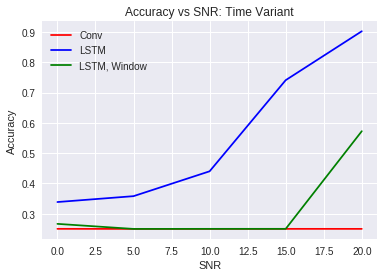

In [49]:
s_lstm2 = np.array(scores_lstm2)
s_lstm2_W = np.array(scores_lstm2_W)
s_conv2 = np.array(scores_conv2)
#s_lms2 = 1-np.array([2,2.47,5.82,21.18,41.54,56.99,66.24,71.6,73.42,74.5])*1.0/100
#s_lms2 = 1-np.array([5.24,5.34,8.01,21.62,40.6,56.13,65.12,70.04,72.57,72.51])*1.0/100

plt.plot(snrs,s_conv2[:,1],"r",label="Conv")
plt.plot(snrs,s_lstm2[:,1],"b",label="LSTM")
plt.plot(snrs,s_lstm2_W[:,1],"g",label="LSTM, Window")
#plt.plot(snrs,s_lms2,"y",label="LMS")
plt.legend()
plt.xlabel("SNR")
plt.ylabel("Accuracy")
plt.title("Accuracy vs SNR: Time Variant")

# from google.colab import files
# plt.savefig("SNR_time_variant.png")
# files.download("SNR_time_variant.png")

##Symbol Error Comparison with No Noise. Can see how each decoder handles the switching channels only

In [17]:
m = 4         # order of modulation
trials = 15000   # number of trials 
Noise = False
seqLen = 300
print(seqLen)
h_list = []
h_list.append(np.array([1,0.5,-0.3]))
h_list.append(np.array([1,-.5,-0.5]))
h_list.append(np.array([1,-0.25,-0.25]))
h_list = np.array(h_list)
chanelLen = len(h_list[0])
channel_dur = 75
print("Channel: ",h_list)


#LSTM no window
hist1_n ,score1_n = LSTM_variant_no_window()
#LSTM with window
hist2_n,score2_n = LSTM_variant_with_window()
#CNN
hist3_n,score3_n = ConvNet_variant()

print("LSTM No Window Score: ",score1_n)
print("LSTM with Window Score: ",score2_n)
print("Conv Score: ",score3_n)



300
Channel:  [[ 1.    0.5  -0.3 ]
 [ 1.   -0.5  -0.5 ]
 [ 1.   -0.25 -0.25]]
x_train shape:  (15000, 302, 2)
y_train shape:  (15000, 300)
y_train shape, one-hot:  (15000, 300, 4)
y_train shape, one-hot, padding:  (15000, 302, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_25 (CuDNNLSTM)    (None, 302, 30)           4080      
_________________________________________________________________
time_distributed_37 (TimeDis (None, 302, 30)           120       
_________________________________________________________________
time_distributed_38 (TimeDis (None, 302, 4)            124       
Total params: 4,324
Trainable params: 4,264
Non-trainable params: 60
_________________________________________________________________
Train on 15000 samples, validate on 7500 samples
Epoch 1/20
15000/15000 [==============================] - 5s 357us/step - loss: 1.0215 - accuracy_with_masking: 0.5571 - val

15000/15000 [==============================] - 2s 121us/step - loss: 0.1587 - accuracy_with_masking: 0.9782 - val_loss: 0.2249 - val_accuracy_with_masking: 0.9409
Epoch 8/20
15000/15000 [==============================] - 2s 121us/step - loss: 0.1308 - accuracy_with_masking: 0.9868 - val_loss: 0.2001 - val_accuracy_with_masking: 0.9622
Epoch 9/20
15000/15000 [==============================] - 2s 120us/step - loss: 0.1100 - accuracy_with_masking: 0.9921 - val_loss: 0.1771 - val_accuracy_with_masking: 0.9765
Epoch 10/20
15000/15000 [==============================] - 2s 121us/step - loss: 0.0949 - accuracy_with_masking: 0.9943 - val_loss: 0.1575 - val_accuracy_with_masking: 0.9824
Epoch 11/20
15000/15000 [==============================] - 2s 121us/step - loss: 0.0839 - accuracy_with_masking: 0.9956 - val_loss: 0.1427 - val_accuracy_with_masking: 0.9832
Epoch 12/20
15000/15000 [==============================] - 2s 121us/step - loss: 0.0755 - accuracy_with_masking: 0.9962 - val_loss: 0.1313 

15000/15000 [==============================] - 2s 121us/step - loss: 0.0586 - accuracy_with_masking: 0.9974 - val_loss: 0.1113 - val_accuracy_with_masking: 0.9862
Epoch 18/20
15000/15000 [==============================] - 2s 120us/step - loss: 0.0577 - accuracy_with_masking: 0.9975 - val_loss: 0.1101 - val_accuracy_with_masking: 0.9871
Epoch 19/20
15000/15000 [==============================] - 2s 121us/step - loss: 0.0569 - accuracy_with_masking: 0.9975 - val_loss: 0.1088 - val_accuracy_with_masking: 0.9879
Epoch 20/20
15000/15000 [==============================] - 1s 41us/step
x_train shape:  (15000, 302, 2)
y_train shape:  (15000, 300)
y_train shape, one-hot:  (15000, 300, 4)
y_train shape, one-hot, padding:  (15000, 302, 4)
x_train shape, window:  (15000, 302, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_26 (CuDNNLSTM)    (None, 302, 40)           8320      
________________________

15000/15000 [==============================] - 2s 137us/step - loss: 0.8128 - accuracy_with_masking: 0.8586 - val_loss: 0.8163 - val_accuracy_with_masking: 0.6661
Epoch 5/20
15000/15000 [==============================] - 2s 137us/step - loss: 0.6504 - accuracy_with_masking: 0.9073 - val_loss: 0.6974 - val_accuracy_with_masking: 0.7462
Epoch 6/20
15000/15000 [==============================] - 2s 136us/step - loss: 0.5142 - accuracy_with_masking: 0.9427 - val_loss: 0.6023 - val_accuracy_with_masking: 0.8289
Epoch 7/20
15000/15000 [==============================] - 2s 136us/step - loss: 0.4150 - accuracy_with_masking: 0.9654 - val_loss: 0.5155 - val_accuracy_with_masking: 0.9127
Epoch 8/20
15000/15000 [==============================] - 2s 136us/step - loss: 0.3390 - accuracy_with_masking: 0.9813 - val_loss: 0.4425 - val_accuracy_with_masking: 0.9585
Epoch 9/20
15000/15000 [==============================] - 2s 136us/step - loss: 0.2835 - accuracy_with_masking: 0.9908 - val_loss: 0.3811 - v

15000/15000 [==============================] - 2s 136us/step - loss: 0.1618 - accuracy_with_masking: 0.9993 - val_loss: 0.2100 - val_accuracy_with_masking: 0.9994
Epoch 15/20
15000/15000 [==============================] - 2s 137us/step - loss: 0.1510 - accuracy_with_masking: 0.9995 - val_loss: 0.1929 - val_accuracy_with_masking: 0.9995
Epoch 16/20
15000/15000 [==============================] - 2s 138us/step - loss: 0.1420 - accuracy_with_masking: 0.9995 - val_loss: 0.1790 - val_accuracy_with_masking: 0.9996
Epoch 17/20
15000/15000 [==============================] - 2s 136us/step - loss: 0.1345 - accuracy_with_masking: 0.9996 - val_loss: 0.1673 - val_accuracy_with_masking: 0.9997
Epoch 18/20
15000/15000 [==============================] - 2s 137us/step - loss: 0.1280 - accuracy_with_masking: 0.9997 - val_loss: 0.1574 - val_accuracy_with_masking: 0.9997
Epoch 19/20
15000/15000 [==============================] - 2s 136us/step - loss: 0.1224 - accuracy_with_masking: 0.9997 - val_loss: 0.148

15000/15000 [==============================] - 5s 339us/step - loss: 0.9442 - acc: 0.6392 - val_loss: 0.7074 - val_acc: 0.7417
Epoch 2/20
15000/15000 [==============================] - 2s 100us/step - loss: 0.2399 - acc: 0.9847 - val_loss: 0.5791 - val_acc: 0.8057
Epoch 3/20
15000/15000 [==============================] - 2s 104us/step - loss: 0.0825 - acc: 0.9997 - val_loss: 0.6140 - val_acc: 0.8146
Epoch 4/20
15000/15000 [==============================] - 2s 104us/step - loss: 0.0409 - acc: 1.0000 - val_loss: 0.6678 - val_acc: 0.8164
Epoch 5/20
15000/15000 [==============================] - 2s 101us/step - loss: 0.0247 - acc: 1.0000 - val_loss: 0.7193 - val_acc: 0.8166
Epoch 6/20
15000/15000 [==============================] - 2s 102us/step - loss: 0.0167 - acc: 1.0000 - val_loss: 0.7643 - val_acc: 0.8165
Epoch 7/20
15000/15000 [==============================] - 2s 100us/step - loss: 0.0121 - acc: 1.0000 - val_loss: 0.8042 - val_acc: 0.8163
Epoch 8/20
15000/15000 [=====================

Epoch 9/20
15000/15000 [==============================] - 2s 101us/step - loss: 0.0072 - acc: 1.0000 - val_loss: 0.8709 - val_acc: 0.8158
Epoch 10/20
15000/15000 [==============================] - 2s 104us/step - loss: 0.0058 - acc: 1.0000 - val_loss: 0.8989 - val_acc: 0.8157
Epoch 11/20
15000/15000 [==============================] - 2s 101us/step - loss: 0.0048 - acc: 1.0000 - val_loss: 0.9244 - val_acc: 0.8155
Epoch 12/20
15000/15000 [==============================] - 2s 101us/step - loss: 0.0040 - acc: 1.0000 - val_loss: 0.9476 - val_acc: 0.8153
Epoch 13/20
15000/15000 [==============================] - 1s 100us/step - loss: 0.0034 - acc: 1.0000 - val_loss: 0.9690 - val_acc: 0.8151
Epoch 14/20
15000/15000 [==============================] - 2s 103us/step - loss: 0.0030 - acc: 1.0000 - val_loss: 0.9888 - val_acc: 0.8150
Epoch 15/20
15000/15000 [==============================] - 2s 102us/step - loss: 0.0026 - acc: 1.0000 - val_loss: 1.0074 - val_acc: 0.8148
Epoch 16/20
12250/15000 [===

15000/15000 [==============================] - 2s 100us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 1.0241 - val_acc: 0.8148
Epoch 17/20
15000/15000 [==============================] - 2s 103us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 1.0406 - val_acc: 0.8146
Epoch 18/20
15000/15000 [==============================] - 2s 102us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 1.0560 - val_acc: 0.8144
Epoch 19/20
15000/15000 [==============================] - 2s 102us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 1.0702 - val_acc: 0.8143
Epoch 20/20
15000/15000 [==============================] - 2s 130us/step
Test accuracy: [0.06742531068722407, 0.9776008907953898]
LSTM No Window Score:  [0.051715163389841716, 0.996222448348999]
LSTM with Window Score:  [0.2623449683189392, 0.9389404416084289]
Conv Score:  [0.06742531068722407, 0.9776008907953898]
